# ATLAS OmniFold - Technical Closure and Stress Tests
In this notebook, we use a single a sample to perform a technical closure test (unfolding the sample against itself) and stress tests (unfolding the sample with artificial "stress" weights).

### Standard Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from __future__ import absolute_import, division, print_function

from ntupleanalysis import *
import math

import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

import energyflow as ef
from energyflow.archs import PFN

Using TensorFlow backend.


In [4]:
plot_setup()

In [5]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [6]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'histtype': 'stepfilled','alpha': 0.5, 'density': True}

### Utilities

In [7]:
# from NN (DCTR)
def reweight(model, events):
    f = model.predict(events, batch_size=1000)
    weights = f / (1. - f)
    return np.squeeze(weights)

In [8]:
def sigmoid(x):
    return 1./(1. + np.exp(-x)) 

### Load ROOT file

In [9]:
zmumu_0 = uproot.open(
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Oct5_PowhegPythia_mc16e.root"
)['EventTree']

In [10]:
zmumu_0.show()

CutFlow                    (no streamer)              asdtype('>i4')
EventNumber                (no streamer)              asdtype('>i4')
RunNumber                  (no streamer)              asdtype('>i4')
LumiBlock                  (no streamer)              asdtype('>i4')
BCID                       (no streamer)              asdtype('>i4')
NPV                        (no streamer)              asdtype('>i4')
pass                       (no streamer)              asdtype('>i4')
truth_pass                 (no streamer)              asdtype('>i4')
initialWeight              (no streamer)              asdtype('>f4')
pileupWeight               (no streamer)              asdtype('>f4')
genWeight                  (no streamer)              asdtype('>f4')
weight                     (no streamer)              asdtype('>f4')
mu_recoSF                  (no streamer)              asdtype('>f4')
mu_isoSF                   (no streamer)              asdtype('>f4')
mu_TTVASF                  (no str

In [11]:
mybranches_0 = []
for mykey in zmumu_0.keys():
    mybranches_0 += [mykey.decode("utf-8")]

In [12]:
Events_0 = prepare_dataset_table([
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Oct5_PowhegPythia_mc16e.root"
],
                               "EventTree",
                               branch_list=mybranches_0,
                               col_names=mybranches_0,
                               entrysteps=10000000,
                               outputype=Event_table)

Total number of events:  666677
Events in returned Object:  666677
Loading the data took  84.97631931304932  seconds


### Unpack data

In [13]:
# Event selection

# we should eventually properly account for events that fail one of Gen or Sim.  For now, just ignore them.

mypass_0 = (Events_0.events['m_ll'] > 0) & (Events_0.events['m_ll'] < 200) & (
    Events_0.events['truth_m_ll'] > 0) & (Events_0.events['truth_m_ll'] < 200)

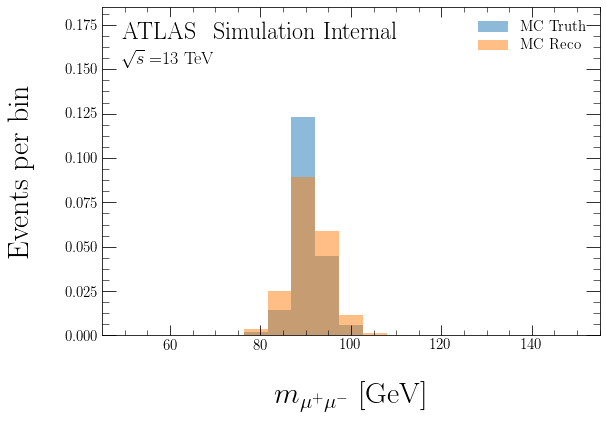

In [14]:
plt.figure()
hT, _, _ = plt.hist(Events_0.events['truth_m_ll'][mypass_0],
                    label="MC Truth",
                    bins=np.linspace(50, 150, 20),
                    alpha=0.5, density=True)
hR, _, _ = plt.hist(Events_0.events['m_ll'][mypass_0],
                    label="MC Reco",
                    bins=np.linspace(50, 150, 20),
                    alpha=0.5, density=True)

plt.xlabel("$m_{\mu^+\mu^-}$ [GeV]")
plt.ylabel("Events per bin (normalized)")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.legend()
plt.ylim([0, 1.5 * max(max(hT), max(hR))])
plt.show()

In [15]:
mytracks_sim_truth = Events_0.events['truth_pT_Tracks'][mypass_0]
ntrack_sim_truth = [len(mytracks_sim_truth[i]) for i in range(len(mytracks_sim_truth))]

In [16]:
mytracks_sim_reco = Events_0.events['pT_Tracks'][mypass_0]
ntrack_sim_reco = [len(mytracks_sim_reco[i]) for i in range(len(mytracks_sim_reco))]

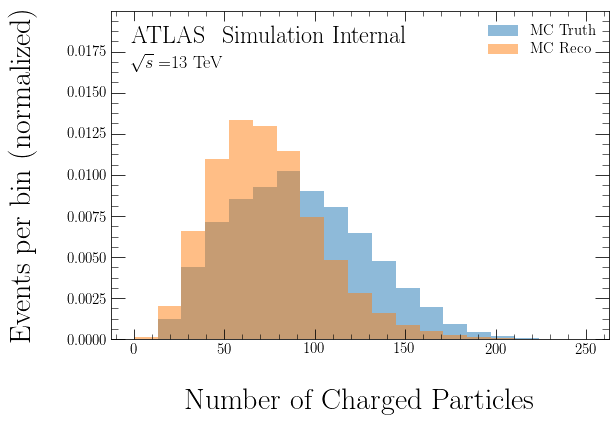

In [17]:
hT, _, _ = plt.hist(ntrack_sim_truth,
                    label="MC Truth",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
hR, _, _ = plt.hist(ntrack_sim_reco,
                    label="MC Reco",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
plt.xlabel("Number of Charged Particles")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.ylabel("Events per bin (normalized)")
plt.legend()
plt.ylim([0, 1.5 * max(max(hT), max(hR))])
plt.show()

### Define UniFold Algorithm

In [18]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        sim_truth: MC Truth observable as Numpy array
                    
        sim_reco: MC Reco observable as Numpy array
                    
        data_reco: Data Reco observable 
                            to be unfolded as Numpy arrays
                            
        weights_MC_sim: (optional) initial MC generator weights for simulation sample
        
        weights_MC_data: (optional) initial MC generator weights for "data" sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    sim_truth to the unfolded distribution of data_reco
        
        model: The model used to calculate those weights
"""


def unifold(iterations,
            sim_truth,
            sim_reco,
            data_reco,
            weights_MC_sim=None,
            weights_MC_data=None):
    
    if weights_MC_sim is None:
        weights_MC_sim = np.ones(len(sim_truth)) 
        
    if weights_MC_data is None:
        weights_MC_data = np.ones(len(data_reco))

    labels_0 = np.zeros(len(sim_truth))
    labels_unknown = np.ones(len(data_reco))

    xvals_1 = np.concatenate((sim_reco, data_reco))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((sim_truth, sim_truth))
    yvals_2 = np.concatenate((labels_0, (labels_0+1.)))

    weights = np.empty(shape=(iterations, 2, len(sim_truth)))
    # shape = (iteration, step, event)

    weights_pull = weights_MC_sim
    weights_push = weights_MC_sim

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify MC Reco (which is reweighted by weights_push) to Data Reco
        # weights reweighted MC Reco --> Data Reco
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, weights_MC_data))
        # actual weights for MC Reco, ones for Data Reco

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, sim_reco)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify MC Truth to reweighted MC Truth (which is reweighted by weights_pull)
        # weights MC Truth --> reweighted MC Truth
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((weights_MC_sim, weights_pull))
        # ones for MC Truth, actual weights for (reweighted) MC Truth

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weights_MC_sim * reweight(model, sim_truth)
        weights[i, 1:2, :] = weights_push

    return weights, model

### Define MultiFold Algorithm

In [19]:
# Input multiple observables as tuple or list (i.e. sim_truth = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        sim_truth: tuple or list of MC Truth 
                    observables as Numpy arrays
                    
        sim_reco: tuple or list of MC Reco 
                    observables as Numpy arrays
                    
        data_reco: tuple or list of Data Reco 
                    observables to be unfolded 
                    as Numpy arrays
        
        weights_MC_sim: (optional) initial MC generator weights for simulation sample
        
        weights_MC_data: (optional) initial MC generator weights for "data" sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    sim_truth to the unfolded distribution of data_reco
        
        model: The model used to calculate those weights
"""
 

def multifold(num_observables,
              iterations,
              sim_truth,
              sim_reco,
              data_reco,
              weights_MC_sim=None,
              weights_MC_data=None):

    sim_truth = np.stack(sim_truth, axis=1)
    sim_reco = np.stack(sim_reco, axis=1)
    data_reco = np.stack(data_reco, axis=1)
    
    if weights_MC_sim is None:
        weights_MC_sim = np.ones(len(sim_truth)) 
        
    if weights_MC_data is None:
        weights_MC_data = np.ones(len(data_reco))

    labels_0 = np.zeros(len(sim_truth))
    labels_unknown = np.ones(len(data_reco))

    xvals_1 = np.concatenate((sim_reco, data_reco))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((sim_truth, sim_truth))
    yvals_2 = np.concatenate((labels_0, (labels_0+1.)))

    weights = np.empty(shape=(iterations, 2, len(sim_truth)))
    # shape = (iteration, step, event)

    weights_pull = weights_MC_sim
    weights_push = weights_MC_sim

    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify MC Reco (which is reweighted by weights_push) to Data Reco
        # weights reweighted MC Reco --> Data Reco
        print("STEP 1\n")

        weights_1 = np.concatenate(
            (weights_push, weights_MC_data))
        # actual weights for MC Reco, ones for Data Reco

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, sim_reco)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify MC Truth to reweighted MC Truth (which is reweighted by weights_pull)
        # weights MC Truth --> reweighted MC Truth
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((weights_MC_sim, weights_pull))
        # ones for MC Truth, actual weights for (reweighted) MC Truth

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weights_MC_sim * reweight(model, sim_truth)
        weights[i, 1:2, :] = weights_push

    return weights, model

### Define OmniFold Algorithm

In [ ]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        sim_truth: MC Truth events 
                    (i.e. list of events with particles as 
                    (pT, eta, phi, charge)) as zero-padded Numpy array
                    
        sim_truth: MC Reco events 
                    (i.e. list of events with particles as 
                    (pT, eta, phi, charge)) as zero-padded Numpy array
                    
        data_reco: Data Reco events 
                            (i.e. list of events with particles as 
                            (pT, eta, phi, charge))
                            to be unfolded as zero-padded Numpy array 
                            
        
        weights_MC_sim: (optional) initial MC generator weights for simulation sample
        
        weights_MC_data: (optional) initial MC generator weights for data sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    sim_truth to the unfolded distribution of data_reco
        
        model: The model used to calculate those weights
"""


def omnifold(iterations,
             sim_truth,
             sim_reco,
             data_reco,
             weights_MC_sim=None,
             weights_MC_data=None):

    if weights_MC_sim is None:
        weights_MC_sim = np.ones(len(sim_truth))

    if weights_MC_data is None:
        weights_MC_data = np.ones(len(data_reco))

    labels_0 = np.zeros(len(sim_truth))
    labels_unknown = np.ones(len(data_reco))

    xvals_1 = np.concatenate((sim_reco, data_reco))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((sim_truth, sim_truth))
    yvals_2 = np.concatenate((labels_0, (labels_0 + 1.)))

    weights = np.empty(shape=(iterations, 2, len(sim_truth)))
    # shape = (iteration, step, event)

    weights_pull = weights_MC_sim
    weights_push = weights_MC_sim

    # network architecture parameters
    Phi_sizes = (100, 100, 128)
    F_sizes = (100, 100, 100)

    model = PFN(input_dim=4,
                Phi_sizes=Phi_sizes,
                F_sizes=F_sizes,
                latent_dropout=0.2,
                F_dropouts=0.2,
                output_dim=1,
                output_act='sigmoid',
                summary=False)

    earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

    print("Jumpstarting Model\n")
    count = 0
    while count < 20:
        count += 1

        X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(
            xvals_1, yvals_1)

        model.model.compile(loss='binary_crossentropy',
                            optimizer=keras.optimizers.Adam(),
                            metrics=['accuracy'])
        history = model.fit(X_train_1,
                            Y_train_1,
                            epochs=1,
                            batch_size=10000,
                            validation_data=(X_test_1, Y_test_1),
                            verbose=1)
        if (history.history['val_loss'][0] < history.history['loss'][0] - 0.1
            ) or history.history['val_loss'][0] < 1:
            break
        else:
            K.clear_session()

            model = PFN(input_dim=4,
                        Phi_sizes=Phi_sizes,
                        F_sizes=F_sizes,
                        latent_dropout=0.2,
                        F_dropouts=0.2,
                        output_dim=1,
                        output_act='sigmoid',
                        summary=False)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify MC Reco (which is reweighted by weights_push) to Data Reco
        # weights reweighted MC Reco --> Data Reco
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, weights_MC_data))
        # actual weights for MC Reco, initial MC for Data Reco

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

    
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=1000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, sim_reco)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify MC Truth to reweighted MC Truth (which is reweighted by weights_pull)
        # weights MC Truth --> reweighted MC Truth
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((weights_MC_sim, weights_pull))
        # initial MC for MC Truth, actual weights for (reweighted) MC Truth

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.model.compile(loss='binary_crossentropy',
                            optimizer='Adam',
                            metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=1000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weights_MC_sim * reweight(model, sim_truth)
        weights[i, 1:2, :] = weights_push

    return weights, model

# Technical Closure Test
We split the existing sample in half and unfold it against itself.

## UniFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles separately.

### Setup Datasets

In [20]:
m_ll_sim_truth, m_ll_data_truth, m_ll_sim_reco, m_ll_data_reco = train_test_split(Events_0.events['truth_m_ll'][mypass_0],
                                                                      Events_0.events['m_ll'][mypass_0], 
                                                                      test_size=0.5)

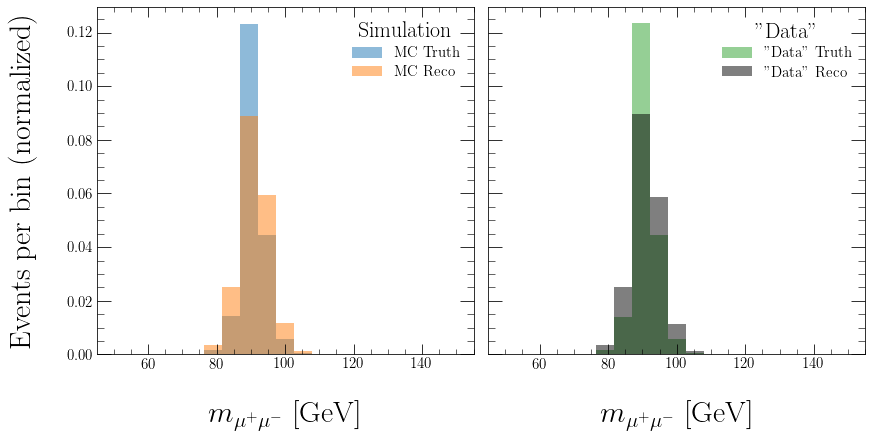

In [21]:
bins = np.linspace(50, 150, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Events per bin (normalized)')
hG0, _, _ = ax[0].hist(m_ll_sim_truth,
                       bins=bins,
                       label='MC Truth',
                       **plot_style_2,
                       color='C0')
hS0, _, _ = ax[0].hist(m_ll_sim_reco,
                       bins=bins,
                       label='MC Reco',
                       **plot_style_2,
                       color='C1')
legend = ax[0].legend(title='Simulation', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[1].hist(m_ll_data_truth,
                       bins=bins,
                       label='"Data" Truth',
                       **plot_style_2,
                       color='C2')
hS1, _, _ = ax[1].hist(m_ll_data_reco,
                       bins=bins,
                       label='"Data" Reco',
                       **plot_style_2,
                       color='k')
legend = ax[1].legend(title='"Data"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-TechnicalClosureTest-UniFold-m_ll-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

In [22]:
nTracks_sim_truth, nTracks_data_truth, nTracks_sim_reco, nTracks_data_reco = train_test_split(np.array(ntrack_sim_truth),
                                                                      np.array(ntrack_sim_reco), 
                                                                      test_size=0.5)

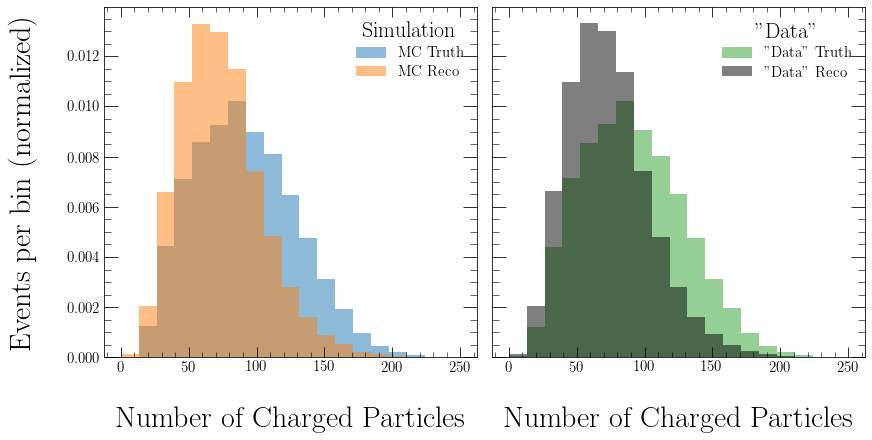

In [23]:
bins = np.linspace(0, 250, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Events per bin (normalized)')
hG0, _, _ = ax[0].hist(nTracks_sim_truth,
                       bins=bins,
                       label='MC Truth',
                       **plot_style_2,
                       color='C0')
hS0, _, _ = ax[0].hist(nTracks_sim_reco,
                       bins=bins,
                       label='MC Reco',
                       **plot_style_2,
                       color='C1')
legend = ax[0].legend(title='Simulation', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1].hist(nTracks_data_truth,
                       bins=bins,
                       label='"Data" Truth',
                       **plot_style_2,
                       color='C2')
hS1, _, _ = ax[1].hist(nTracks_data_reco,
                       bins=bins,
                       label='"Data" Reco',
                       **plot_style_2,
                       color='k')
legend = ax[1].legend(title='"Data"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-TechnicalClosureTest-UniFold-nTracks-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

### Unfold $m_{\mu^+\mu^-}$

In [24]:
# z-score standardization of data

scaler_truth = preprocessing.StandardScaler()
scaler_reco = preprocessing.StandardScaler()

scaler_truth.fit(m_ll_sim_truth.reshape(-1,1))
scaler_reco.fit(np.concatenate((m_ll_sim_reco, m_ll_data_reco)).reshape(-1,1))

sim_truth = np.squeeze(scaler_truth.transform(m_ll_sim_truth.reshape(-1,1)))
sim_reco = np.squeeze(scaler_reco.transform(m_ll_sim_reco.reshape(-1,1)))
data_reco = np.squeeze(scaler_reco.transform(m_ll_data_reco.reshape(-1,1)))

In [25]:
weights, _ = unifold(iterations=3,
                     sim_truth=sim_truth,
                     sim_reco=sim_reco,
                     data_reco=data_reco)





ITERATION: 1

STEP 1



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 466582 samples, validate on 155528 samples
Epoch 1/200





466582/466582 [==============================] - 6s 13us/step - loss: 0.6933 - acc: 0.5017 - val_loss: 0.6932 - val_acc: 0.5001
Epoch 2/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6932 - acc: 0.5013 - val_loss: 0.6932 - val_acc: 0.4999
Epoch 3/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6932 - acc: 0.5020 - val_loss: 0.6932 - val_acc: 0.4983
Epoch 4/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6932 - acc: 0.5011 - val_loss: 0.6932 - val_acc: 0.4981
Epoch 5/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6932 - acc: 0.5013 - val_loss: 0.6932 - val_acc: 0.4985
Epoch 6/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6932 - acc: 0.5025 - val_loss: 0.6

466582/466582 [==============================] - 5s 11us/step - loss: 0.6940 - acc: 0.5008 - val_loss: 0.6940 - val_acc: 0.4999
Epoch 10/200
466582/466582 [==============================] - 4s 10us/step - loss: 0.6940 - acc: 0.4996 - val_loss: 0.6940 - val_acc: 0.4999
Epoch 11/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6940 - acc: 0.4995 - val_loss: 0.6940 - val_acc: 0.5013
Epoch 12/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6940 - acc: 0.4983 - val_loss: 0.6940 - val_acc: 0.5008
Epoch 13/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6940 - acc: 0.4990 - val_loss: 0.6940 - val_acc: 0.4994
Epoch 14/200
466582/466582 [==============================] - 4s 10us/step - loss: 0.6940 - acc: 0.4987 - val_loss: 0.6940 - val_acc: 0.4976
Epoch 15/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6940 - acc: 0.4997 - val_loss: 0.6940 - val_acc: 0.5007
Epoch 16/200
466582/466582

466582/466582 [==============================] - 5s 10us/step - loss: 0.6948 - acc: 0.4991 - val_loss: 0.6948 - val_acc: 0.5006
Epoch 10/200
466582/466582 [==============================] - 4s 9us/step - loss: 0.6948 - acc: 0.4998 - val_loss: 0.6948 - val_acc: 0.5006
Epoch 11/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6948 - acc: 0.4998 - val_loss: 0.6948 - val_acc: 0.5006
Epoch 12/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6948 - acc: 0.4990 - val_loss: 0.6948 - val_acc: 0.5006
Epoch 13/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6948 - acc: 0.4994 - val_loss: 0.6948 - val_acc: 0.5006
Restoring model weights from the end of the best epoch
Epoch 00013: early stopping

ITERATION: 3

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 6s 14us/step - loss: 0.6952 - acc: 0.4991 - val_loss: 0.6952 - val_acc: 0.5008
Epoch 2/200

#### Results

ITERATION 1:


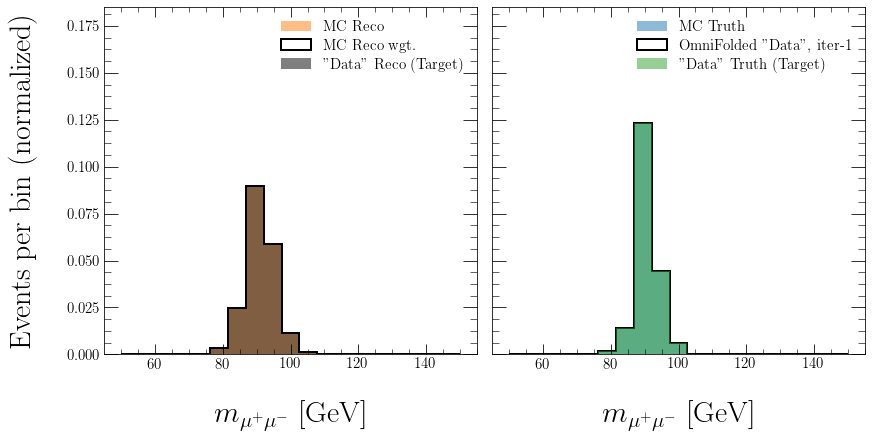

ITERATION 2:


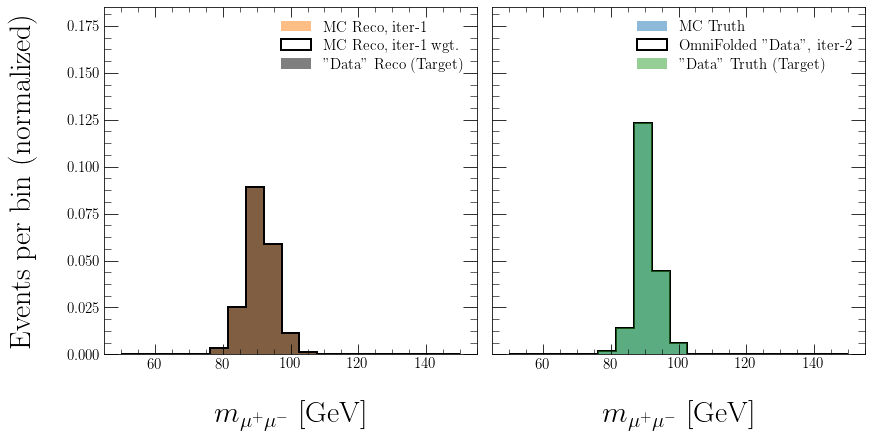

ITERATION 3:


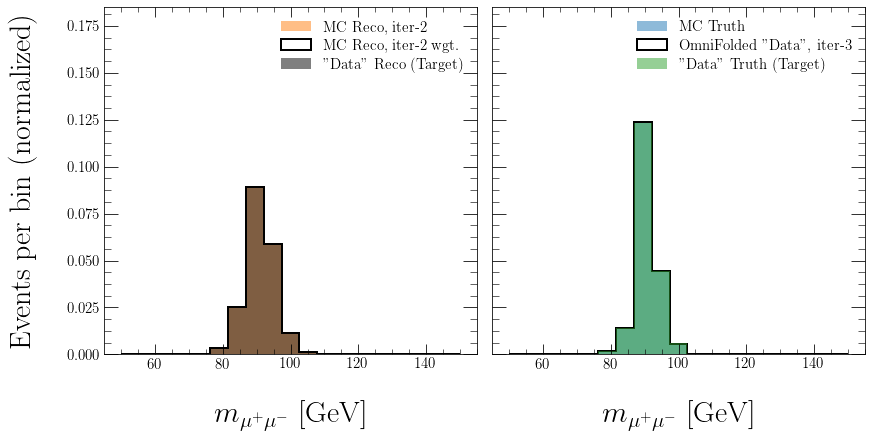

In [26]:
bins = np.linspace(50, 150, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(m_ll_sim_reco))
        label0 = ''
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    ax[0].hist(m_ll_sim_reco,
               weights=weights_init,
               bins=bins,
               label='MC Reco' + label0,
               **plot_style_2,
               color='C1')

    ax[0].hist(m_ll_sim_reco,
               bins=bins,
               label='MC Reco' + label0 + ' wgt.',
               weights=weights[i, 0, :],
               **plot_style_1)
    hR, _, _ = ax[0].hist(m_ll_data_reco,
                          bins=bins,
                          label='"Data" Reco (Target)',
                          **plot_style_2,
                          color='k')
    ax[0].set_xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend()
    ax[1].hist(m_ll_sim_truth, bins=bins, label=r'MC Truth', **plot_style_2)

    ax[1].hist(m_ll_sim_truth,
               bins=bins,
               label='OmniFolded "Data"' + label1,
               weights=weights[i, 1, :],
               **plot_style_1)
    hT, _, _ = ax[1].hist(m_ll_data_truth,
                          bins=bins,
                          label='"Data" Truth (Target)',
                          **plot_style_2,
                          color='C2')
    ax[1].legend()
    ax[1].set_xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")

    plt.ylim([0, 1.5 * max(max(hT), max(hR))])
    fig.show()
    #     fig.savefig(
    #         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-TechnicalClosureTest-UniFold-m_ll-Iteration{:02}.pdf'
    #         .format(i + 1),
    #         bbox_inches='tight')
    plt.show()

### Unfold Number of Charged Particles

In [27]:
# z-score standardization of data

scaler_truth = preprocessing.StandardScaler()
scaler_reco = preprocessing.StandardScaler()

scaler_truth.fit(nTracks_sim_truth.reshape(-1,1))
scaler_reco.fit(np.concatenate((nTracks_sim_reco, nTracks_data_reco)).reshape(-1,1))

sim_truth = np.squeeze(scaler_truth.transform(nTracks_sim_truth.reshape(-1,1)))
sim_reco = np.squeeze(scaler_reco.transform(nTracks_sim_reco.reshape(-1,1)))
data_reco = np.squeeze(scaler_reco.transform(nTracks_data_reco.reshape(-1,1)))

In [28]:
weights, _ = unifold(iterations=3,
                     sim_truth=sim_truth,
                     sim_reco=sim_reco,
                     data_reco=data_reco)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 6s 13us/step - loss: 0.6932 - acc: 0.4997 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6932 - val_acc: 0.4981
Epoch 3/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6932 - acc: 0.5003 - val_loss: 0.6932 - val_acc: 0.4982
Epoch 4/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6932 - acc: 0.5011 - val_loss: 0.6933 - val_acc: 0.4981
Epoch 5/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6932 - acc: 0.5003 - val_loss: 0.6932 - val_acc: 0.5010
Epoch 6/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.4983
Epoch 7/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6

466582/466582 [==============================] - 7s 14us/step - loss: 0.6961 - acc: 0.4999 - val_loss: 0.6960 - val_acc: 0.5002
Epoch 2/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6960 - acc: 0.5001 - val_loss: 0.6960 - val_acc: 0.4991
Epoch 3/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6960 - acc: 0.5002 - val_loss: 0.6961 - val_acc: 0.4991
Epoch 4/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6961 - acc: 0.4999 - val_loss: 0.6961 - val_acc: 0.4991
Epoch 5/200
466582/466582 [==============================] - 4s 9us/step - loss: 0.6960 - acc: 0.5001 - val_loss: 0.6961 - val_acc: 0.4992
Epoch 6/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6960 - acc: 0.5008 - val_loss: 0.6961 - val_acc: 0.4990
Epoch 7/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6961 - acc: 0.4999 - val_loss: 0.6960 - val_acc: 0.4982
Epoch 8/200
466582/466582 [======

#### Results

ITERATION 1:


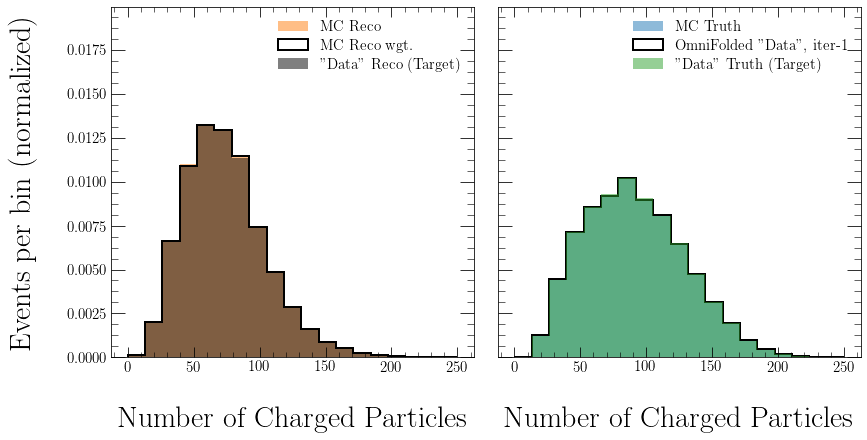

ITERATION 2:


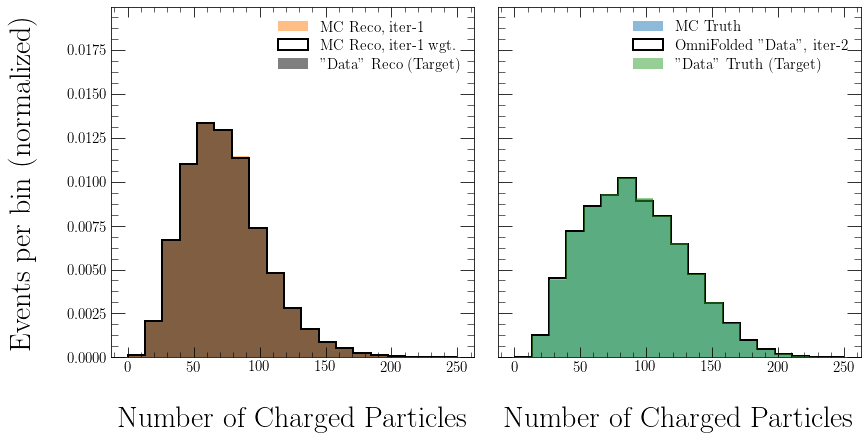

ITERATION 3:


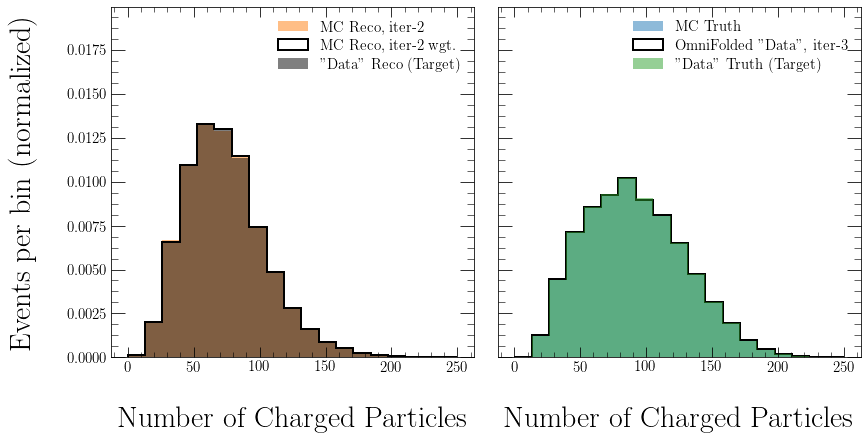

In [29]:
bins = np.linspace(0, 250, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(nTracks_sim_reco))
        label0 = ''
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    ax[0].hist(nTracks_sim_reco,
               weights=weights_init,
               bins=bins,
               label='MC Reco' + label0,
               **plot_style_2,
               color='C1')

    ax[0].hist(nTracks_sim_reco,
               bins=bins,
               label='MC Reco' + label0 + ' wgt.',
               weights=weights[i, 0, :],
               **plot_style_1)
    hR, _, _ = ax[0].hist(nTracks_data_reco,
                          bins=bins,
                          label='"Data" Reco (Target)',
                          **plot_style_2,
                          color='k')
    ax[0].set_xlabel(r"Number of Charged Particles")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend()
    ax[1].hist(nTracks_sim_truth, bins=bins, label=r'MC Truth', **plot_style_2)

    ax[1].hist(nTracks_sim_truth,
               bins=bins,
               label='OmniFolded "Data"' + label1,
               weights=weights[i, 1, :],
               **plot_style_1)
    hT, _, _ = ax[1].hist(nTracks_data_truth,
                          bins=bins,
                          label='"Data" Truth (Target)',
                          **plot_style_2,
                          color='C2')
    ax[1].legend()
    ax[1].set_xlabel(r"Number of Charged Particles")

    plt.ylim([0, 1.5 * max(max(hT), max(hR))])
    fig.show()
#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-TechnicalClosureTest-UniFold-nTracks-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    plt.show()

## Multifold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles simultaneously.

In [30]:
K.clear_session()

### Setup datasets

In [31]:
m_ll_sim_truth, m_ll_data_truth, m_ll_sim_reco, m_ll_data_reco, nTracks_sim_truth, nTracks_data_truth, nTracks_sim_reco, nTracks_data_reco = train_test_split(
    Events_0.events['truth_m_ll'][mypass_0],
    Events_0.events['m_ll'][mypass_0],
    np.array(ntrack_sim_truth),
    np.array(ntrack_sim_reco),
    test_size=0.5)

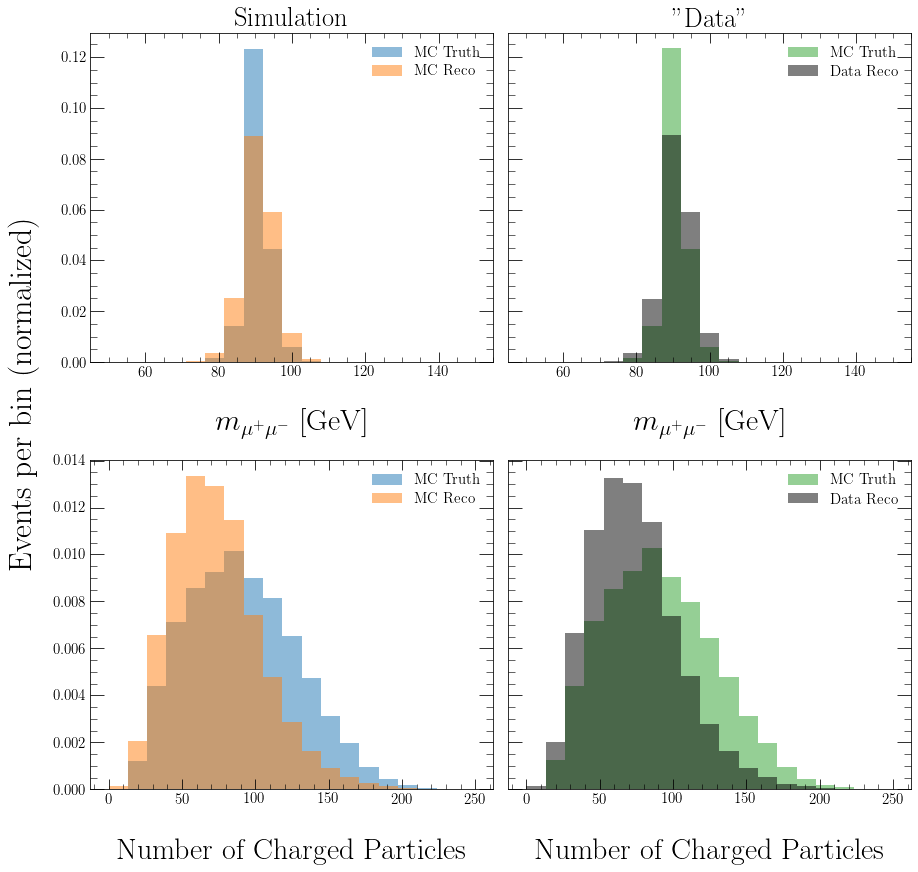

In [32]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 12),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(50, 150, 20)

ax[0, 0].set_title('Simulation')
ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG0, _, _ = ax[0, 0].hist(m_ll_sim_truth,
                          bins=bins,
                          label='MC Truth',
                          **plot_style_2,
                          color='C0')
hS0, _, _ = ax[0, 0].hist(m_ll_sim_reco,
                          bins=bins,
                          label='MC Reco',
                          **plot_style_2,
                          color='C1')
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Data"')
ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[0, 1].hist(m_ll_data_truth,
                          bins=bins,
                          label='MC Truth',
                          **plot_style_2,
                          color='C2')
hS1, _, _ = ax[0, 1].hist(m_ll_data_reco,
                          bins=bins,
                          label='Data Reco',
                          **plot_style_2,
                          color='k')
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
hG0, _, _ = ax[1, 0].hist(nTracks_sim_truth,
                          bins=bins,
                          label='MC Truth',
                          **plot_style_2,
                          color='C0')
hS0, _, _ = ax[1, 0].hist(nTracks_sim_reco,
                          bins=bins,
                          label='MC Reco',
                          **plot_style_2,
                          color='C1')
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(nTracks_data_truth,
                          bins=bins,
                          label='MC Truth',
                          **plot_style_2,
                          color='C2')
hS1, _, _ = ax[1, 1].hist(nTracks_data_reco,
                          bins=bins,
                          label='Data Reco',
                          **plot_style_2,
                          color='k')
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.text(-0.05,
         0.55,
         'Events per bin (normalized)',
         va='center',
         rotation='vertical',
         fontsize='x-large')
# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-TechnicalClosureTest-MultiFold-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

### Unfold $m_{\mu^+\mu^-}$ and Number of Charged Particles Simultaneously

In [33]:
num_observables = 2

# z-score standardization

scaler_m_ll_truth = preprocessing.StandardScaler()
scaler_m_ll_reco = preprocessing.StandardScaler()

scaler_m_ll_truth.fit(m_ll_sim_truth.reshape(-1,1))
scaler_m_ll_reco.fit(np.concatenate((m_ll_sim_reco, m_ll_data_reco)).reshape(-1,1))

scaler_nTracks_truth = preprocessing.StandardScaler()
scaler_nTracks_reco = preprocessing.StandardScaler()

scaler_nTracks_truth.fit(nTracks_sim_truth.reshape(-1,1))
scaler_nTracks_reco.fit(np.concatenate((nTracks_sim_reco, nTracks_data_reco)).reshape(-1,1))

sim_truth = (np.squeeze(scaler_m_ll_truth.transform(m_ll_sim_truth.reshape(-1,1))),
             np.squeeze(scaler_nTracks_truth.transform(nTracks_sim_truth.reshape(-1,1))))

sim_reco = (np.squeeze(scaler_m_ll_reco.transform(m_ll_sim_reco.reshape(-1,1))),
             np.squeeze(scaler_nTracks_reco.transform(nTracks_sim_reco.reshape(-1,1))))

data_reco = (np.squeeze(scaler_m_ll_reco.transform(m_ll_data_reco.reshape(-1,1))),
                   np.squeeze(scaler_nTracks_reco.transform(nTracks_data_reco.reshape(-1,1))))

In [34]:
weights, _ = multifold(num_observables=num_observables,
                       iterations=3,
                       sim_truth=sim_truth,
                       sim_reco=sim_reco,
                       data_reco=data_reco)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 6s 14us/step - loss: 0.6933 - acc: 0.4993 - val_loss: 0.6933 - val_acc: 0.4982
Epoch 2/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.4998
Epoch 3/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6932 - acc: 0.5011 - val_loss: 0.6932 - val_acc: 0.4998
Epoch 4/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 5/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6932 - val_acc: 0.4995
Epoch 6/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6932 - acc: 0.5018 - val_loss: 0.6932 - val_acc: 0.4996
Epoch 7/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6

466582/466582 [==============================] - 5s 10us/step - loss: 0.6992 - acc: 0.5016 - val_loss: 0.6993 - val_acc: 0.4993
Epoch 16/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6992 - acc: 0.5017 - val_loss: 0.6993 - val_acc: 0.4995
Epoch 17/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6992 - acc: 0.5021 - val_loss: 0.6993 - val_acc: 0.4988
Epoch 18/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6992 - acc: 0.5031 - val_loss: 0.6993 - val_acc: 0.4988
Epoch 19/200
466582/466582 [==============================] - 4s 10us/step - loss: 0.6992 - acc: 0.5022 - val_loss: 0.6993 - val_acc: 0.4999
Epoch 20/200
466582/466582 [==============================] - 4s 9us/step - loss: 0.6992 - acc: 0.5021 - val_loss: 0.6993 - val_acc: 0.4995
Epoch 21/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6992 - acc: 0.5024 - val_loss: 0.6993 - val_acc: 0.4994
Restoring model weights fro

#### Results

ITERATION: 1


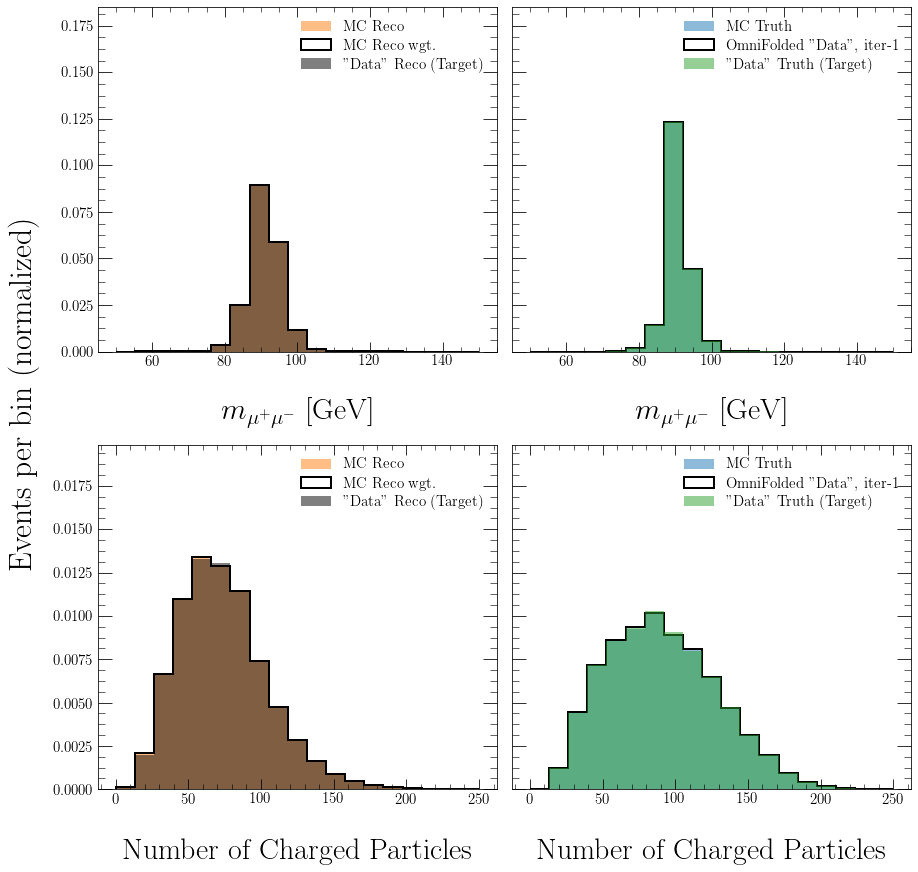

ITERATION: 2


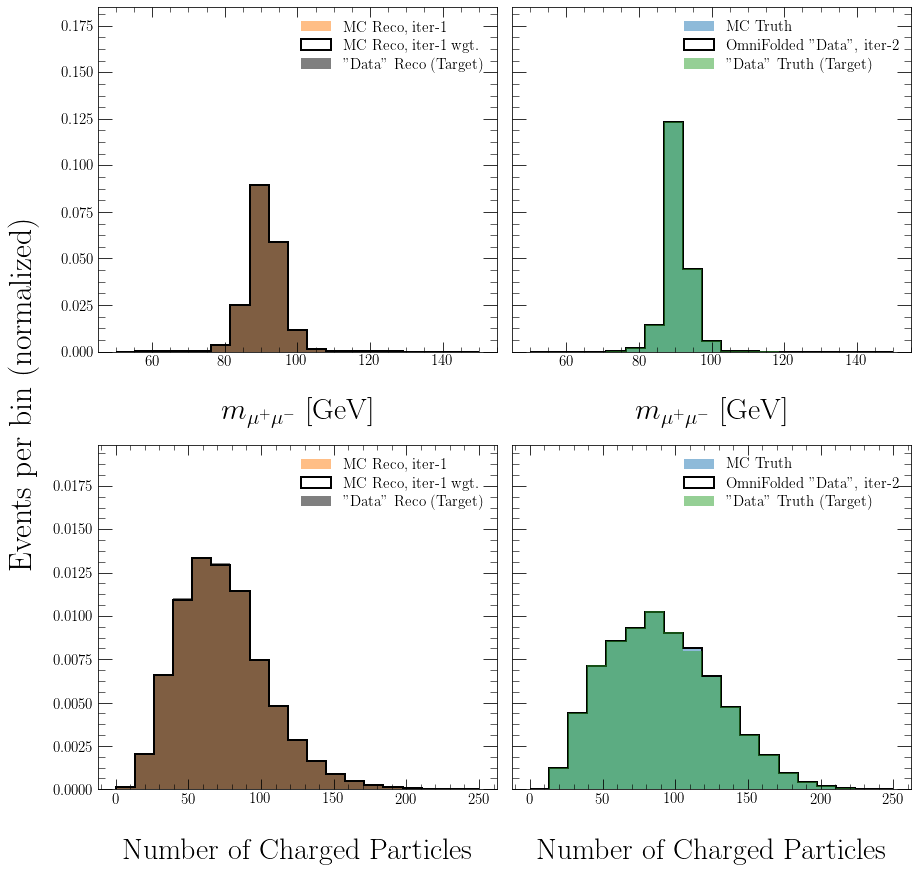

ITERATION: 3


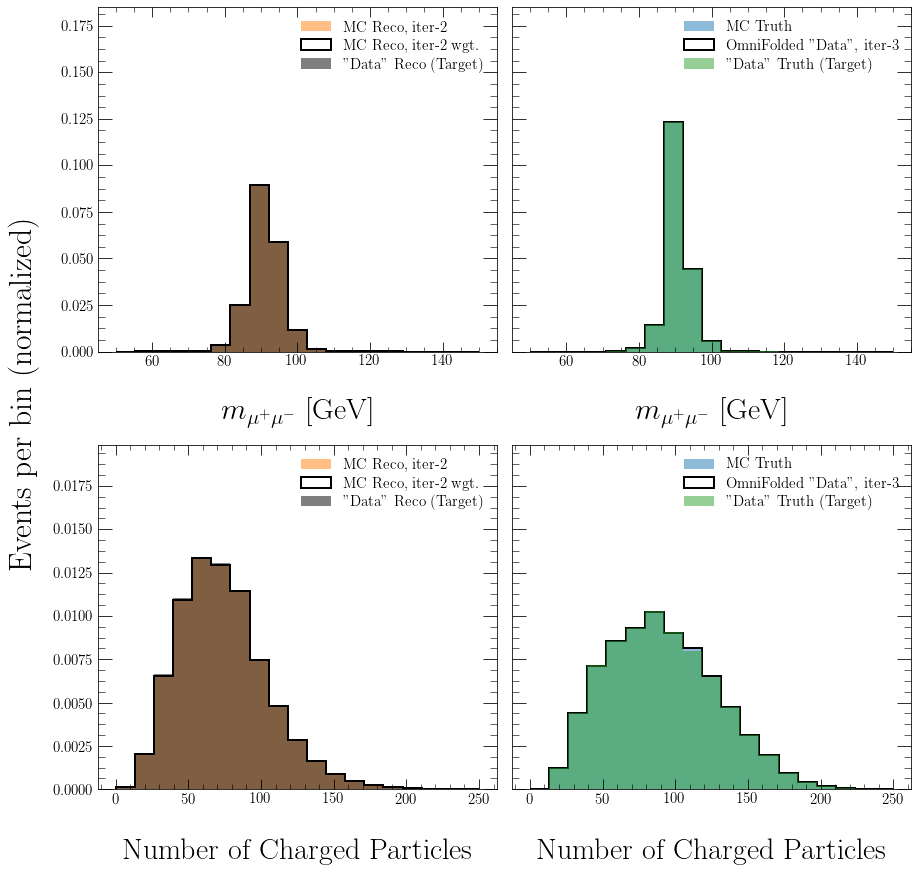

In [35]:
for i in range(len(weights)):
    if i == 0:
        weights_init = np.ones(len(weights[i - 1, 1, :]))
        label0 = ''.format(i)
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(num_observables,
                           2,
                           figsize=(12, 12),
                           constrained_layout=True,
                           sharey='row')

    ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0, 0].hist(m_ll_sim_reco,
                  weights=weights_init,
                  bins=bins,
                  label='MC Reco' + label0,
                  **plot_style_2,
                  color='C1')
    ax[0, 0].hist(m_ll_sim_reco,
                  bins=bins,
                  weights=weights[i, 0, :],
                  label='MC Reco' + label0 + ' wgt.',
                  **plot_style_1)

    hR0, _, _ = ax[0, 0].hist(m_ll_data_reco,
                              bins=bins,
                              label=r'"Data" Reco (Target)',
                              **plot_style_2,
                              color='k')
    ax[0, 0].legend(frameon=False)
    

    ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0, 1].hist(m_ll_sim_truth,
                  bins=bins,
                  label=r'MC Truth',
                  **plot_style_2,
                  color='C0')
    ax[0, 1].hist(m_ll_sim_truth,
                  bins=bins,
                  weights=weights[i, 1, :],
                  label='OmniFolded "Data"' + label1,
                  **plot_style_1)

    hT0, _, _ = ax[0, 1].hist(m_ll_data_truth,
                              bins=bins,
                              label=r'"Data" Truth (Target)',
                              **plot_style_2,
                              color='C2')
    ax[0, 0].set_ylim([0, 1.5 * np.max(np.concatenate((hT0, hR0)))])
    ax[0, 1].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1, 0].set_xlabel('Number of Charged Particles')
    ax[1, 0].hist(nTracks_sim_reco,
                  weights=weights_init,
                  bins=bins,
                  label='MC Reco' + label0,
                  **plot_style_2,
                  color='C1')
    ax[1, 0].hist(nTracks_sim_reco,
                  bins=bins,
                  weights=weights[i, 1, :],
                  label='MC Reco' + label0 + ' wgt.',
                  **plot_style_1)
    hR1, _, _ = ax[1, 0].hist(nTracks_data_reco,
                              bins=bins,
                              label=r'"Data" Reco (Target)',
                              **plot_style_2,
                              color='k')
    ax[1, 0].legend(frameon=False)

    ax[1, 1].set_xlabel('Number of Charged Particles')
    ax[1, 1].hist(nTracks_sim_truth,
                  bins=bins,
                  label=r'MC Truth',
                  **plot_style_2,
                  color='C0')
    ax[1, 1].hist(nTracks_sim_truth,
                  bins=bins,
                  weights=weights[i, 1, :],
                  label='OmniFolded "Data"' + label1,
                  **plot_style_1)
    hT1, _, _ = ax[1, 1].hist(nTracks_data_truth,
                              bins=bins,
                              label=r'"Data" Truth (Target)',
                              **plot_style_2,
                              color='C2')
    ax[1, 1].legend(frameon=False)

    fig.text(-0.05,
             0.55,
             'Events per bin (normalized)',
             va='center',
             rotation='vertical',
             fontsize='x-large')

    ax[1, 0].set_ylim([0, 1.5 * np.max(np.concatenate((hT1, hR1)))])

    #     fig.savefig(
    #         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-TechnicalClosureTest-MultiFold-Iteration{:02}.pdf'
    #         .format(i + 1),
    #         bbox_inches='tight')
    fig.show()
    plt.show()

# Stress Test A

Stress weights are nonrandom.

For each observable $x$ in the "unknown" sample, the weight is given roughly by $w \propto x^n$ for some $n$.

## UniFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles separately.

### Setup Datasets

In [36]:
m_ll_sim_truth, m_ll_data_truth, m_ll_sim_reco, m_ll_data_reco = train_test_split(Events_0.events['truth_m_ll'][mypass_0],
                                                                      Events_0.events['m_ll'][mypass_0], 
                                                                      test_size=0.5)

In [37]:
scaler_m_ll = preprocessing.StandardScaler()

scaler_m_ll.fit(np.concatenate((m_ll_sim_truth, m_ll_data_truth)).reshape(-1,1))

weight_m_ll_seed = np.squeeze(scaler_m_ll.transform(m_ll_data_truth.reshape(-1,1)))

In [38]:
weights_m_ll_stress = -np.min(weight_m_ll_seed) + weight_m_ll_seed
weights_m_ll_stress = (weights_m_ll_stress)**2
weights_m_ll_stress = weights_m_ll_stress/np.mean(weights_m_ll_stress)

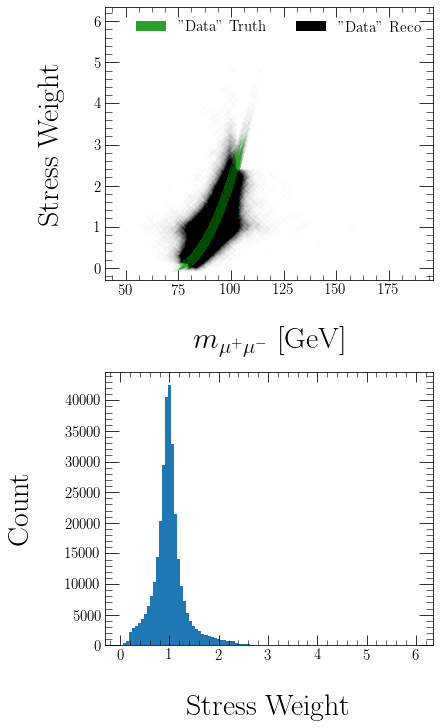

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10), constrained_layout=True)

ax[0].plot(m_ll_data_reco,
           weights_m_ll_stress,
           'x',
           alpha=0.01,
           label='Data',
           color='k')
ax[0].plot(m_ll_data_truth,
           weights_m_ll_stress,
           'x',
           alpha=0.01,
           label='Truth',
           color='C2')

ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Stress Weight')
handles = [Patch(facecolor='C2'), Patch(facecolor='k')]
labels = ['"Data" Truth', '"Data" Reco']
ax[0].legend(handles, labels, ncol=2)

ax[1].hist(weights_m_ll_stress,
           bins=np.linspace(np.min(weights_m_ll_stress),
                            np.max(weights_m_ll_stress), 100))
ax[1].set_xlabel('Stress Weight')
ax[1].set_ylabel('Count')

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-UniFold-m_ll-StressWeights.png',
#     bbox_inches='tight')

fig.show()

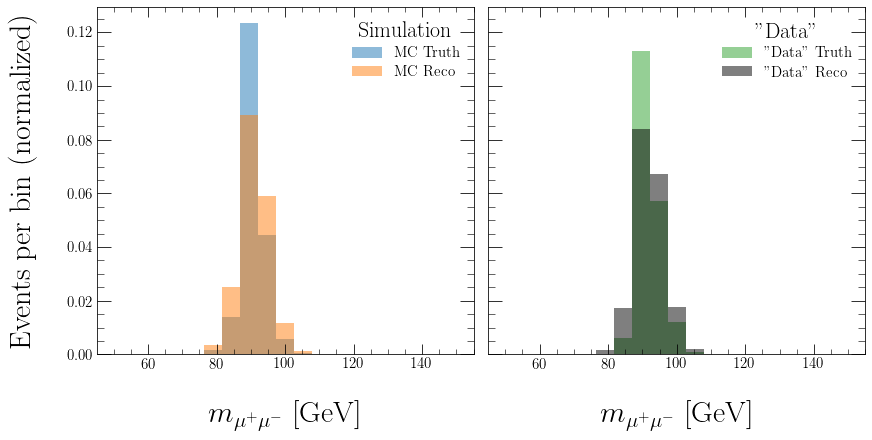

In [40]:
bins = np.linspace(50, 150, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Events per bin (normalized)')
hG0, _, _ = ax[0].hist(m_ll_sim_truth,
                       bins=bins,
                       label='MC Truth',
                       **plot_style_2,
                       color='C0')
hS0, _, _ = ax[0].hist(m_ll_sim_reco,
                       bins=bins,
                       label='MC Reco',
                       **plot_style_2,
                       color='C1')
legend = ax[0].legend(title='Simulation', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[1].hist(m_ll_data_truth,
                       weights=weights_m_ll_stress,
                       bins=bins,
                       label='"Data" Truth',
                       **plot_style_2,
                       color='C2')
hS1, _, _ = ax[1].hist(m_ll_data_reco,
                       weights=weights_m_ll_stress,
                       bins=bins,
                       label='"Data" Reco',
                       **plot_style_2,
                       color='k')
legend = ax[1].legend(title='"Data"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-UniFold-m_ll-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

In [41]:
nTracks_sim_truth, nTracks_data_truth, nTracks_sim_reco, nTracks_data_reco = train_test_split(
    np.array(ntrack_sim_truth), np.array(ntrack_sim_reco), test_size=0.5)

In [42]:
scaler_nTracks = preprocessing.StandardScaler()

scaler_nTracks.fit(np.concatenate((nTracks_sim_truth, nTracks_data_truth)).reshape(-1,1))

weight_nTracks_seed = np.squeeze(scaler_nTracks.transform(nTracks_data_truth.reshape(-1,1)))

In [43]:
weights_nTracks_stress = -np.min(weight_nTracks_seed) + weight_nTracks_seed
weights_nTracks_stress = (weights_nTracks_stress)**2
weights_nTracks_stress = weights_nTracks_stress/np.mean(weights_nTracks_stress)

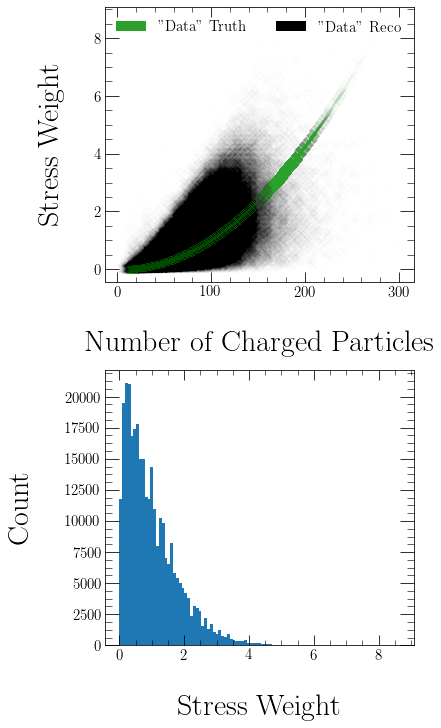

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10), constrained_layout=True)

ax[0].plot(nTracks_data_reco, weights_nTracks_stress,
           'x',
           alpha=0.01,
           label='Data',
           color='k')
ax[0].plot(nTracks_data_truth, weights_nTracks_stress,
           'x',
           alpha=0.01,
           label='Truth',
           color='C2')

ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Stress Weight')
handles = [Patch(facecolor='C2'), Patch(facecolor='k')]
labels = ['"Data" Truth', '"Data" Reco']
ax[0].legend(handles, labels, ncol=2)

ax[1].hist(weights_nTracks_stress,
           bins=np.linspace(np.min(weights_nTracks_stress),
                            np.max(weights_nTracks_stress), 100))
ax[1].set_xlabel('Stress Weight')
ax[1].set_ylabel('Count')

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-UniFold-nTracks-StressWeights.png',
#     bbox_inches='tight')

fig.show()

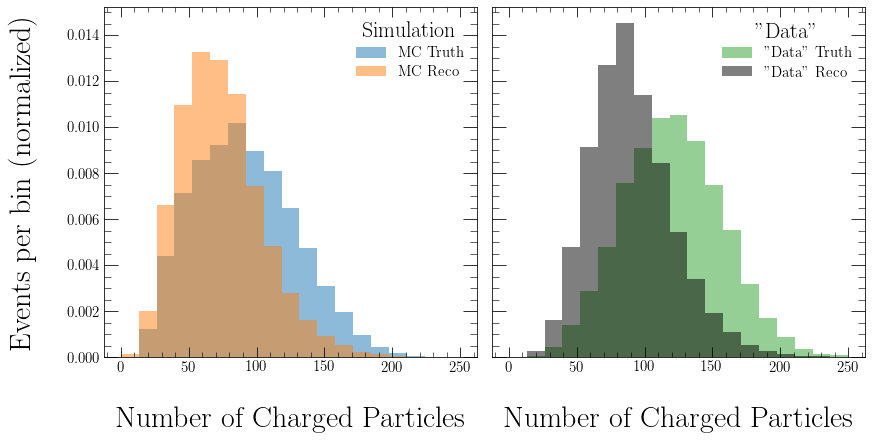

In [45]:
bins = np.linspace(0, 250, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Events per bin (normalized)')
hG0, _, _ = ax[0].hist(nTracks_sim_truth,
                       bins=bins,
                       label='MC Truth',
                       **plot_style_2,
                       color='C0')
hS0, _, _ = ax[0].hist(nTracks_sim_reco,
                       bins=bins,
                       label='MC Reco',
                       **plot_style_2,
                       color='C1')
legend = ax[0].legend(title='Simulation', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1].hist(nTracks_data_truth,
                       weights=weights_nTracks_stress,
                       bins=bins,
                       label='"Data" Truth',
                       **plot_style_2,
                       color='C2')
hS1, _, _ = ax[1].hist(nTracks_data_reco,
                       weights=weights_nTracks_stress,
                       bins=bins,
                       label='"Data" Reco',
                       **plot_style_2,
                       color='k')
legend = ax[1].legend(title='"Data"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-UniFold-nTracks-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

### Unfold $m_{\mu^+\mu^-}$

In [46]:
# z-score standardization

scaler_truth = preprocessing.StandardScaler()
scaler_reco = preprocessing.StandardScaler()

scaler_truth.fit(m_ll_sim_truth.reshape(-1,1))
scaler_reco.fit(np.concatenate((m_ll_sim_reco, m_ll_data_reco)).reshape(-1,1))

sim_truth = np.squeeze(scaler_truth.transform(m_ll_sim_truth.reshape(-1,1)))
sim_reco = np.squeeze(scaler_reco.transform(m_ll_sim_reco.reshape(-1,1)))
data_reco = np.squeeze(scaler_reco.transform(m_ll_data_reco.reshape(-1,1)))

In [47]:
weights, _ = unifold(iterations=10,
                     sim_truth=sim_truth,
                     sim_reco=sim_reco,
                     data_reco=data_reco,
                     weights_MC_data=weights_m_ll_stress)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 7s 14us/step - loss: 0.6876 - acc: 0.5003 - val_loss: 0.6870 - val_acc: 0.4988
Epoch 2/200
466582/466582 [==============================] - 5s 12us/step - loss: 0.6867 - acc: 0.5009 - val_loss: 0.6870 - val_acc: 0.4990
Epoch 3/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6867 - acc: 0.5008 - val_loss: 0.6869 - val_acc: 0.4992
Epoch 4/200
466582/466582 [==============================] - 4s 9us/step - loss: 0.6867 - acc: 0.5008 - val_loss: 0.6869 - val_acc: 0.4990
Epoch 5/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6867 - acc: 0.5008 - val_loss: 0.6869 - val_acc: 0.4984
Epoch 6/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6866 - acc: 0.5008 - val_loss: 0.6869 - val_acc: 0.4986
Epoch 7/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.68

466582/466582 [==============================] - 5s 11us/step - loss: 0.6921 - acc: 0.5001 - val_loss: 0.6920 - val_acc: 0.5001
Epoch 4/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6921 - acc: 0.5003 - val_loss: 0.6920 - val_acc: 0.4999
Epoch 5/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6920 - acc: 0.5005 - val_loss: 0.6920 - val_acc: 0.4995
Epoch 6/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6920 - acc: 0.5007 - val_loss: 0.6920 - val_acc: 0.4994
Epoch 7/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6920 - acc: 0.5008 - val_loss: 0.6920 - val_acc: 0.4990
Epoch 8/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6921 - acc: 0.5006 - val_loss: 0.6920 - val_acc: 0.4995
Epoch 9/200
466582/466582 [==============================] - 5s 12us/step - loss: 0.6920 - acc: 0.5007 - val_loss: 0.6920 - val_acc: 0.4990
Epoch 10/200
466582/466582 [====

466582/466582 [==============================] - 5s 10us/step - loss: 0.6828 - acc: 0.5006 - val_loss: 0.6833 - val_acc: 0.4977
Epoch 18/200
466582/466582 [==============================] - 4s 9us/step - loss: 0.6828 - acc: 0.5008 - val_loss: 0.6833 - val_acc: 0.4980
Epoch 19/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6828 - acc: 0.5008 - val_loss: 0.6833 - val_acc: 0.4977
Epoch 20/200
466582/466582 [==============================] - 4s 10us/step - loss: 0.6828 - acc: 0.5009 - val_loss: 0.6833 - val_acc: 0.4977
Epoch 21/200
466582/466582 [==============================] - 4s 9us/step - loss: 0.6827 - acc: 0.5008 - val_loss: 0.6832 - val_acc: 0.4974
Restoring model weights from the end of the best epoch
Epoch 00021: early stopping

ITERATION: 4

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 7s 14us/step - loss: 0.6922 - acc: 0.5000 - val_loss: 0.6909 - val_acc: 0.4989
Epoch 2/200
4

466582/466582 [==============================] - 5s 11us/step - loss: 0.6781 - acc: 0.5002 - val_loss: 0.6787 - val_acc: 0.4990
Restoring model weights from the end of the best epoch
Epoch 00015: early stopping

ITERATION: 6

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 7s 15us/step - loss: 0.6933 - acc: 0.4992 - val_loss: 0.6904 - val_acc: 0.5003
Epoch 2/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6910 - acc: 0.5004 - val_loss: 0.6903 - val_acc: 0.4995
Epoch 3/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6910 - acc: 0.5002 - val_loss: 0.6903 - val_acc: 0.4996
Epoch 4/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6910 - acc: 0.5009 - val_loss: 0.6904 - val_acc: 0.4992
Epoch 5/200
466582/466582 [==============================] - 5s 12us/step - loss: 0.6910 - acc: 0.4999 - val_loss: 0.6904 - val_acc: 0.4995
Epoch 6/200
46


ITERATION: 8

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 6s 12us/step - loss: 0.6934 - acc: 0.4992 - val_loss: 0.6919 - val_acc: 0.5010
Epoch 2/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6910 - acc: 0.4999 - val_loss: 0.6919 - val_acc: 0.4999
Epoch 3/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6910 - acc: 0.5005 - val_loss: 0.6919 - val_acc: 0.5021
Epoch 4/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6910 - acc: 0.5002 - val_loss: 0.6919 - val_acc: 0.5010
Epoch 5/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6910 - acc: 0.5004 - val_loss: 0.6919 - val_acc: 0.5000
Epoch 6/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6910 - acc: 0.4999 - val_loss: 0.6919 - val_acc: 0.5000
Epoch 7/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6910 - 

466582/466582 [==============================] - 3s 6us/step - loss: 0.6808 - acc: 0.5002 - val_loss: 0.6812 - val_acc: 0.4992
Epoch 13/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6809 - acc: 0.5003 - val_loss: 0.6812 - val_acc: 0.4990
Epoch 14/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6809 - acc: 0.5002 - val_loss: 0.6812 - val_acc: 0.4990
Restoring model weights from the end of the best epoch
Epoch 00014: early stopping

ITERATION: 10

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 6s 13us/step - loss: 0.6979 - acc: 0.4999 - val_loss: 0.6958 - val_acc: 0.4994
Epoch 2/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6954 - acc: 0.5004 - val_loss: 0.6958 - val_acc: 0.5016
Epoch 3/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6954 - acc: 0.4994 - val_loss: 0.6958 - val_acc: 0.4997
Epoch 4/200
4665

#### Results 

ITERATION 1:


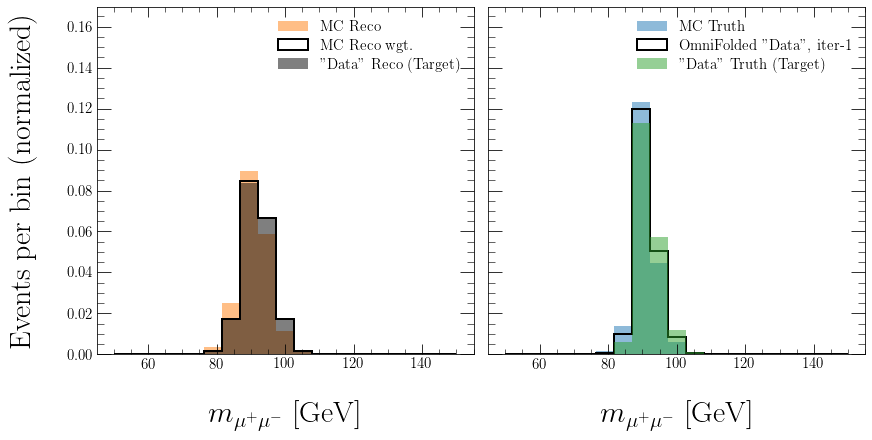

ITERATION 2:


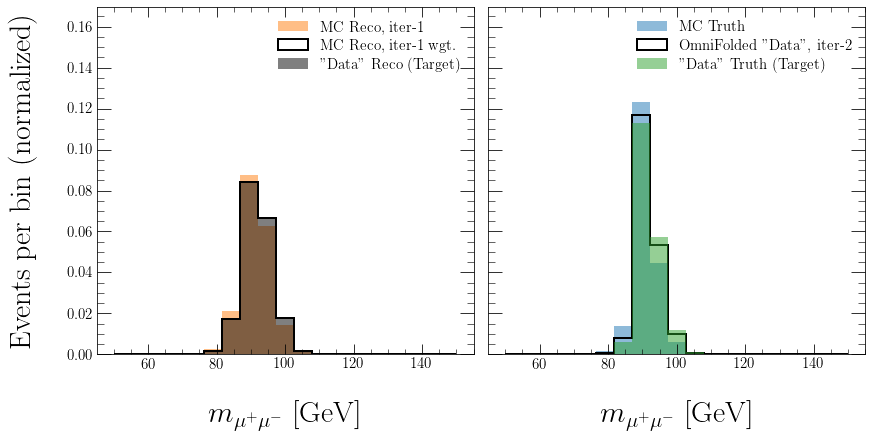

ITERATION 3:


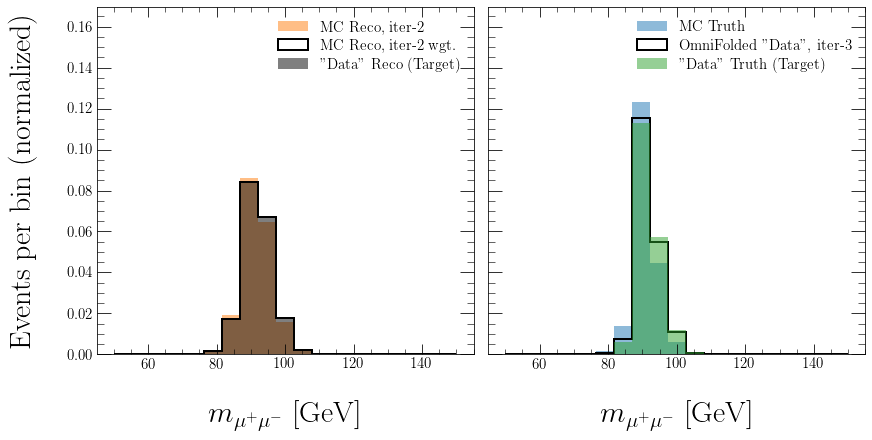

ITERATION 4:


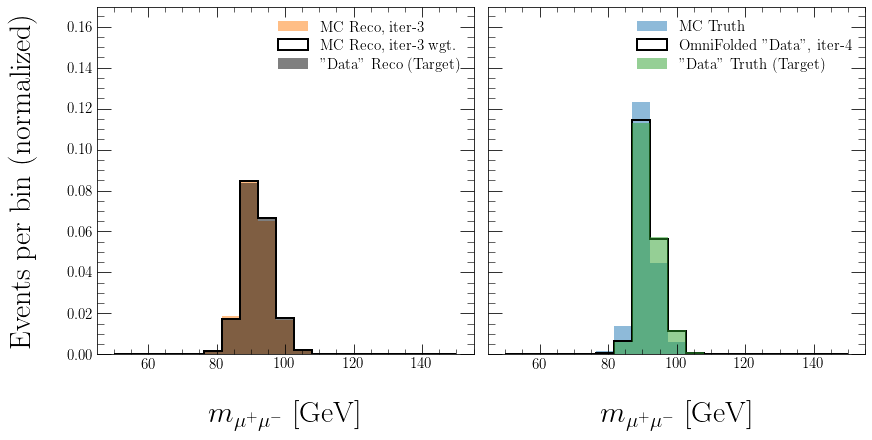

ITERATION 5:


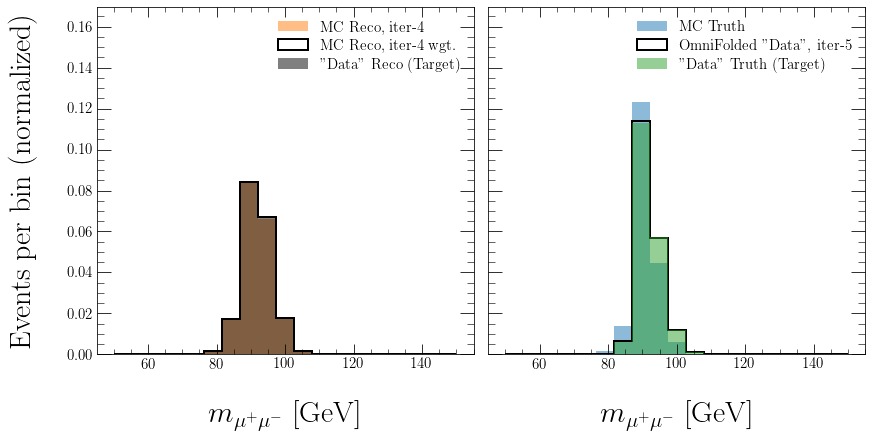

ITERATION 6:


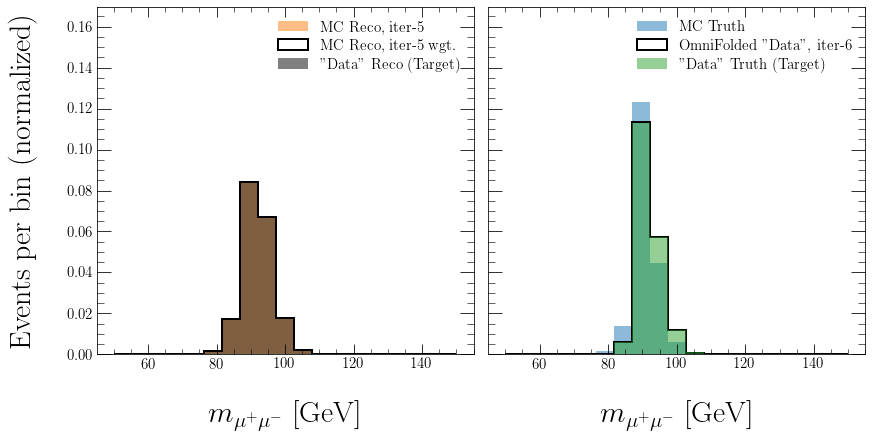

ITERATION 7:


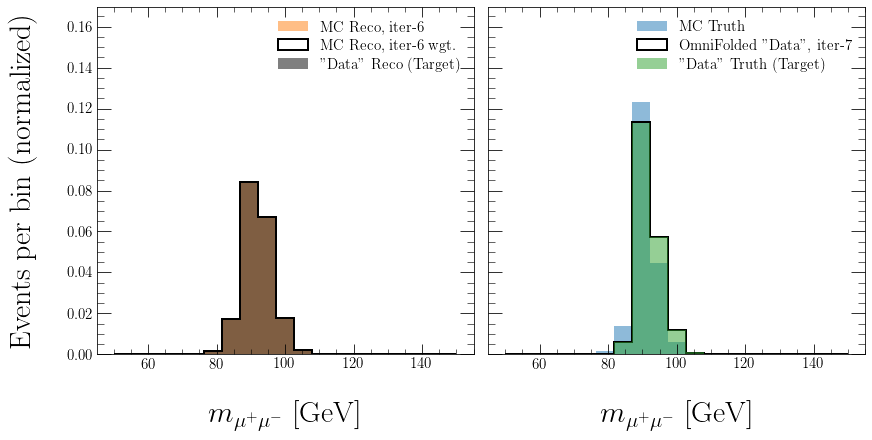

ITERATION 8:


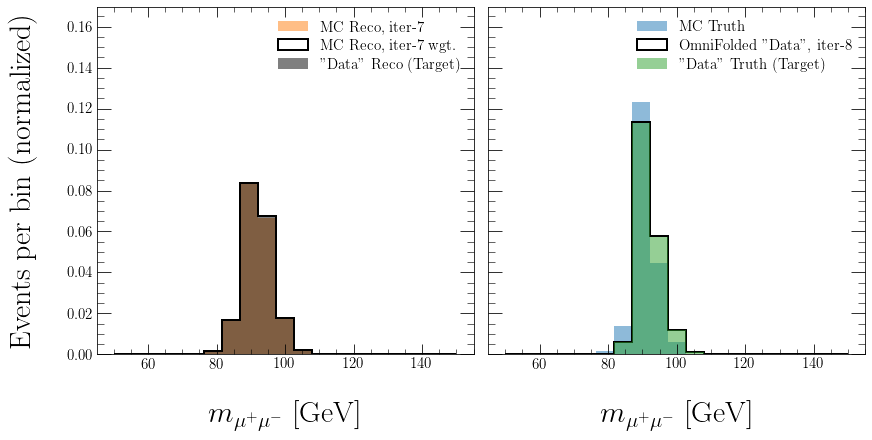

ITERATION 9:


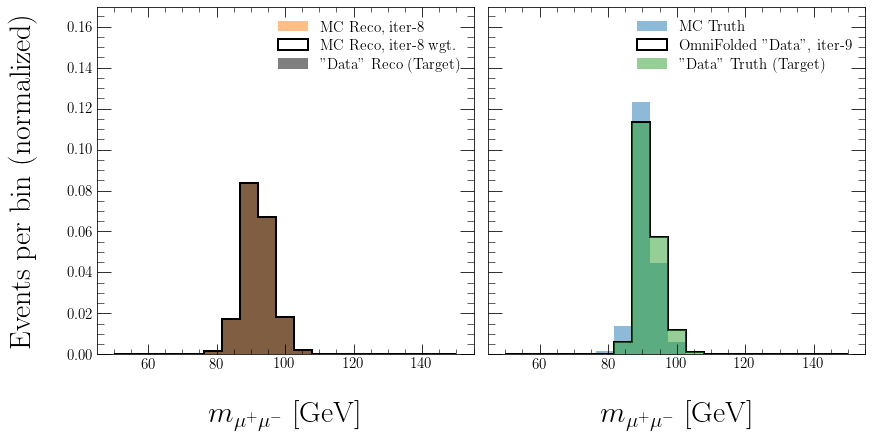

ITERATION 10:


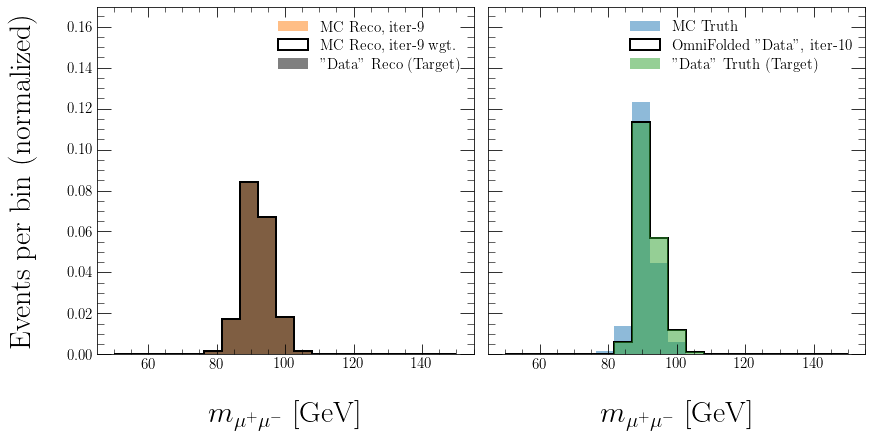

In [48]:
bins = np.linspace(50, 150, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(m_ll_sim_reco))
        label0 = ''
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    ax[0].hist(m_ll_sim_reco,
               weights=weights_init,
               bins=bins,
               label='MC Reco' + label0,
               **plot_style_2,
               color='C1')

    ax[0].hist(m_ll_sim_reco,
               bins=bins,
               label='MC Reco' + label0 + ' wgt.',
               weights=weights[i, 0, :],
               **plot_style_1)
    hR, _, _ = ax[0].hist(m_ll_data_reco,
                          weights=weights_m_ll_stress,
                          bins=bins,
                          label='"Data" Reco (Target)',
                          **plot_style_2,
                          color='k')
    ax[0].set_xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend()
    ax[1].hist(m_ll_sim_truth, bins=bins, label=r'MC Truth', **plot_style_2)

    ax[1].hist(m_ll_sim_truth,
               bins=bins,
               label='OmniFolded "Data"' + label1,
               weights=weights[i, 1, :],
               **plot_style_1)
    hT, _, _ = ax[1].hist(m_ll_data_truth,
                          weights=weights_m_ll_stress,
                          bins=bins,
                          label='"Data" Truth (Target)',
                          **plot_style_2,
                          color='C2')
    ax[1].legend()
    ax[1].set_xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")

    plt.ylim([0, 1.5 * max(max(hT), max(hR))])
    fig.show()
#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-UniFold-m_ll-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    plt.show()

### Unfold Number of Charged Particles

In [49]:
# z-score standardization

scaler_truth = preprocessing.StandardScaler()
scaler_reco = preprocessing.StandardScaler()

scaler_truth.fit(nTracks_sim_truth.reshape(-1,1))
scaler_reco.fit(np.concatenate((nTracks_sim_reco, nTracks_data_reco)).reshape(-1,1))

sim_truth = np.squeeze(scaler_truth.transform(nTracks_sim_truth.reshape(-1,1)))
sim_reco = np.squeeze(scaler_reco.transform(nTracks_sim_reco.reshape(-1,1)))
data_reco = np.squeeze(scaler_reco.transform(nTracks_data_reco.reshape(-1,1)))

In [50]:
weights, _ = unifold(iterations=10,
                     sim_truth=sim_truth,
                     sim_reco=sim_reco,
                     data_reco=data_reco,
                     weights_MC_data=weights_nTracks_stress)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 6s 14us/step - loss: 0.6662 - acc: 0.4995 - val_loss: 0.6526 - val_acc: 0.4992
Epoch 2/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6514 - acc: 0.4997 - val_loss: 0.6513 - val_acc: 0.4993
Epoch 3/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6510 - acc: 0.4999 - val_loss: 0.6511 - val_acc: 0.4994
Epoch 4/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6508 - acc: 0.4999 - val_loss: 0.6509 - val_acc: 0.4991
Epoch 5/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6507 - acc: 0.5000 - val_loss: 0.6509 - val_acc: 0.4993
Epoch 6/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6507 - acc: 0.4997 - val_loss: 0.6509 - val_acc: 0.4993
Epoch 7/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6507 - 

Epoch 2/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6459 - acc: 0.4996 - val_loss: 0.6462 - val_acc: 0.5013
Epoch 3/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6460 - acc: 0.4995 - val_loss: 0.6462 - val_acc: 0.5013
Epoch 4/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6459 - acc: 0.4994 - val_loss: 0.6463 - val_acc: 0.5016
Epoch 5/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6459 - acc: 0.4997 - val_loss: 0.6462 - val_acc: 0.5013
Epoch 6/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6459 - acc: 0.4996 - val_loss: 0.6463 - val_acc: 0.5013
Epoch 7/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6459 - acc: 0.4995 - val_loss: 0.6462 - val_acc: 0.5012
Epoch 8/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6459 - acc: 0.4996 - val_loss: 0.6463 - val_acc: 0.5011
Epoch 9/200
466582/466582 [

466582/466582 [==============================] - 3s 6us/step - loss: 0.6907 - acc: 0.4994 - val_loss: 0.6918 - val_acc: 0.4990
Epoch 12/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6907 - acc: 0.4992 - val_loss: 0.6918 - val_acc: 0.4993
Epoch 13/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6908 - acc: 0.4997 - val_loss: 0.6918 - val_acc: 0.4985
Epoch 14/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6907 - acc: 0.4997 - val_loss: 0.6918 - val_acc: 0.4998
Epoch 15/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6908 - acc: 0.4987 - val_loss: 0.6918 - val_acc: 0.4993
Epoch 16/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6907 - acc: 0.4992 - val_loss: 0.6918 - val_acc: 0.4991
Epoch 17/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6907 - acc: 0.4994 - val_loss: 0.6918 - val_acc: 0.4994
Epoch 18/200
466582/466582 [=====

466582/466582 [==============================] - 3s 6us/step - loss: 0.6247 - acc: 0.5000 - val_loss: 0.6231 - val_acc: 0.5000
Epoch 16/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6247 - acc: 0.4999 - val_loss: 0.6233 - val_acc: 0.4999
Epoch 17/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6247 - acc: 0.5000 - val_loss: 0.6231 - val_acc: 0.5000
Epoch 18/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6247 - acc: 0.5000 - val_loss: 0.6231 - val_acc: 0.5001
Restoring model weights from the end of the best epoch
Epoch 00018: early stopping

ITERATION: 6

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 6s 13us/step - loss: 0.7127 - acc: 0.4993 - val_loss: 0.6995 - val_acc: 0.4999
Epoch 2/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6993 - acc: 0.4995 - val_loss: 0.6994 - val_acc: 0.5001
Epoch 3/200
4665

466582/466582 [==============================] - 3s 6us/step - loss: 0.6194 - acc: 0.4997 - val_loss: 0.6192 - val_acc: 0.5007
Epoch 3/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6193 - acc: 0.4998 - val_loss: 0.6193 - val_acc: 0.5005
Epoch 4/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6193 - acc: 0.4998 - val_loss: 0.6192 - val_acc: 0.5004
Epoch 5/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6192 - acc: 0.4999 - val_loss: 0.6192 - val_acc: 0.5004
Epoch 6/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6192 - acc: 0.4998 - val_loss: 0.6192 - val_acc: 0.5004
Epoch 7/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6193 - acc: 0.4998 - val_loss: 0.6192 - val_acc: 0.5004
Epoch 8/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6193 - acc: 0.4999 - val_loss: 0.6192 - val_acc: 0.5004
Epoch 9/200
466582/466582 [============

466582/466582 [==============================] - 3s 7us/step - loss: 0.6897 - acc: 0.5003 - val_loss: 0.6898 - val_acc: 0.5003
Epoch 11/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6897 - acc: 0.4998 - val_loss: 0.6898 - val_acc: 0.5007
Epoch 12/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6897 - acc: 0.4998 - val_loss: 0.6898 - val_acc: 0.5005
Epoch 13/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6897 - acc: 0.5001 - val_loss: 0.6898 - val_acc: 0.5002
Epoch 14/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6897 - acc: 0.5000 - val_loss: 0.6898 - val_acc: 0.5012
Epoch 15/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6896 - acc: 0.5008 - val_loss: 0.6898 - val_acc: 0.5003
Epoch 16/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6897 - acc: 0.5002 - val_loss: 0.6898 - val_acc: 0.5008
Epoch 17/200
466582/466582 [=====

466582/466582 [==============================] - 4s 8us/step - loss: 0.6958 - acc: 0.4991 - val_loss: 0.6965 - val_acc: 0.4986
Epoch 26/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6958 - acc: 0.5014 - val_loss: 0.6965 - val_acc: 0.4989
Epoch 27/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6957 - acc: 0.5001 - val_loss: 0.6965 - val_acc: 0.4986
Epoch 28/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6957 - acc: 0.5009 - val_loss: 0.6965 - val_acc: 0.5022
Epoch 29/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6958 - acc: 0.5003 - val_loss: 0.6965 - val_acc: 0.4986
Epoch 30/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6957 - acc: 0.5006 - val_loss: 0.6965 - val_acc: 0.5011
Epoch 31/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6957 - acc: 0.5005 - val_loss: 0.6965 - val_acc: 0.4994
Epoch 32/200
466582/466582 [=====

#### Results

ITERATION 1:


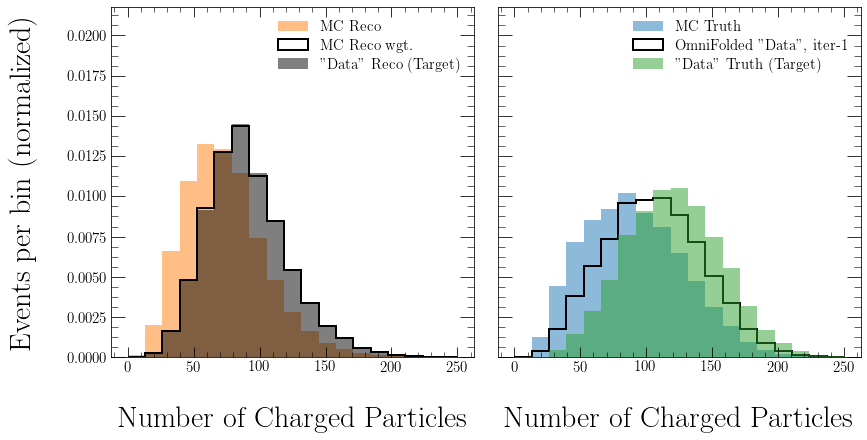

ITERATION 2:


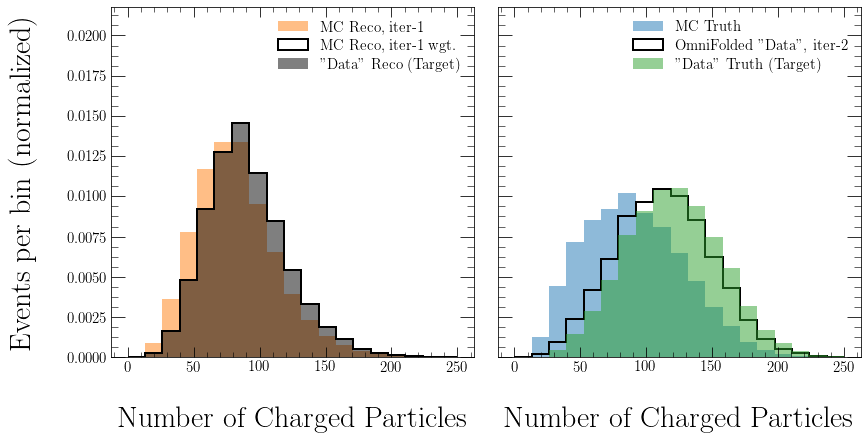

ITERATION 3:


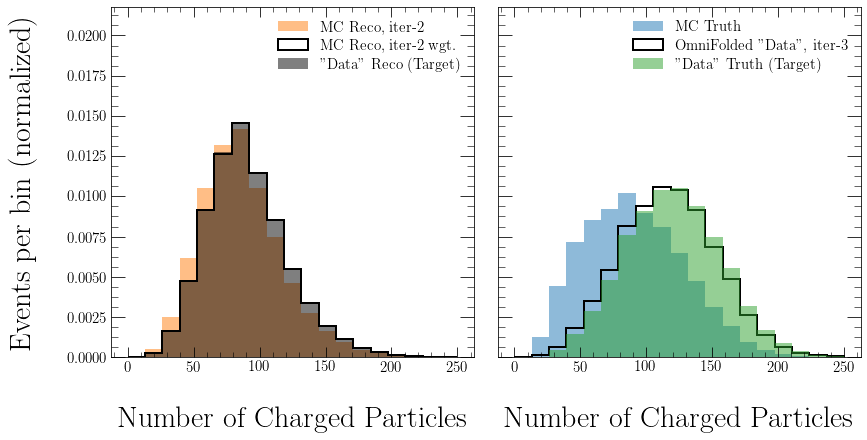

ITERATION 4:


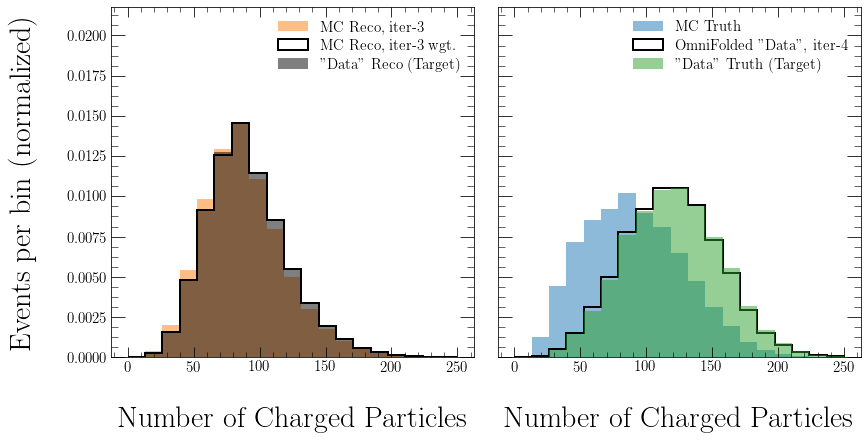

ITERATION 5:


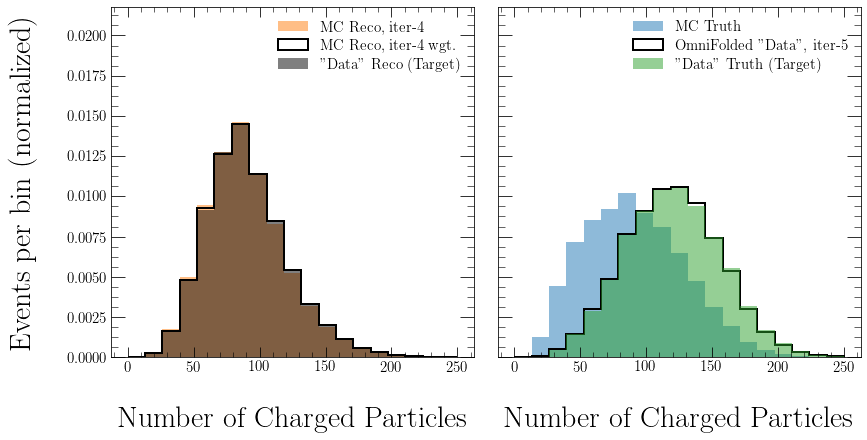

ITERATION 6:


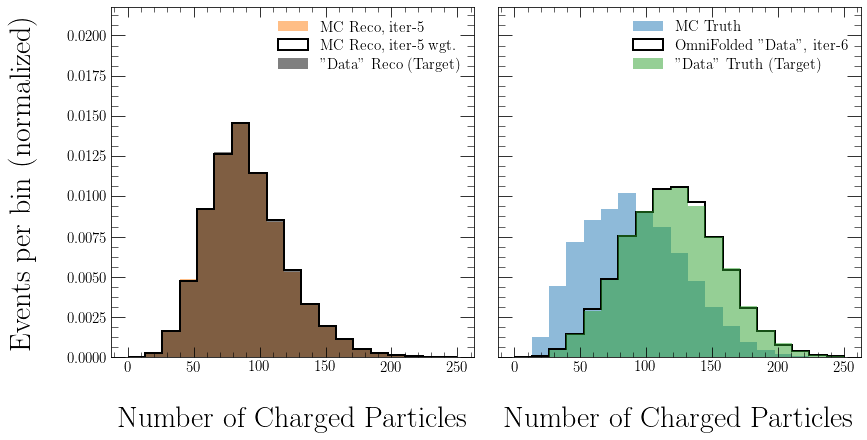

ITERATION 7:


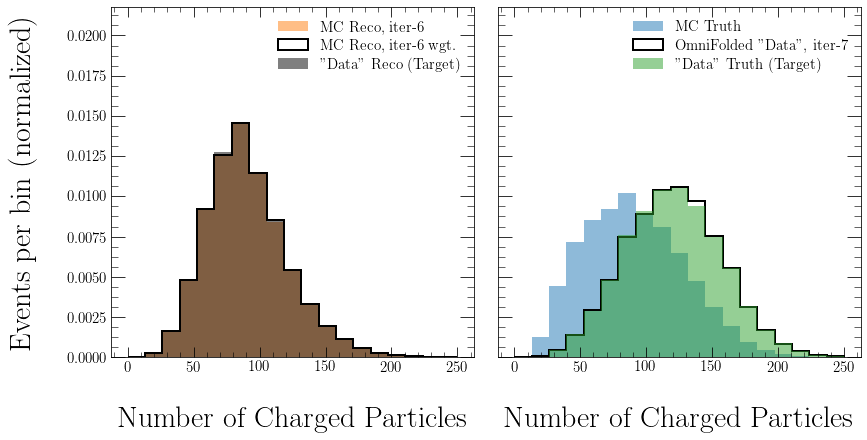

ITERATION 8:


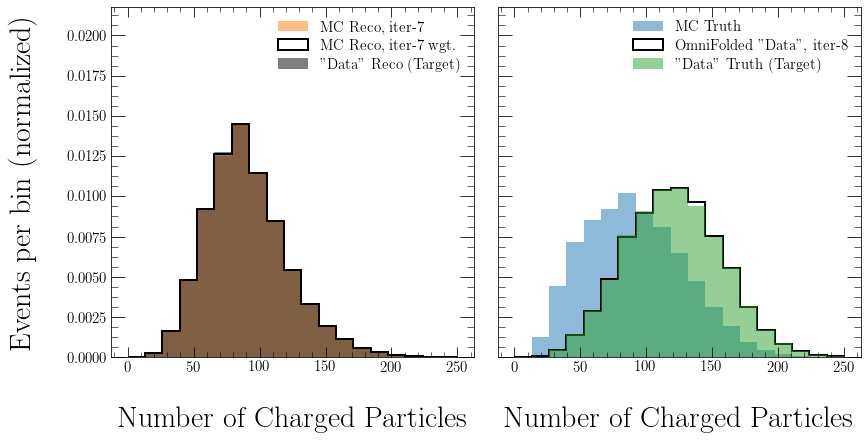

ITERATION 9:


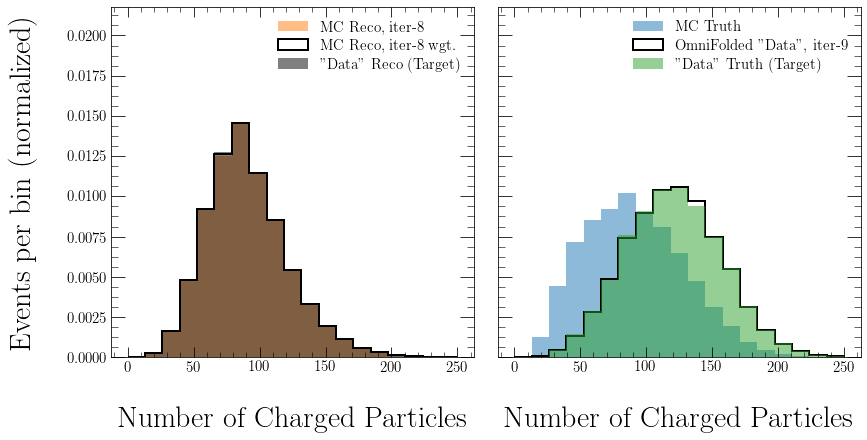

ITERATION 10:


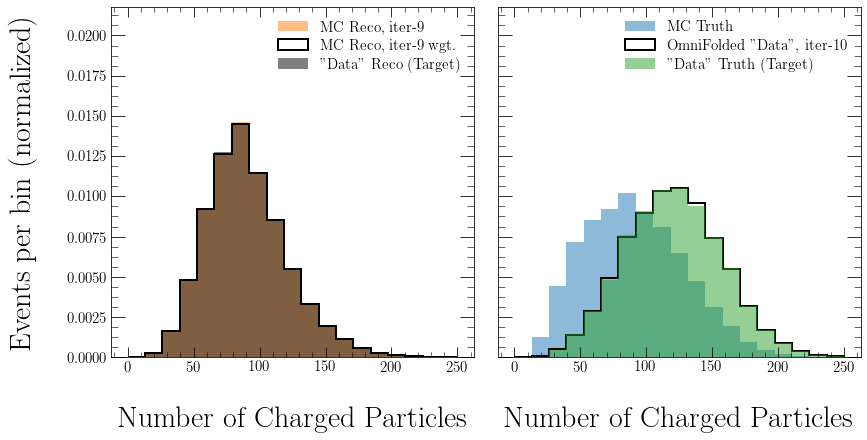

In [51]:
bins = np.linspace(0, 250, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(nTracks_sim_reco))
        label0 = ''
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    ax[0].hist(nTracks_sim_reco,
               weights=weights_init,
               bins=bins,
               label='MC Reco' + label0,
               **plot_style_2,
               color='C1')

    ax[0].hist(nTracks_sim_reco,
               bins=bins,
               label='MC Reco' + label0 + ' wgt.',
               weights=weights[i, 0, :],
               **plot_style_1)
    hR, _, _ = ax[0].hist(nTracks_data_reco,
                          weights=weights_nTracks_stress,
                          bins=bins,
                          label='"Data" Reco (Target)',
                          **plot_style_2,
                          color='k')
    ax[0].set_xlabel(r"Number of Charged Particles")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend()
    ax[1].hist(nTracks_sim_truth, bins=bins, label=r'MC Truth', **plot_style_2)

    ax[1].hist(nTracks_sim_truth,
               bins=bins,
               label='OmniFolded "Data"' + label1,
               weights=weights[i, 1, :],
               **plot_style_1)
    hT, _, _ = ax[1].hist(nTracks_data_truth,
                          weights=weights_nTracks_stress,
                          bins=bins,
                          label='"Data" Truth (Target)',
                          **plot_style_2,
                          color='C2')
    ax[1].legend()
    ax[1].set_xlabel(r"Number of Charged Particles")

    plt.ylim([0, 1.5 * max(max(hT), max(hR))])
    fig.show()
#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-UniFold-nTracks-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    plt.show()

## Multifold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles simultaneously.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

In [52]:
K.clear_session()

### Setup datasets

In [53]:
m_ll_sim_truth, m_ll_data_truth, m_ll_sim_reco, m_ll_data_reco, nTracks_sim_truth, nTracks_data_truth, nTracks_sim_reco, nTracks_data_reco = train_test_split(
    Events_0.events['truth_m_ll'][mypass_0],
    Events_0.events['m_ll'][mypass_0],
    np.array(ntrack_sim_truth),
    np.array(ntrack_sim_reco),
    test_size=0.5)

In [54]:
scaler_m_ll = preprocessing.StandardScaler()
scaler_m_ll.fit(np.concatenate((m_ll_sim_truth, m_ll_data_truth)).reshape(-1,1))

scaler_nTracks = preprocessing.StandardScaler()
scaler_nTracks.fit(np.concatenate((nTracks_sim_truth, nTracks_data_truth)).reshape(-1,1))

weight_m_ll_seed = np.squeeze(scaler_m_ll.transform(m_ll_data_truth.reshape(-1,1)))
weight_nTracks_seed = np.squeeze(scaler_nTracks.transform(nTracks_data_truth.reshape(-1,1)))

weight_seed = weight_m_ll_seed + weight_nTracks_seed

In [55]:
weights_stress = -np.min(weight_seed) + weight_seed
weights_stress = (weights_stress)**3
weights_stress = weights_stress/np.mean(weights_stress)

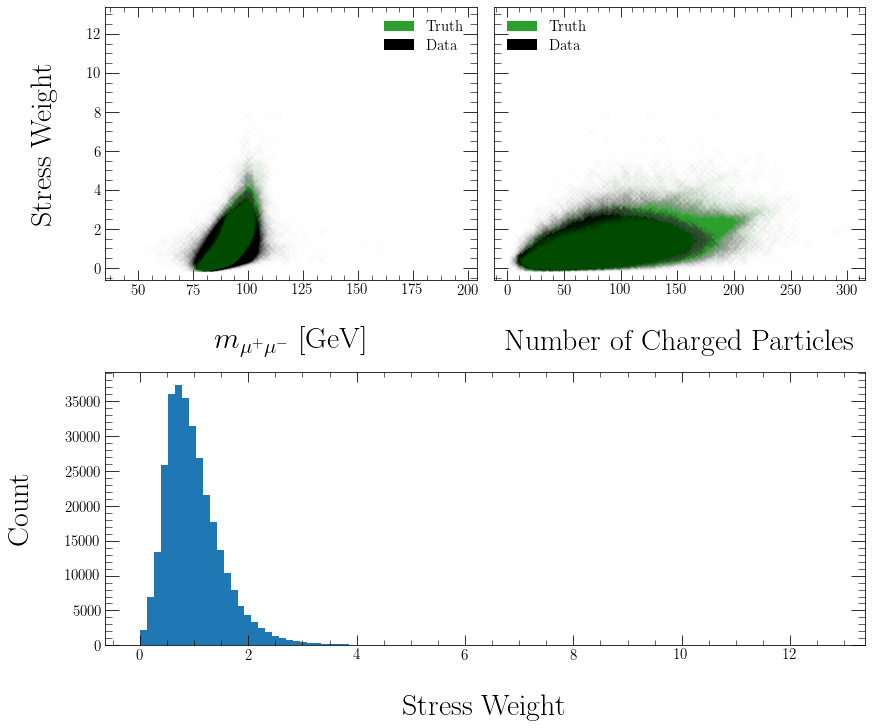

In [56]:
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(m_ll_data_reco,
         weights_stress,
         'x',
         alpha=0.01,
         color='k',
         label='Data')
ax0.plot(m_ll_data_truth,
         weights_stress,
         'x',
         alpha=0.01,
         color='C2',
         label='Truth')
ax0.set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax0.set_ylabel('Stress Weight')

ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
plt.setp(ax1.get_yticklabels(), visible=False)
ax1.plot(nTracks_data_reco,
         weights_stress,
         'x',
         alpha=0.01,
         color='k',
         label='Data')
ax1.plot(nTracks_data_truth,
         weights_stress,
         'x',
         alpha=0.01,
         color='C2',
         label='Truth')
ax1.set_xlabel('Number of Charged Particles')

handles = [Patch(facecolor='C2'), Patch(facecolor='k')]
labels = ['Truth', 'Data']
ax0.legend(handles, labels)
ax1.legend(handles, labels)

ax2 = fig.add_subplot(gs[1, :])
ax2.hist(weights_stress,
         bins=np.linspace(np.min(weights_stress), np.max(weights_stress), 100))
ax2.set_xlabel('Stress Weight')
ax2.set_ylabel('Count')

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-MultiFold-StressWeights.png',
#     bbox_inches='tight')

fig.show()

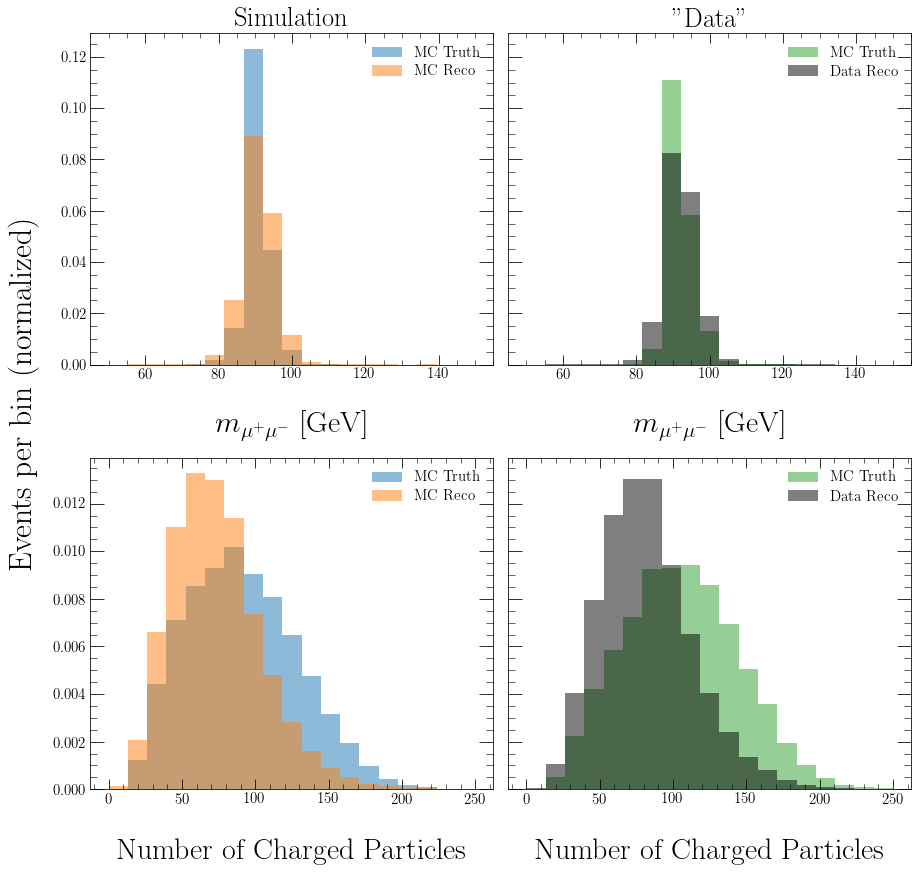

In [57]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 12),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(50, 150, 20)

ax[0, 0].set_title('Simulation')
ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG0, _, _ = ax[0, 0].hist(m_ll_sim_truth,
                          bins=bins,
                          label='MC Truth',
                          **plot_style_2,
                          color='C0')
hS0, _, _ = ax[0, 0].hist(m_ll_sim_reco,
                          bins=bins,
                          label='MC Reco',
                          **plot_style_2,
                          color='C1')
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Data"')
ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[0, 1].hist(m_ll_data_truth,
                          weights=weights_stress,
                          bins=bins,
                          label='MC Truth',
                          **plot_style_2,
                          color='C2')
hS1, _, _ = ax[0, 1].hist(m_ll_data_reco,
                          weights=weights_stress,
                          bins=bins,
                          label='Data Reco',
                          **plot_style_2,
                          color='k')
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
hG0, _, _ = ax[1, 0].hist(nTracks_sim_truth,
                          bins=bins,
                          label='MC Truth',
                          **plot_style_2,
                          color='C0')
hS0, _, _ = ax[1, 0].hist(nTracks_sim_reco,
                          bins=bins,
                          label='MC Reco',
                          **plot_style_2,
                          color='C1')
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(nTracks_data_truth,
                          weights=weights_stress,
                          bins=bins,
                          label='MC Truth',
                          **plot_style_2,
                          color='C2')
hS1, _, _ = ax[1, 1].hist(nTracks_data_reco,
                          weights=weights_stress,
                          bins=bins,
                          label='Data Reco',
                          **plot_style_2,
                          color='k')
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.text(-0.05,
         0.55,
         'Events per bin (normalized)',
         va='center',
         rotation='vertical',
         fontsize='x-large')
# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-MultiFold-Distributions.pdf', 
#     bbox_inches='tight')
fig.show()

### Unfold $m_{\mu^+\mu^-}$ and Number of Charged Particles Simultaneously

In [60]:
# z-score standardization

num_observables = 2

scaler_m_ll_truth = preprocessing.StandardScaler()
scaler_m_ll_reco = preprocessing.StandardScaler()

scaler_m_ll_truth.fit(m_ll_sim_truth.reshape(-1,1))
scaler_m_ll_reco.fit(np.concatenate((m_ll_sim_reco, m_ll_data_reco)).reshape(-1,1))

scaler_nTracks_truth = preprocessing.StandardScaler()
scaler_nTracks_reco = preprocessing.StandardScaler()

scaler_nTracks_truth.fit(nTracks_sim_truth.reshape(-1,1))
scaler_nTracks_reco.fit(np.concatenate((nTracks_sim_reco, nTracks_data_reco)).reshape(-1,1))

sim_truth = (np.squeeze(scaler_m_ll_truth.transform(m_ll_sim_truth.reshape(-1,1))),
             np.squeeze(scaler_nTracks_truth.transform(nTracks_sim_truth.reshape(-1,1))))

sim_reco = (np.squeeze(scaler_m_ll_reco.transform(m_ll_sim_reco.reshape(-1,1))),
             np.squeeze(scaler_nTracks_reco.transform(nTracks_sim_reco.reshape(-1,1))))

data_reco = (np.squeeze(scaler_m_ll_reco.transform(m_ll_data_reco.reshape(-1,1))),
                   np.squeeze(scaler_nTracks_reco.transform(nTracks_data_reco.reshape(-1,1))))

In [61]:
weights, _ = multifold(num_observables=num_observables,
                       iterations=10,
                       sim_truth=sim_truth,
                       sim_reco=sim_reco,
                       data_reco=data_reco,
                       weights_MC_data=weights_stress)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 4s 9us/step - loss: 0.6794 - acc: 0.5010 - val_loss: 0.6755 - val_acc: 0.5019
Epoch 2/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6763 - acc: 0.5003 - val_loss: 0.6753 - val_acc: 0.5023
Epoch 3/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6763 - acc: 0.5002 - val_loss: 0.6752 - val_acc: 0.5019
Epoch 4/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6762 - acc: 0.5002 - val_loss: 0.6752 - val_acc: 0.5023
Epoch 5/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6762 - acc: 0.5001 - val_loss: 0.6752 - val_acc: 0.5023
Epoch 6/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6762 - acc: 0.5002 - val_loss: 0.6752 - val_acc: 0.5021
Epoch 7/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6761 - a


ITERATION: 2

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6939 - acc: 0.5003 - val_loss: 0.6941 - val_acc: 0.4996
Epoch 2/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6937 - acc: 0.5006 - val_loss: 0.6941 - val_acc: 0.4998
Epoch 3/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6937 - acc: 0.5011 - val_loss: 0.6941 - val_acc: 0.4998
Epoch 4/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6937 - acc: 0.5006 - val_loss: 0.6942 - val_acc: 0.4999
Epoch 5/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6937 - acc: 0.5007 - val_loss: 0.6941 - val_acc: 0.4996
Epoch 6/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6937 - acc: 0.5006 - val_loss: 0.6941 - val_acc: 0.4998
Epoch 7/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6937 - a

Epoch 5/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6982 - acc: 0.5000 - val_loss: 0.6975 - val_acc: 0.5006
Epoch 6/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6982 - acc: 0.5003 - val_loss: 0.6975 - val_acc: 0.5005
Epoch 7/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6982 - acc: 0.5004 - val_loss: 0.6975 - val_acc: 0.5009
Epoch 8/200
466582/466582 [==============================] - 4s 9us/step - loss: 0.6982 - acc: 0.5011 - val_loss: 0.6976 - val_acc: 0.5004
Epoch 9/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6982 - acc: 0.4999 - val_loss: 0.6975 - val_acc: 0.5010
Epoch 10/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6982 - acc: 0.5003 - val_loss: 0.6975 - val_acc: 0.5012
Epoch 11/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6982 - acc: 0.5008 - val_loss: 0.6976 - val_acc: 0.5008
Epoch 12/200
466582/46658

466582/466582 [==============================] - 4s 8us/step - loss: 0.6620 - acc: 0.5003 - val_loss: 0.6626 - val_acc: 0.4991
Epoch 9/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6619 - acc: 0.5004 - val_loss: 0.6627 - val_acc: 0.4992
Epoch 10/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6620 - acc: 0.5003 - val_loss: 0.6627 - val_acc: 0.4993
Epoch 11/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6620 - acc: 0.5002 - val_loss: 0.6627 - val_acc: 0.4995
Epoch 12/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6620 - acc: 0.5001 - val_loss: 0.6626 - val_acc: 0.4995
Epoch 13/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6620 - acc: 0.5004 - val_loss: 0.6627 - val_acc: 0.4990
Epoch 14/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6620 - acc: 0.5002 - val_loss: 0.6627 - val_acc: 0.4990
Epoch 15/200
466582/466582 [======

466582/466582 [==============================] - 3s 7us/step - loss: 0.6603 - acc: 0.5004 - val_loss: 0.6609 - val_acc: 0.4996
Epoch 5/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6604 - acc: 0.5002 - val_loss: 0.6610 - val_acc: 0.4994
Epoch 6/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6604 - acc: 0.5002 - val_loss: 0.6609 - val_acc: 0.4996
Epoch 7/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6604 - acc: 0.5001 - val_loss: 0.6610 - val_acc: 0.4993
Epoch 8/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6604 - acc: 0.5003 - val_loss: 0.6609 - val_acc: 0.4995
Epoch 9/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6603 - acc: 0.5002 - val_loss: 0.6610 - val_acc: 0.4992
Epoch 10/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6603 - acc: 0.5001 - val_loss: 0.6609 - val_acc: 0.4995
Epoch 11/200
466582/466582 [==========

466582/466582 [==============================] - 3s 7us/step - loss: 0.6583 - acc: 0.4998 - val_loss: 0.6577 - val_acc: 0.5005
Epoch 4/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6583 - acc: 0.4997 - val_loss: 0.6576 - val_acc: 0.5008
Epoch 5/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6583 - acc: 0.4998 - val_loss: 0.6576 - val_acc: 0.5007
Epoch 6/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6583 - acc: 0.4997 - val_loss: 0.6576 - val_acc: 0.5006
Epoch 7/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6583 - acc: 0.4997 - val_loss: 0.6577 - val_acc: 0.5008
Epoch 8/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6583 - acc: 0.4999 - val_loss: 0.6577 - val_acc: 0.5006
Epoch 9/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6583 - acc: 0.4997 - val_loss: 0.6577 - val_acc: 0.5007
Epoch 10/200
466582/466582 [===========

#### Results

ITERATION: 1


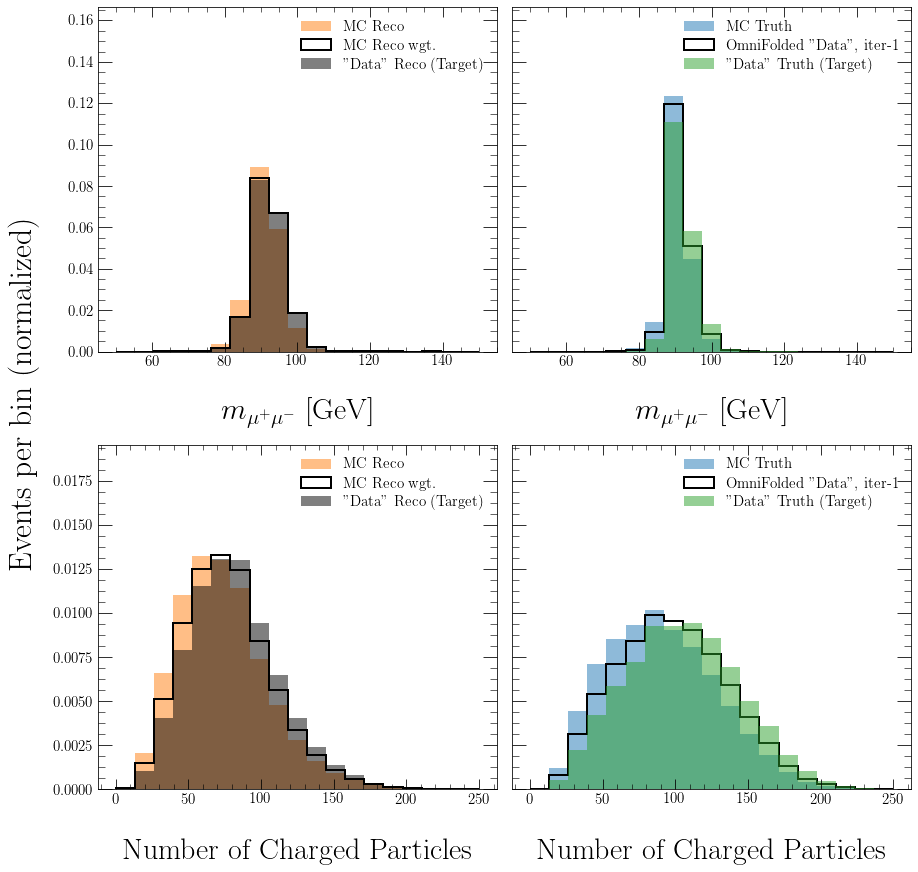

ITERATION: 2


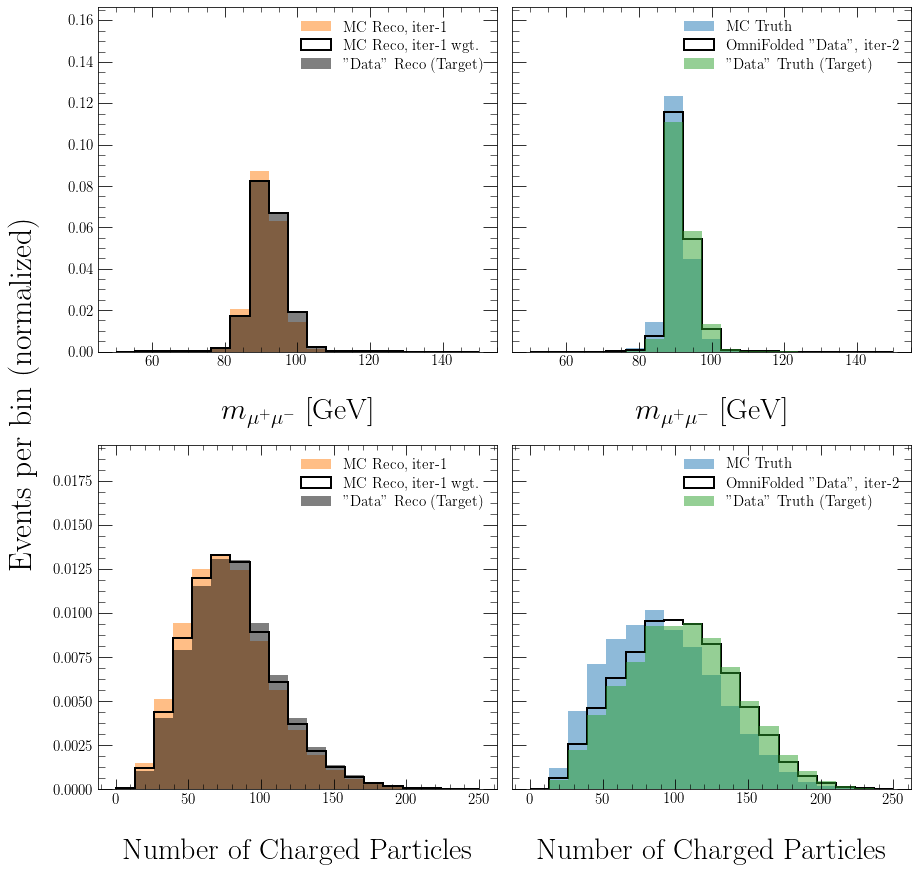

ITERATION: 3


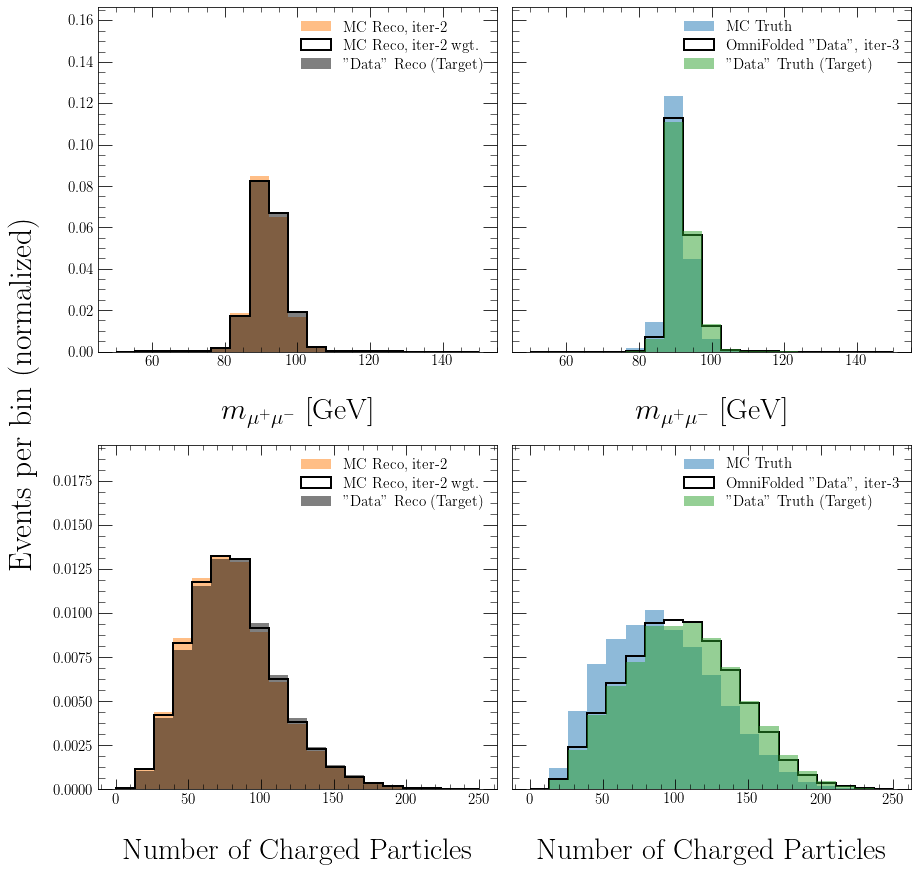

ITERATION: 4


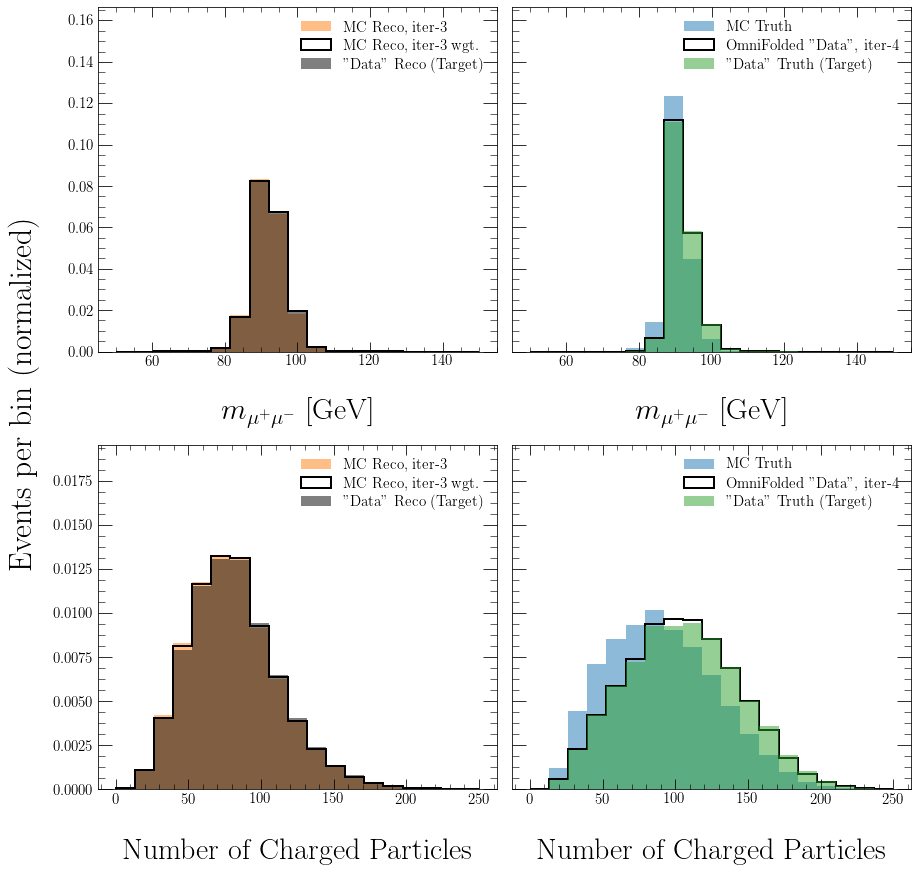

ITERATION: 5


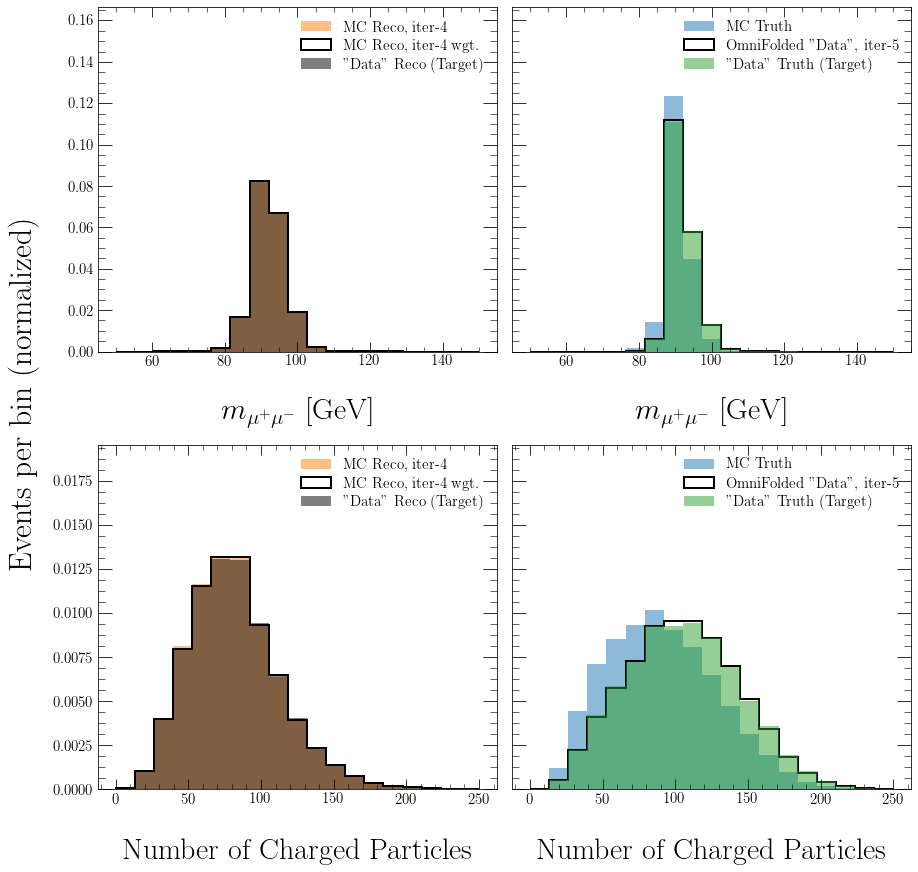

ITERATION: 6


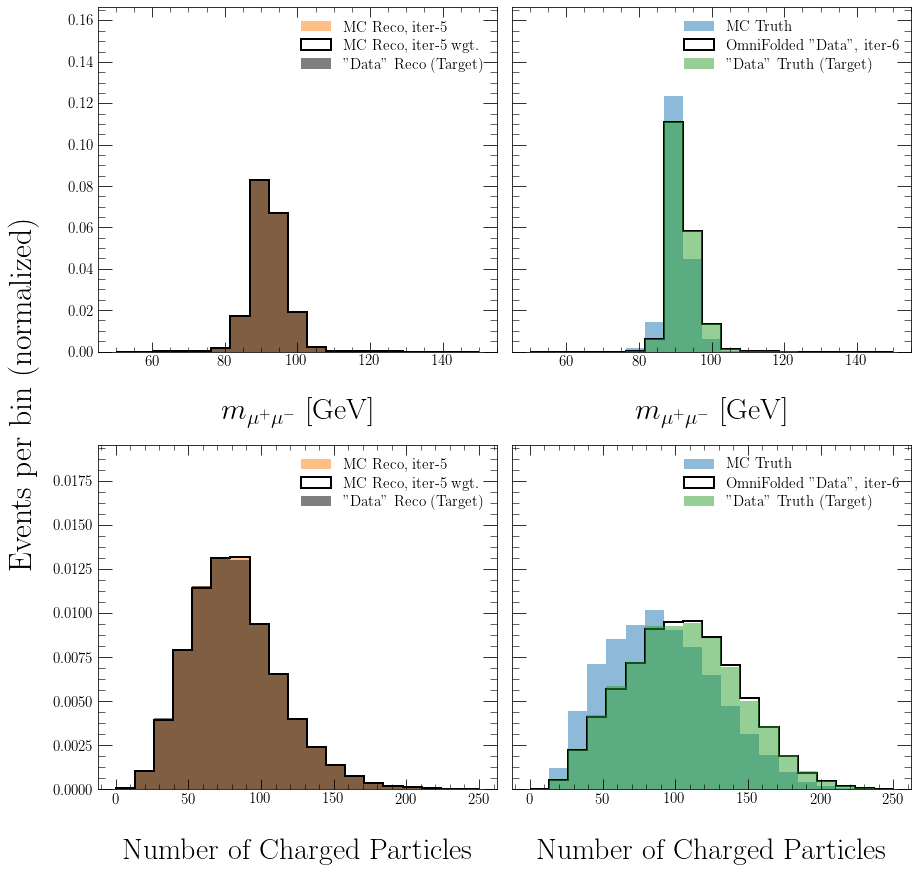

ITERATION: 7


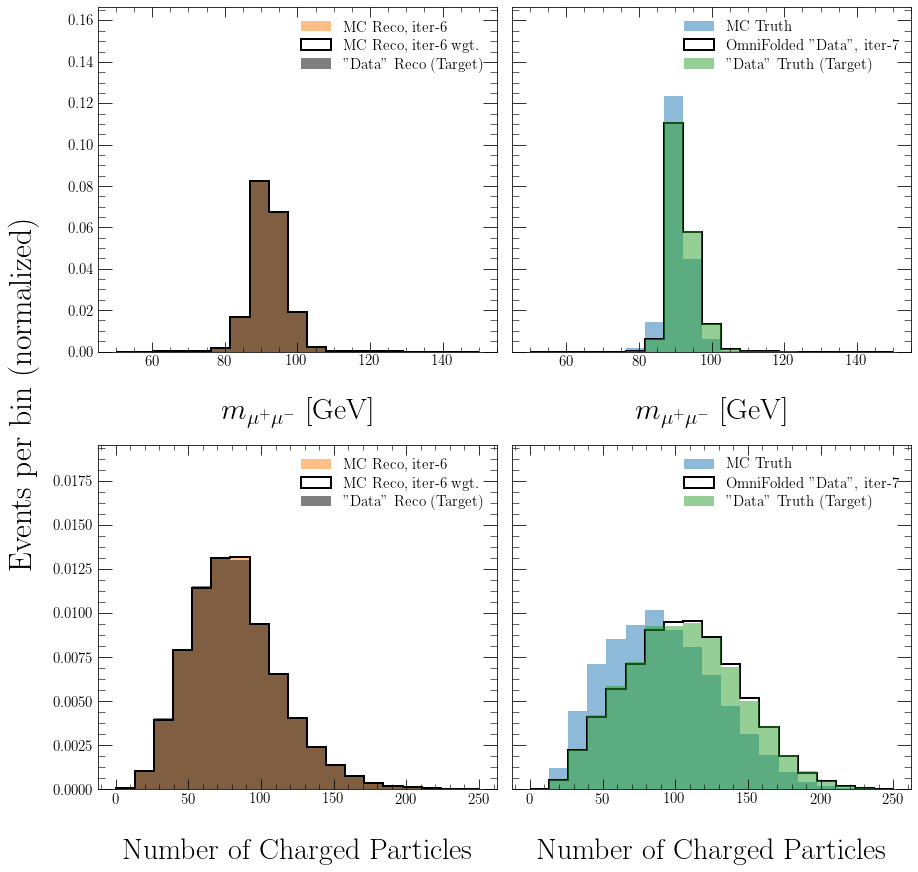

ITERATION: 8


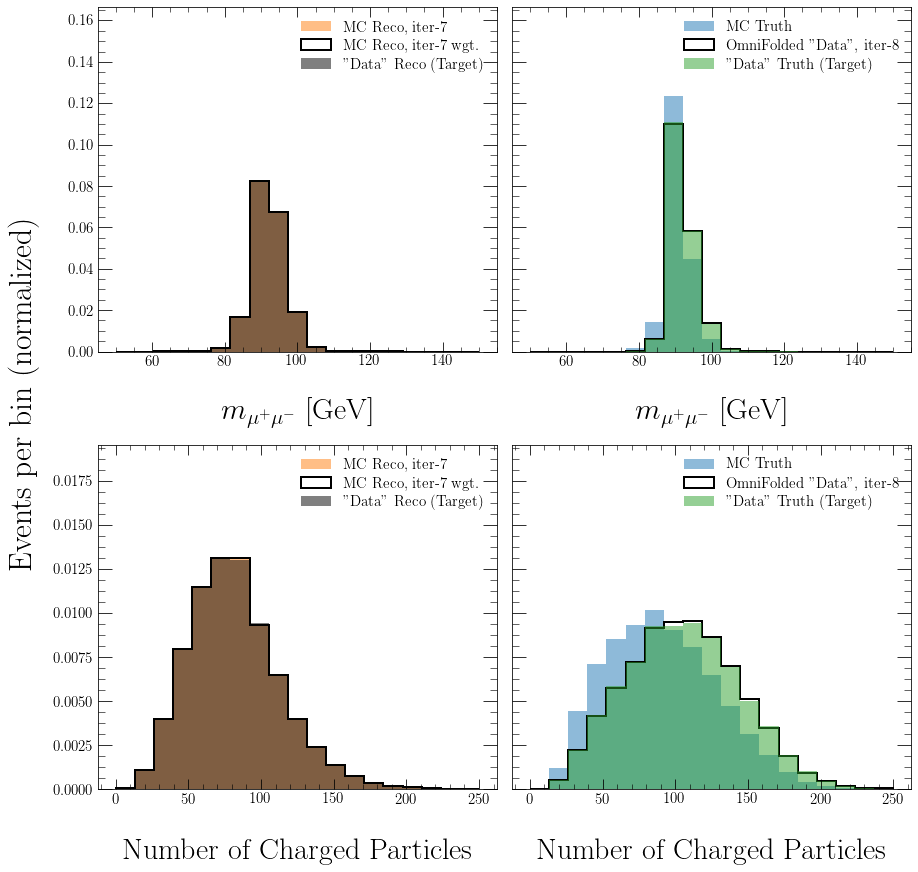

ITERATION: 9


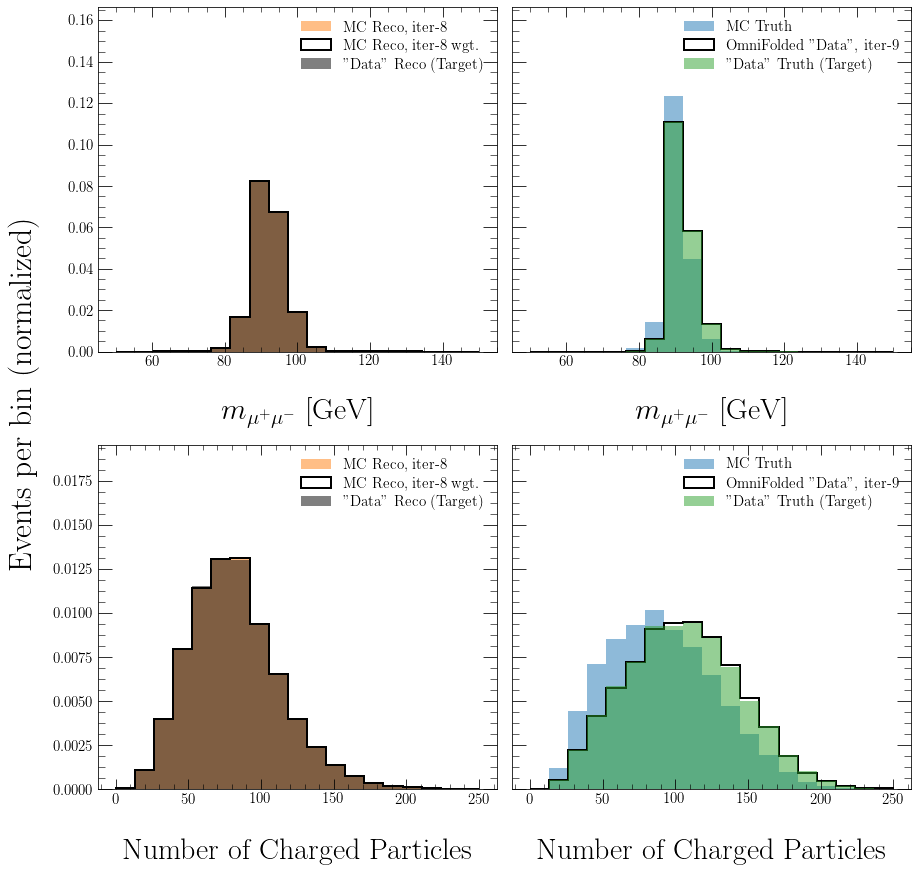

ITERATION: 10


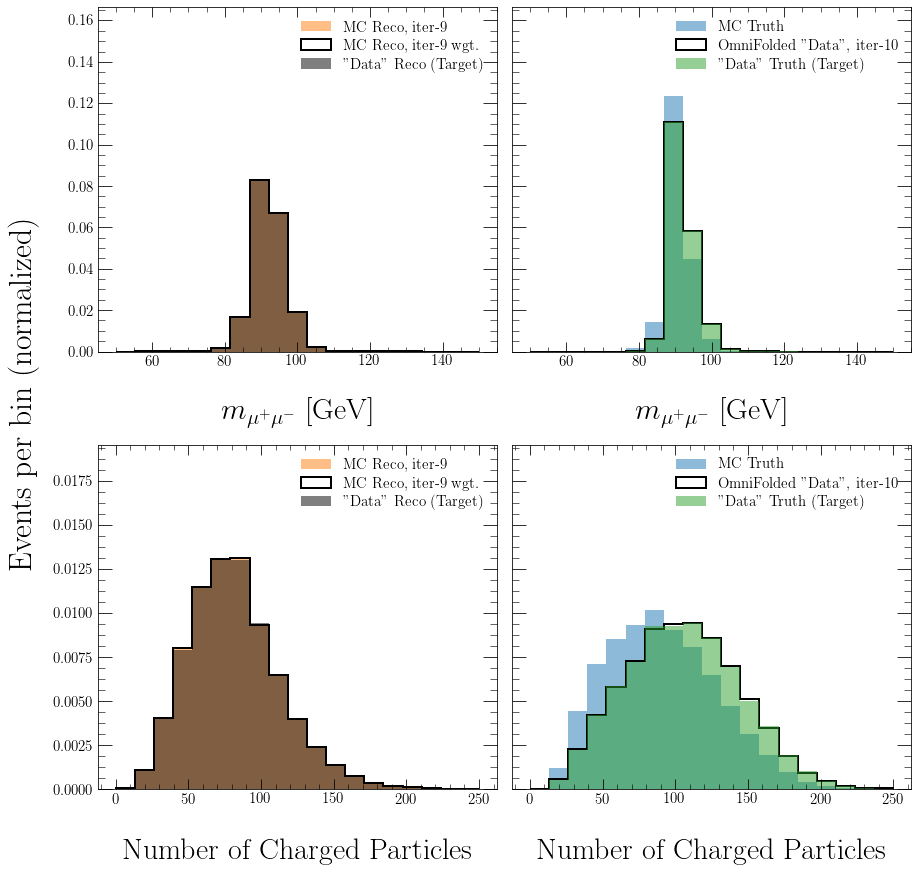

In [62]:
for i in range(len(weights)):
    if i == 0:
        weights_init = np.ones(len(weights[i - 1, 1, :]))
        label0 = ''.format(i)
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(num_observables,
                           2,
                           figsize=(12, 12),
                           constrained_layout=True,
                           sharey='row')

    ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0, 0].hist(m_ll_sim_reco,
                  weights=weights_init,
                  bins=bins,
                  label='MC Reco' + label0,
                  **plot_style_2,
                  color='C1')
    ax[0, 0].hist(m_ll_sim_reco,
                  bins=bins,
                  weights=weights[i, 0, :],
                  label='MC Reco' + label0 + ' wgt.',
                  **plot_style_1)

    hR0, _, _ = ax[0, 0].hist(m_ll_data_reco,
                              weights=weights_stress,
                              bins=bins,
                              label=r'"Data" Reco (Target)',
                              **plot_style_2,
                              color='k')
    ax[0, 0].legend(frameon=False)
    

    ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0, 1].hist(m_ll_sim_truth,
                  bins=bins,
                  label=r'MC Truth',
                  **plot_style_2,
                  color='C0')
    ax[0, 1].hist(m_ll_sim_truth,
                  bins=bins,
                  weights=weights[i, 1, :],
                  label='OmniFolded "Data"' + label1,
                  **plot_style_1)

    hT0, _, _ = ax[0, 1].hist(m_ll_data_truth,
                              weights=weights_stress,
                              bins=bins,
                              label=r'"Data" Truth (Target)',
                              **plot_style_2,
                              color='C2')
    ax[0, 0].set_ylim([0, 1.5 * np.max(np.concatenate((hT0, hR0)))])
    ax[0, 1].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1, 0].set_xlabel('Number of Charged Particles')
    ax[1, 0].hist(nTracks_sim_reco,
                  weights=weights_init,
                  bins=bins,
                  label='MC Reco' + label0,
                  **plot_style_2,
                  color='C1')
    ax[1, 0].hist(nTracks_sim_reco,
                  bins=bins,
                  weights=weights[i, 1, :],
                  label='MC Reco' + label0 + ' wgt.',
                  **plot_style_1)
    hR1, _, _ = ax[1, 0].hist(nTracks_data_reco,
                              weights=weights_stress,
                              bins=bins,
                              label=r'"Data" Reco (Target)',
                              **plot_style_2,
                              color='k')
    ax[1, 0].legend(frameon=False)

    ax[1, 1].set_xlabel('Number of Charged Particles')
    ax[1, 1].hist(nTracks_sim_truth,
                  bins=bins,
                  label=r'MC Truth',
                  **plot_style_2,
                  color='C0')
    ax[1, 1].hist(nTracks_sim_truth,
                  bins=bins,
                  weights=weights[i, 1, :],
                  label='OmniFolded "Data"' + label1,
                  **plot_style_1)
    hT1, _, _ = ax[1, 1].hist(nTracks_data_truth,
                              weights=weights_stress,
                              bins=bins,
                              label=r'"Data" Truth (Target)',
                              **plot_style_2,
                              color='C2')
    ax[1, 1].legend(frameon=False)

    fig.text(-0.05,
             0.55,
             'Events per bin (normalized)',
             va='center',
             rotation='vertical',
             fontsize='x-large')

    ax[1, 0].set_ylim([0, 1.5 * np.max(np.concatenate((hT1, hR1)))])

#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestA-MultiFold-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    fig.show()
    plt.show()

# Stress Test B
Stress weights are based on a random variable.
After standardizing (z-score) each observable $x$ to $x'$, the weights are given by $w\sim  \mathcal{N}(0, \text{sigmoid}(x'))$.

## UniFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles separately.

### Setup Datasets

In [63]:
m_ll_sim_truth, m_ll_data_truth, m_ll_sim_reco, m_ll_data_reco = train_test_split(Events_0.events['truth_m_ll'][mypass_0],
                                                                      Events_0.events['m_ll'][mypass_0], 
                                                                      test_size=0.5)

In [64]:
scaler_m_ll = preprocessing.StandardScaler()

scaler_m_ll.fit(np.concatenate((m_ll_sim_truth, m_ll_data_truth)).reshape(-1,1))

weight_m_ll_seed = np.squeeze(scaler_m_ll.transform(m_ll_data_truth.reshape(-1,1)))

In [65]:
weights_m_ll_stress = [
    abs(np.random.normal(0, sigmoid(std))) for std in weight_m_ll_seed
]
weights_m_ll_stress = np.array(weights_m_ll_stress)
weights_m_ll_stress = weights_m_ll_stress / np.mean(weights_m_ll_stress)

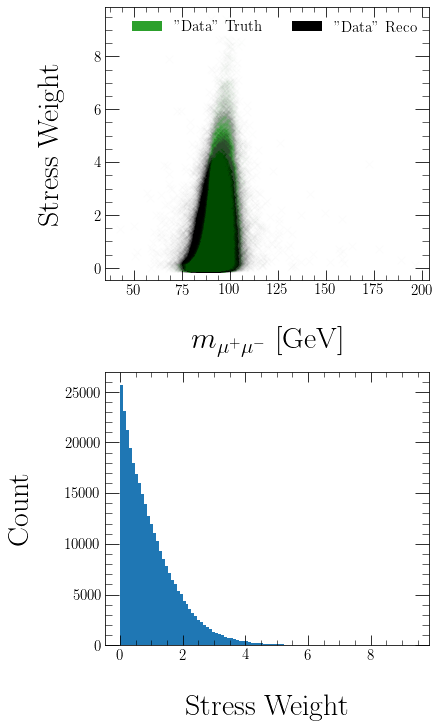

In [66]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10), constrained_layout=True)

ax[0].plot(m_ll_data_reco,
           weights_m_ll_stress,
           'x',
           alpha=0.01,
           label='Data',
           color='k')
ax[0].plot(m_ll_data_truth,
           weights_m_ll_stress,
           'x',
           alpha=0.01,
           label='Truth',
           color='C2')

ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Stress Weight')
handles = [Patch(facecolor='C2'), Patch(facecolor='k')]
labels = ['"Data" Truth', '"Data" Reco']
ax[0].legend(handles, labels, ncol=2)

ax[1].hist(weights_m_ll_stress,
           bins=np.linspace(np.min(weights_m_ll_stress),
                            np.max(weights_m_ll_stress), 100))
ax[1].set_xlabel('Stress Weight')
ax[1].set_ylabel('Count')

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-UniFold-m_ll-StressWeights.png',
#     bbox_inches='tight')

fig.show()

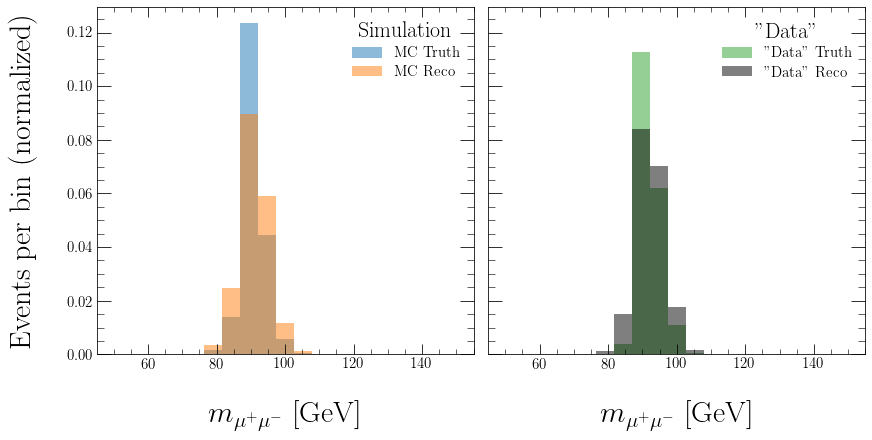

In [69]:
bins = np.linspace(50, 150, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Events per bin (normalized)')
hG0, _, _ = ax[0].hist(m_ll_sim_truth,
                       bins=bins,
                       label='MC Truth',
                       **plot_style_2,
                       color='C0')
hS0, _, _ = ax[0].hist(m_ll_sim_reco,
                       bins=bins,
                       label='MC Reco',
                       **plot_style_2,
                       color='C1')
legend = ax[0].legend(title='Simulation', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[1].hist(m_ll_data_truth,
                       weights=weights_m_ll_stress,
                       bins=bins,
                       label='"Data" Truth',
                       **plot_style_2,
                       color='C2')
hS1, _, _ = ax[1].hist(m_ll_data_reco,
                       weights=weights_m_ll_stress,
                       bins=bins,
                       label='"Data" Reco',
                       **plot_style_2,
                       color='k')
legend = ax[1].legend(title='"Data"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-UniFold-m_ll-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

In [70]:
nTracks_sim_truth, nTracks_data_truth, nTracks_sim_reco, nTracks_data_reco = train_test_split(np.array(ntrack_sim_truth),
                                                                      np.array(ntrack_sim_reco), 
                                                                      test_size=0.5)

In [71]:
scaler_nTracks = preprocessing.StandardScaler()

scaler_nTracks.fit(np.concatenate((nTracks_sim_truth, nTracks_data_truth)).reshape(-1,1))

weight_nTracks_seed = np.squeeze(scaler_nTracks.transform(nTracks_data_truth.reshape(-1,1)))

In [72]:
weights_nTracks_stress = [abs(np.random.normal(0, sigmoid(std))) for std in weight_nTracks_seed]
weights_nTracks_stress = np.array(weights_nTracks_stress)
weights_nTracks_stress = weights_nTracks_stress/np.mean(weights_nTracks_stress)

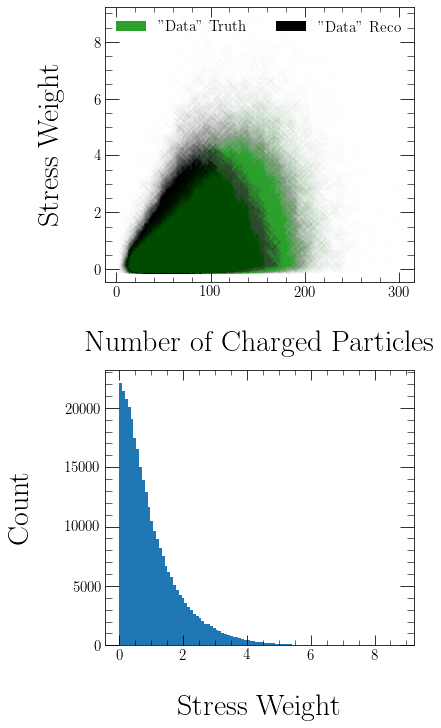

In [73]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10), constrained_layout=True)

ax[0].plot(nTracks_data_reco, weights_nTracks_stress,
           'x',
           alpha=0.01,
           label='Data',
           color='k')
ax[0].plot(nTracks_data_truth, weights_nTracks_stress,
           'x',
           alpha=0.01,
           label='Truth',
           color='C2')

ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Stress Weight')
handles = [Patch(facecolor='C2'), Patch(facecolor='k')]
labels = ['"Data" Truth', '"Data" Reco']
ax[0].legend(handles, labels, ncol=2)

ax[1].hist(weights_nTracks_stress,
           bins=np.linspace(np.min(weights_nTracks_stress),
                            np.max(weights_nTracks_stress), 100))
ax[1].set_xlabel('Stress Weight')
ax[1].set_ylabel('Count')

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-UniFold-nTracks-StressWeights.png',
#     bbox_inches='tight')

fig.show()

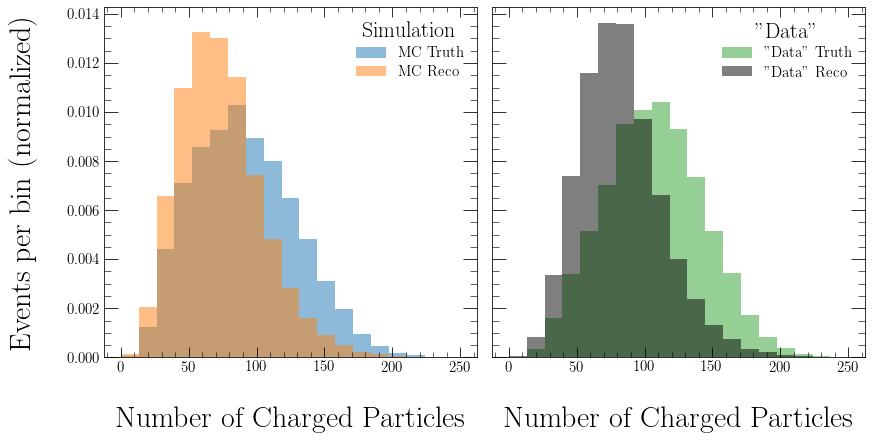

In [74]:
bins = np.linspace(0, 250, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Events per bin (normalized)')
hG0, _, _ = ax[0].hist(nTracks_sim_truth,
                       bins=bins,
                       label='MC Truth',
                       **plot_style_2,
                       color='C0')
hS0, _, _ = ax[0].hist(nTracks_sim_reco,
                       bins=bins,
                       label='MC Reco',
                       **plot_style_2,
                       color='C1')
legend = ax[0].legend(title='Simulation', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1].hist(nTracks_data_truth,
                       weights=weights_nTracks_stress,
                       bins=bins,
                       label='"Data" Truth',
                       **plot_style_2,
                       color='C2')
hS1, _, _ = ax[1].hist(nTracks_data_reco,
                       weights=weights_nTracks_stress,
                       bins=bins,
                       label='"Data" Reco',
                       **plot_style_2,
                       color='k')
legend = ax[1].legend(title='"Data"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-UniFold-nTracks-Distributions.pdf',
#     bbox_inches='tight')
fig.show()

### Unfold $m_{\mu^+\mu^-}$

In [75]:
# z-score standardization

scaler_truth = preprocessing.StandardScaler()
scaler_reco = preprocessing.StandardScaler()

scaler_truth.fit(m_ll_sim_truth.reshape(-1,1))
scaler_reco.fit(np.concatenate((m_ll_sim_reco, m_ll_data_reco)).reshape(-1,1))

sim_truth = np.squeeze(scaler_truth.transform(m_ll_sim_truth.reshape(-1,1)))
sim_reco = np.squeeze(scaler_reco.transform(m_ll_sim_reco.reshape(-1,1)))
data_reco = np.squeeze(scaler_reco.transform(m_ll_data_reco.reshape(-1,1)))

In [76]:
weights, _ = unifold(iterations=10,
                     sim_truth=sim_truth,
                     sim_reco=sim_reco,
                     data_reco=data_reco,
                     weights_MC_data=weights_m_ll_stress)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 6s 13us/step - loss: 0.6857 - acc: 0.5002 - val_loss: 0.6844 - val_acc: 0.5013
Epoch 2/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6843 - acc: 0.5000 - val_loss: 0.6844 - val_acc: 0.5008
Epoch 3/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6842 - acc: 0.5002 - val_loss: 0.6844 - val_acc: 0.5010
Epoch 4/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6842 - acc: 0.5004 - val_loss: 0.6844 - val_acc: 0.5014
Epoch 5/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6842 - acc: 0.5002 - val_loss: 0.6843 - val_acc: 0.5006
Epoch 6/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6841 - acc: 0.5004 - val_loss: 0.6843 - val_acc: 0.5010
Epoch 7/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6841 - 

466582/466582 [==============================] - 6s 12us/step - loss: 0.6831 - acc: 0.5001 - val_loss: 0.6830 - val_acc: 0.5012
Epoch 2/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6828 - acc: 0.5000 - val_loss: 0.6831 - val_acc: 0.5004
Epoch 3/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6828 - acc: 0.5001 - val_loss: 0.6830 - val_acc: 0.5006
Epoch 4/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6828 - acc: 0.4995 - val_loss: 0.6830 - val_acc: 0.5007
Epoch 5/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6828 - acc: 0.5000 - val_loss: 0.6831 - val_acc: 0.5006
Epoch 6/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6828 - acc: 0.4994 - val_loss: 0.6831 - val_acc: 0.5005
Epoch 7/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6828 - acc: 0.4997 - val_loss: 0.6830 - val_acc: 0.5005
Epoch 8/200
466582/466582 [===========

466582/466582 [==============================] - 3s 6us/step - loss: 0.6776 - acc: 0.5001 - val_loss: 0.6775 - val_acc: 0.4988
Epoch 8/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6776 - acc: 0.5004 - val_loss: 0.6775 - val_acc: 0.4991
Epoch 9/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6776 - acc: 0.5002 - val_loss: 0.6775 - val_acc: 0.4992
Epoch 10/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6776 - acc: 0.5004 - val_loss: 0.6775 - val_acc: 0.4991
Epoch 11/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6776 - acc: 0.5001 - val_loss: 0.6775 - val_acc: 0.4991
Epoch 12/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6776 - acc: 0.5001 - val_loss: 0.6775 - val_acc: 0.4990
Restoring model weights from the end of the best epoch
Epoch 00012: early stopping

ITERATION: 5

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
46658

466582/466582 [==============================] - 3s 6us/step - loss: 0.6920 - acc: 0.4999 - val_loss: 0.6908 - val_acc: 0.5008
Epoch 12/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6920 - acc: 0.5005 - val_loss: 0.6908 - val_acc: 0.5005
Epoch 13/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6920 - acc: 0.5007 - val_loss: 0.6908 - val_acc: 0.5002
Epoch 14/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6920 - acc: 0.5003 - val_loss: 0.6908 - val_acc: 0.5012
Epoch 15/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6920 - acc: 0.5004 - val_loss: 0.6908 - val_acc: 0.5020
Epoch 16/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6920 - acc: 0.5010 - val_loss: 0.6909 - val_acc: 0.4996
Epoch 17/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6920 - acc: 0.5001 - val_loss: 0.6908 - val_acc: 0.5006
Epoch 18/200
466582/466582 [=====

466582/466582 [==============================] - 3s 7us/step - loss: 0.6716 - acc: 0.5002 - val_loss: 0.6718 - val_acc: 0.5003
Epoch 10/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6716 - acc: 0.5000 - val_loss: 0.6718 - val_acc: 0.4996
Epoch 11/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6716 - acc: 0.5001 - val_loss: 0.6718 - val_acc: 0.5001
Epoch 12/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6716 - acc: 0.4998 - val_loss: 0.6718 - val_acc: 0.5001
Epoch 13/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6716 - acc: 0.4999 - val_loss: 0.6718 - val_acc: 0.4997
Epoch 14/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6716 - acc: 0.5000 - val_loss: 0.6718 - val_acc: 0.5000
Epoch 15/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6716 - acc: 0.4999 - val_loss: 0.6719 - val_acc: 0.4995
Epoch 16/200
466582/466582 [=====

466582/466582 [==============================] - 6s 13us/step - loss: 0.6964 - acc: 0.5002 - val_loss: 0.6927 - val_acc: 0.5028
Epoch 2/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6924 - acc: 0.5002 - val_loss: 0.6927 - val_acc: 0.4999
Epoch 3/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6924 - acc: 0.5010 - val_loss: 0.6927 - val_acc: 0.4993
Epoch 4/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6924 - acc: 0.5003 - val_loss: 0.6927 - val_acc: 0.5000
Epoch 5/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6924 - acc: 0.5011 - val_loss: 0.6927 - val_acc: 0.5001
Epoch 6/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6924 - acc: 0.5007 - val_loss: 0.6927 - val_acc: 0.4997
Epoch 7/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6924 - acc: 0.5011 - val_loss: 0.6927 - val_acc: 0.5011
Epoch 8/200
466582/466582 [===========

466582/466582 [==============================] - 3s 6us/step - loss: 0.6713 - acc: 0.5001 - val_loss: 0.6707 - val_acc: 0.4994
Epoch 5/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6713 - acc: 0.5001 - val_loss: 0.6708 - val_acc: 0.4994
Epoch 6/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6713 - acc: 0.5000 - val_loss: 0.6707 - val_acc: 0.4990
Epoch 7/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6713 - acc: 0.5002 - val_loss: 0.6708 - val_acc: 0.4995
Epoch 8/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6714 - acc: 0.5003 - val_loss: 0.6708 - val_acc: 0.4994
Epoch 9/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6714 - acc: 0.5001 - val_loss: 0.6707 - val_acc: 0.4992
Epoch 10/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6714 - acc: 0.5003 - val_loss: 0.6707 - val_acc: 0.4999
Epoch 11/200
466582/466582 [==========

#### Results 

ITERATION 1:


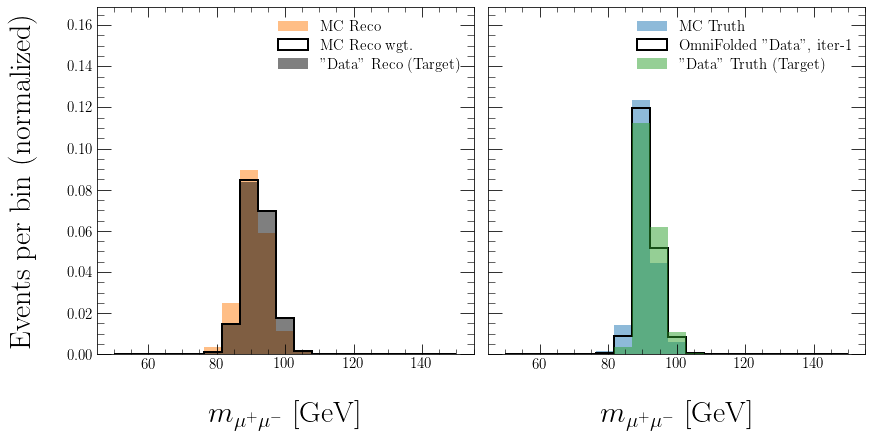

ITERATION 2:


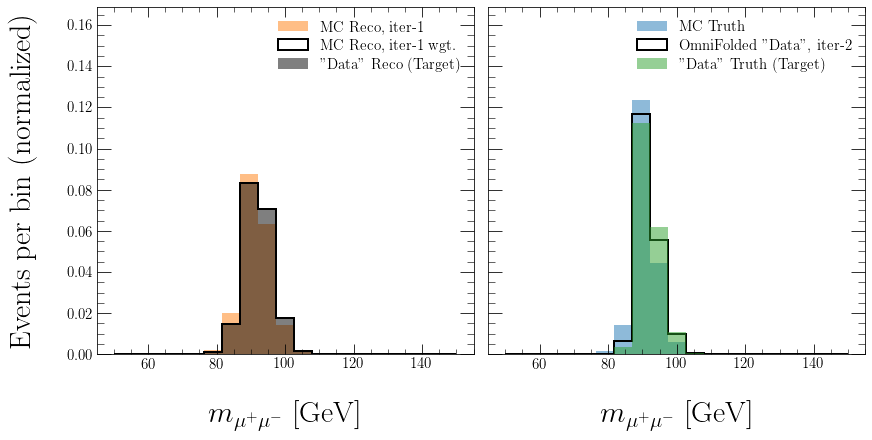

ITERATION 3:


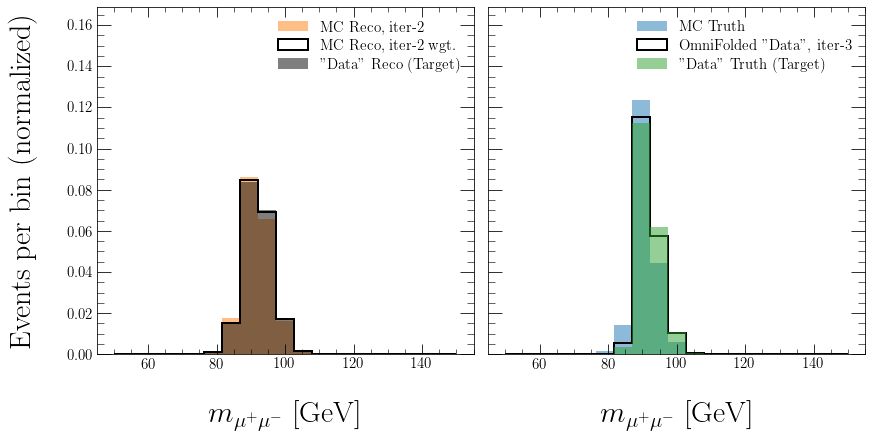

ITERATION 4:


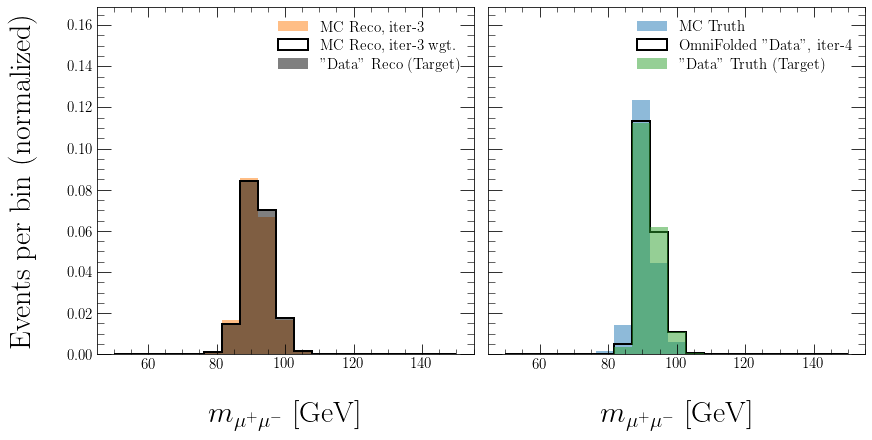

ITERATION 5:


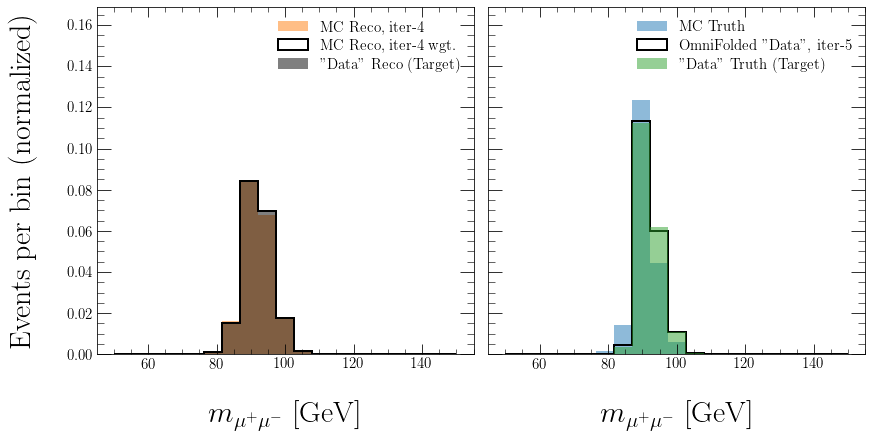

ITERATION 6:


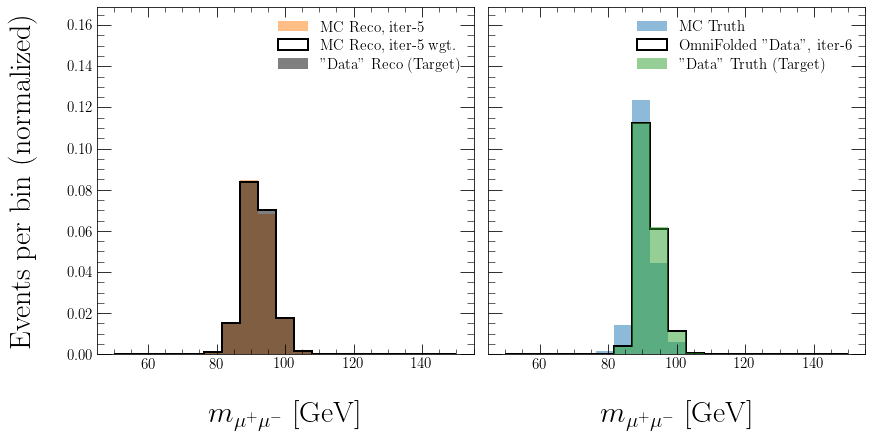

ITERATION 7:


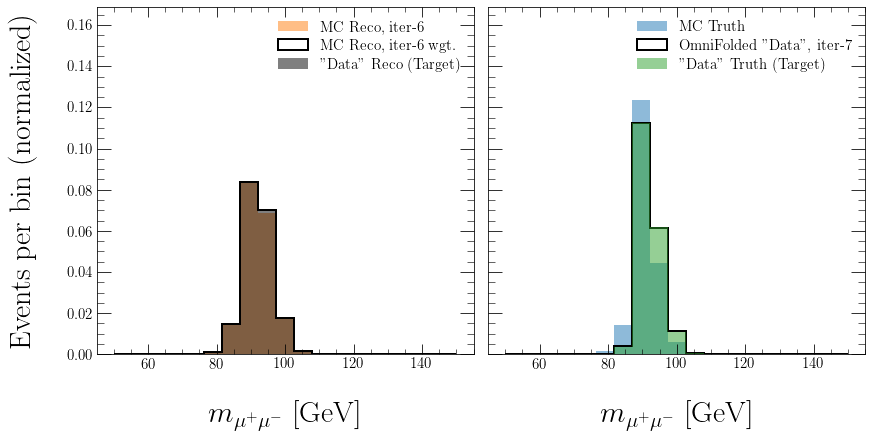

ITERATION 8:


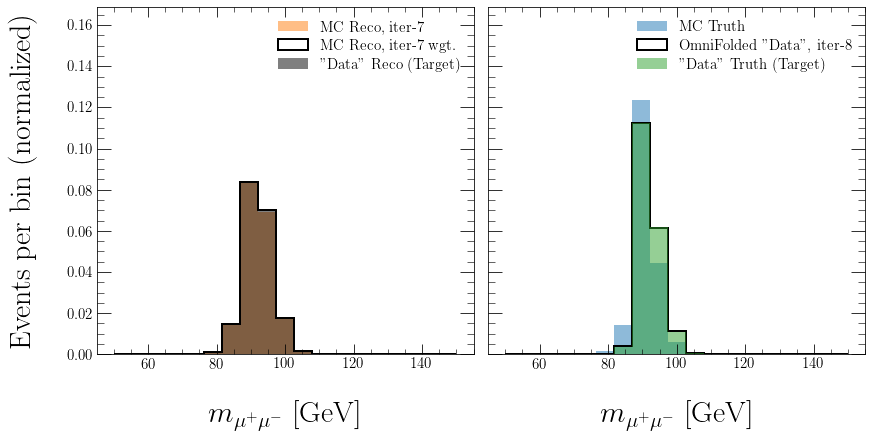

ITERATION 9:


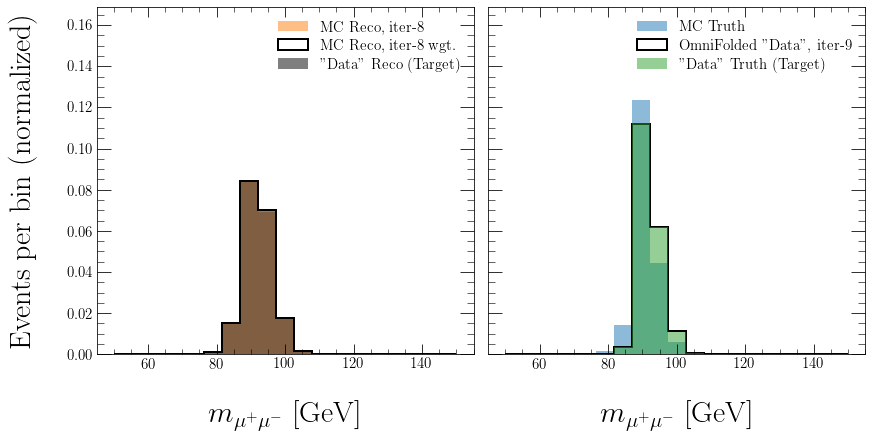

ITERATION 10:


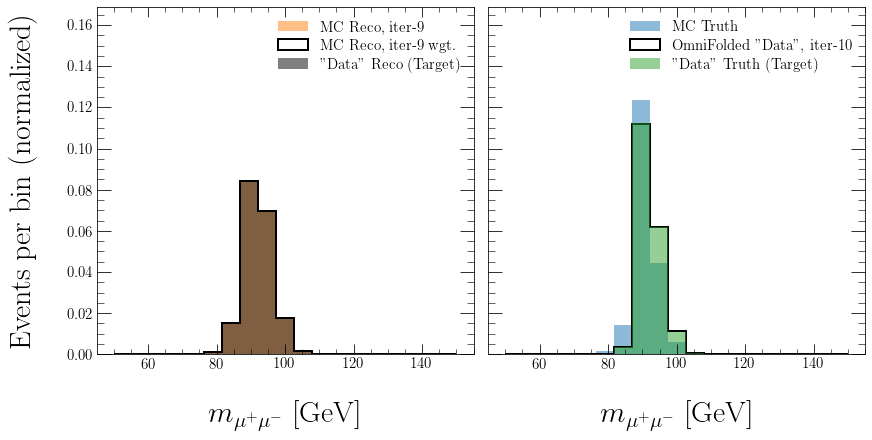

In [77]:
bins = np.linspace(50, 150, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(m_ll_sim_reco))
        label0 = ''
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    ax[0].hist(m_ll_sim_reco,
               weights=weights_init,
               bins=bins,
               label='MC Reco' + label0,
               **plot_style_2,
               color='C1')

    ax[0].hist(m_ll_sim_reco,
               bins=bins,
               label='MC Reco' + label0 + ' wgt.',
               weights=weights[i, 0, :],
               **plot_style_1)
    hR, _, _ = ax[0].hist(m_ll_data_reco,
                          weights=weights_m_ll_stress,
                          bins=bins,
                          label='"Data" Reco (Target)',
                          **plot_style_2,
                          color='k')
    ax[0].set_xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend()
    ax[1].hist(m_ll_sim_truth, bins=bins, label=r'MC Truth', **plot_style_2)

    ax[1].hist(m_ll_sim_truth,
               bins=bins,
               label='OmniFolded "Data"' + label1,
               weights=weights[i, 1, :],
               **plot_style_1)
    hT, _, _ = ax[1].hist(m_ll_data_truth,
                          weights=weights_m_ll_stress,
                          bins=bins,
                          label='"Data" Truth (Target)',
                          **plot_style_2,
                          color='C2')
    ax[1].legend()
    ax[1].set_xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")

    plt.ylim([0, 1.5 * max(max(hT), max(hR))])
    fig.show()
#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-UniFold-m_ll-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    plt.show()

### Unfold Number of Charged Particles

In [78]:
# z-score standardization

scaler_truth = preprocessing.StandardScaler()
scaler_reco = preprocessing.StandardScaler()

scaler_truth.fit(nTracks_sim_truth.reshape(-1,1))
scaler_reco.fit(np.concatenate((nTracks_sim_reco, nTracks_data_reco)).reshape(-1,1))

sim_truth = np.squeeze(scaler_truth.transform(nTracks_sim_truth.reshape(-1,1)))
sim_reco = np.squeeze(scaler_reco.transform(nTracks_sim_reco.reshape(-1,1)))
data_reco = np.squeeze(scaler_reco.transform(nTracks_data_reco.reshape(-1,1)))

In [79]:
weights, _ = unifold(iterations=10,
                     sim_truth=sim_truth,
                     sim_reco=sim_reco,
                     data_reco=data_reco,
                     weights_MC_data=weights_nTracks_stress)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 6s 13us/step - loss: 0.6822 - acc: 0.4999 - val_loss: 0.6797 - val_acc: 0.5001
Epoch 2/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6805 - acc: 0.4994 - val_loss: 0.6795 - val_acc: 0.4998
Epoch 3/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6805 - acc: 0.4992 - val_loss: 0.6795 - val_acc: 0.4998
Epoch 4/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6804 - acc: 0.4993 - val_loss: 0.6796 - val_acc: 0.4999
Epoch 5/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6804 - acc: 0.4993 - val_loss: 0.6795 - val_acc: 0.4998
Epoch 6/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6804 - acc: 0.4993 - val_loss: 0.6795 - val_acc: 0.4999
Epoch 7/200
466582/466582 [==============================] - 3s 5us/step - loss: 0.6804 - 

Epoch 4/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6926 - acc: 0.4999 - val_loss: 0.6913 - val_acc: 0.4992
Epoch 5/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6926 - acc: 0.4998 - val_loss: 0.6913 - val_acc: 0.4992
Epoch 6/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6926 - acc: 0.4997 - val_loss: 0.6913 - val_acc: 0.4991
Epoch 7/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6925 - acc: 0.5000 - val_loss: 0.6914 - val_acc: 0.4986
Epoch 8/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6926 - acc: 0.4999 - val_loss: 0.6914 - val_acc: 0.4986
Epoch 9/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6925 - acc: 0.5000 - val_loss: 0.6913 - val_acc: 0.4992
Epoch 10/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6925 - acc: 0.5001 - val_loss: 0.6913 - val_acc: 0.4992
Epoch 11/200
466582/466582

466582/466582 [==============================] - 3s 6us/step - loss: 0.6895 - acc: 0.4999 - val_loss: 0.6888 - val_acc: 0.4981
Epoch 9/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6895 - acc: 0.4997 - val_loss: 0.6887 - val_acc: 0.4980
Epoch 10/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6895 - acc: 0.4999 - val_loss: 0.6887 - val_acc: 0.4979
Epoch 11/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6895 - acc: 0.4999 - val_loss: 0.6888 - val_acc: 0.4977
Epoch 12/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6895 - acc: 0.4998 - val_loss: 0.6888 - val_acc: 0.4983
Epoch 13/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6894 - acc: 0.5000 - val_loss: 0.6887 - val_acc: 0.4979
Epoch 14/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6895 - acc: 0.5001 - val_loss: 0.6888 - val_acc: 0.4976
Restoring model weights from the e

466582/466582 [==============================] - 3s 6us/step - loss: 0.6721 - acc: 0.4992 - val_loss: 0.6715 - val_acc: 0.5020
Epoch 13/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6722 - acc: 0.4993 - val_loss: 0.6715 - val_acc: 0.5019
Epoch 14/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6722 - acc: 0.4993 - val_loss: 0.6715 - val_acc: 0.5021
Epoch 15/200
466582/466582 [==============================] - 3s 5us/step - loss: 0.6721 - acc: 0.4993 - val_loss: 0.6715 - val_acc: 0.5020
Epoch 16/200
466582/466582 [==============================] - 4s 9us/step - loss: 0.6721 - acc: 0.4993 - val_loss: 0.6715 - val_acc: 0.5021
Epoch 17/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6722 - acc: 0.4993 - val_loss: 0.6715 - val_acc: 0.5021
Epoch 18/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6721 - acc: 0.4993 - val_loss: 0.6715 - val_acc: 0.5019
Epoch 19/200
466582/466582 [=====

466582/466582 [==============================] - 3s 7us/step - loss: 0.6695 - acc: 0.4998 - val_loss: 0.6703 - val_acc: 0.5007
Epoch 7/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6695 - acc: 0.4998 - val_loss: 0.6703 - val_acc: 0.5007
Epoch 8/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6695 - acc: 0.4998 - val_loss: 0.6703 - val_acc: 0.5008
Epoch 9/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6695 - acc: 0.4997 - val_loss: 0.6704 - val_acc: 0.5008
Epoch 10/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6695 - acc: 0.4998 - val_loss: 0.6703 - val_acc: 0.5007
Epoch 11/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6695 - acc: 0.4995 - val_loss: 0.6704 - val_acc: 0.5007
Epoch 12/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6695 - acc: 0.4997 - val_loss: 0.6704 - val_acc: 0.5007
Restoring model weights from the end

466582/466582 [==============================] - 3s 7us/step - loss: 0.6943 - acc: 0.5007 - val_loss: 0.6937 - val_acc: 0.4995
Epoch 14/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6943 - acc: 0.5008 - val_loss: 0.6937 - val_acc: 0.5005
Epoch 15/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6943 - acc: 0.5005 - val_loss: 0.6937 - val_acc: 0.5005
Epoch 16/200
466582/466582 [==============================] - 3s 5us/step - loss: 0.6943 - acc: 0.5005 - val_loss: 0.6936 - val_acc: 0.4987
Epoch 17/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6943 - acc: 0.5003 - val_loss: 0.6936 - val_acc: 0.4995
Epoch 18/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6943 - acc: 0.5002 - val_loss: 0.6936 - val_acc: 0.4977
Epoch 19/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6943 - acc: 0.5003 - val_loss: 0.6936 - val_acc: 0.4981
Epoch 20/200
466582/466582 [=====

466582/466582 [==============================] - 3s 6us/step - loss: 0.6679 - acc: 0.4997 - val_loss: 0.6675 - val_acc: 0.5011
Epoch 11/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6679 - acc: 0.4996 - val_loss: 0.6675 - val_acc: 0.5007
Epoch 12/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6679 - acc: 0.4997 - val_loss: 0.6675 - val_acc: 0.5007
Restoring model weights from the end of the best epoch
Epoch 00012: early stopping

ITERATION: 10

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 8s 17us/step - loss: 0.6960 - acc: 0.5002 - val_loss: 0.6928 - val_acc: 0.4988
Epoch 2/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6917 - acc: 0.5003 - val_loss: 0.6927 - val_acc: 0.4995
Epoch 3/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6917 - acc: 0.5002 - val_loss: 0.6928 - val_acc: 0.4996
Epoch 4/200
4665

#### Results

ITERATION 1:


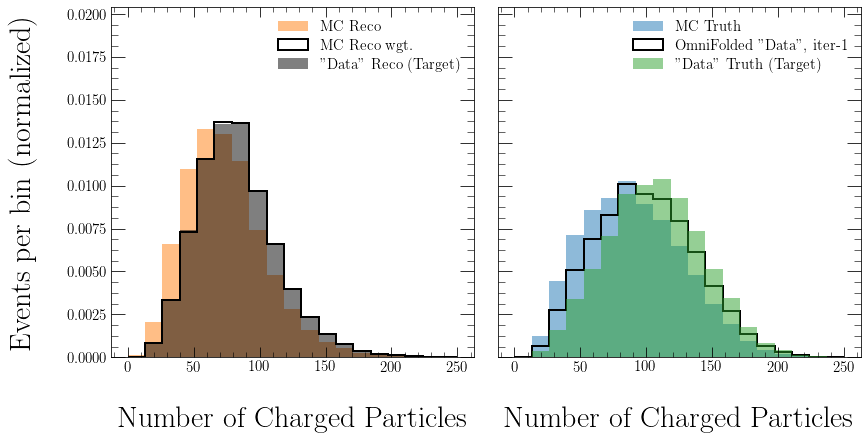

ITERATION 2:


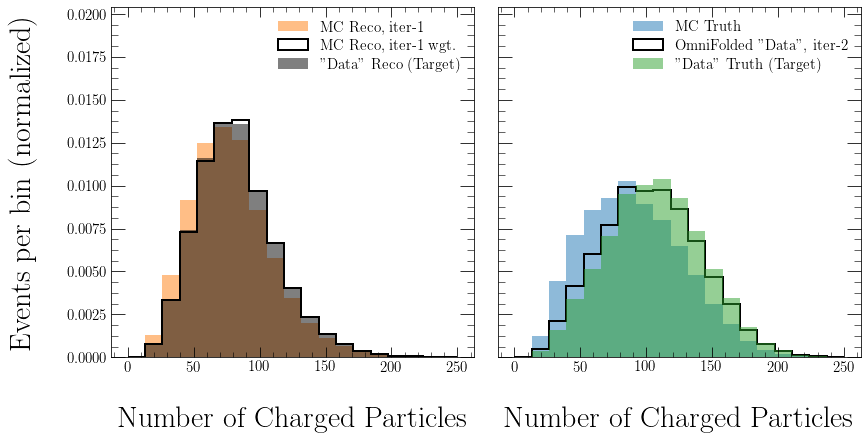

ITERATION 3:


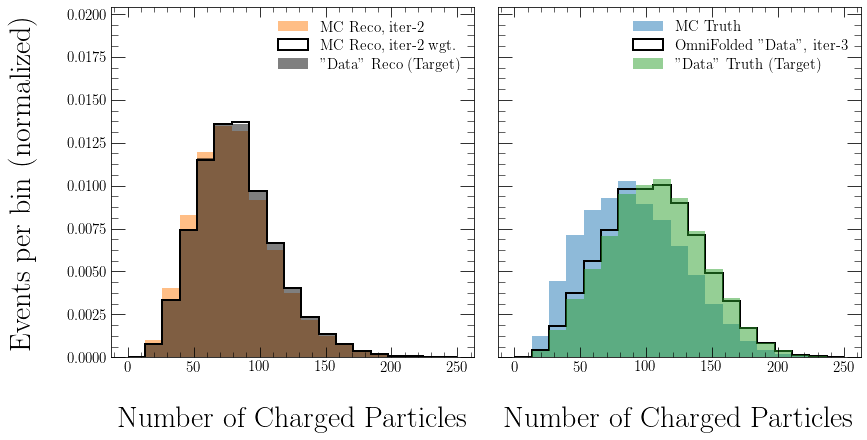

ITERATION 4:


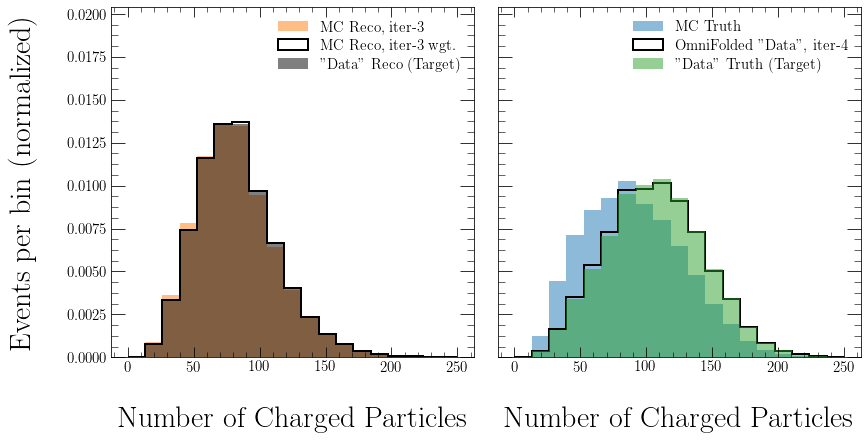

ITERATION 5:


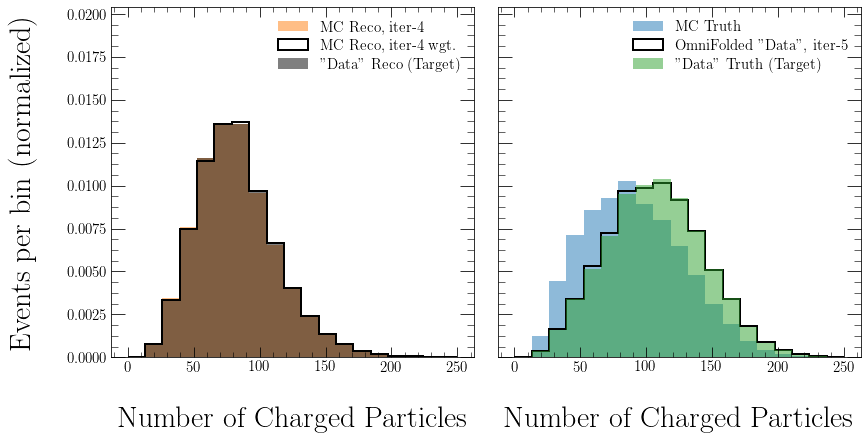

ITERATION 6:


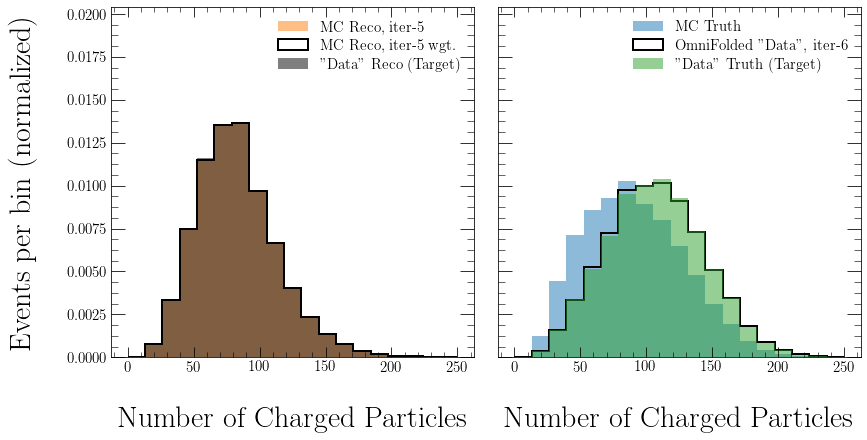

ITERATION 7:


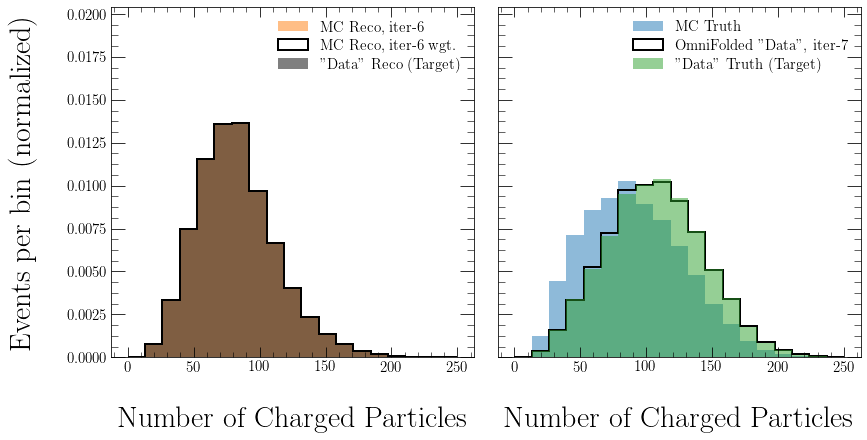

ITERATION 8:


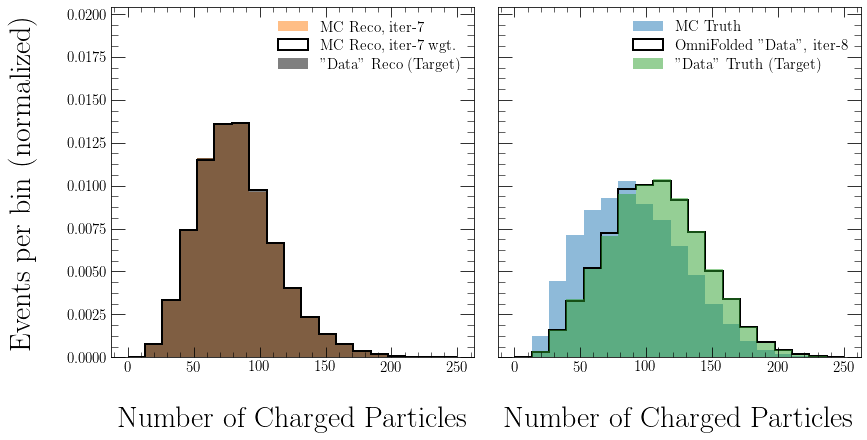

ITERATION 9:


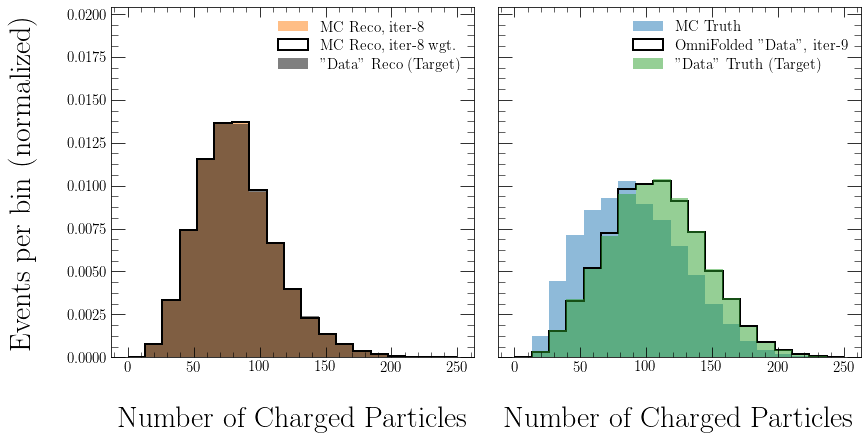

ITERATION 10:


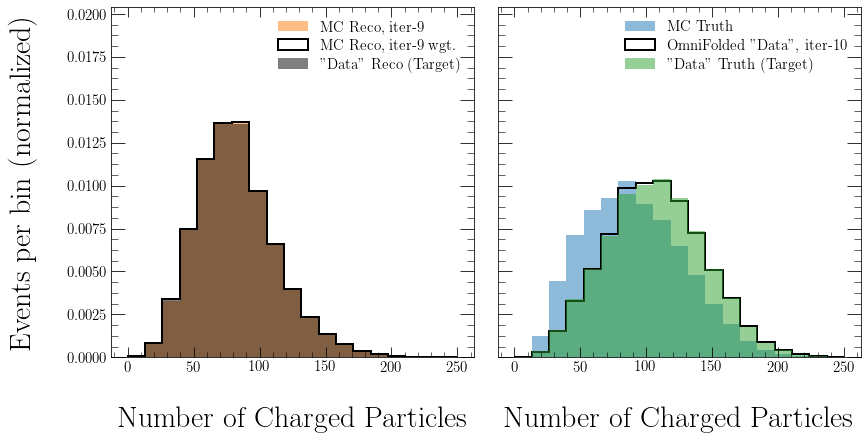

In [80]:
bins = np.linspace(0, 250, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(nTracks_sim_reco))
        label0 = ''
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    ax[0].hist(nTracks_sim_reco,
               weights=weights_init,
               bins=bins,
               label='MC Reco' + label0,
               **plot_style_2,
               color='C1')

    ax[0].hist(nTracks_sim_reco,
               bins=bins,
               label='MC Reco' + label0 + ' wgt.',
               weights=weights[i, 0, :],
               **plot_style_1)
    hR, _, _ = ax[0].hist(nTracks_data_reco,
                          weights=weights_nTracks_stress,
                          bins=bins,
                          label='"Data" Reco (Target)',
                          **plot_style_2,
                          color='k')
    ax[0].set_xlabel(r"Number of Charged Particles")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend()
    ax[1].hist(nTracks_sim_truth, bins=bins, label=r'MC Truth', **plot_style_2)

    ax[1].hist(nTracks_sim_truth,
               bins=bins,
               label='OmniFolded "Data"' + label1,
               weights=weights[i, 1, :],
               **plot_style_1)
    hT, _, _ = ax[1].hist(nTracks_data_truth,
                          weights=weights_nTracks_stress,
                          bins=bins,
                          label='"Data" Truth (Target)',
                          **plot_style_2,
                          color='C2')
    ax[1].legend()
    ax[1].set_xlabel(r"Number of Charged Particles")

    plt.ylim([0, 1.5 * max(max(hT), max(hR))])
    fig.show()
#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-UniFold-nTracks-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    plt.show()

## Multifold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles simultaneously.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

In [81]:
K.clear_session()

### Setup datasets

In [82]:
m_ll_sim_truth, m_ll_data_truth, m_ll_sim_reco, m_ll_data_reco, nTracks_sim_truth, nTracks_data_truth, nTracks_sim_reco, nTracks_data_reco = train_test_split(
    Events_0.events['truth_m_ll'][mypass_0],
    Events_0.events['m_ll'][mypass_0],
    np.array(ntrack_sim_truth),
    np.array(ntrack_sim_reco),
    test_size=0.5)

In [83]:
scaler_m_ll = preprocessing.StandardScaler()
scaler_m_ll.fit(np.concatenate((m_ll_sim_truth, m_ll_data_truth)).reshape(-1,1))

scaler_nTracks = preprocessing.StandardScaler()
scaler_nTracks.fit(np.concatenate((nTracks_sim_truth, nTracks_data_truth)).reshape(-1,1))

weight_m_ll_seed = np.squeeze(scaler_m_ll.transform(m_ll_data_truth.reshape(-1,1)))
weight_nTracks_seed = np.squeeze(scaler_nTracks.transform(nTracks_data_truth.reshape(-1,1)))

weight_seed = weight_m_ll_seed + weight_nTracks_seed

In [84]:
weights_stress = [
    abs(np.random.normal(0, sigmoid(std))) for std in weight_seed
]
weights_stress = np.array(weights_stress)
weights_stress = weights_stress / np.mean(weights_stress)

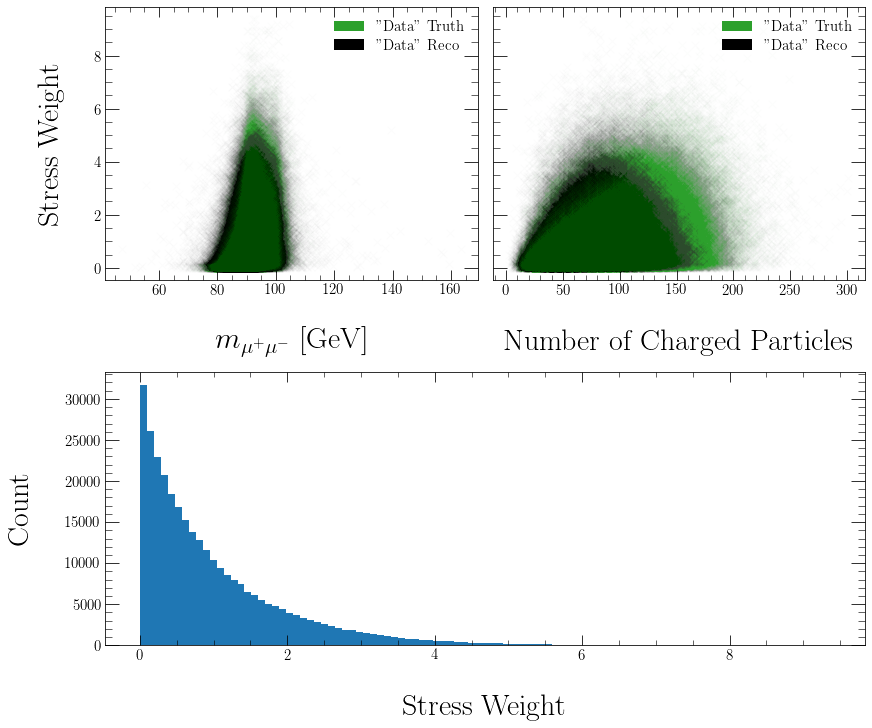

In [85]:
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(m_ll_data_reco,
         weights_stress,
         'x',
         alpha=0.01,
         color='k',
         label='"Data" Reco')
ax0.plot(m_ll_data_truth,
         weights_stress,
         'x',
         alpha=0.01,
         color='C2',
         label='"Data" Truth')
ax0.set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax0.set_ylabel('Stress Weight')

ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
plt.setp(ax1.get_yticklabels(), visible=False)
ax1.plot(nTracks_data_reco,
         weights_stress,
         'x',
         alpha=0.01,
         color='k',
         label='"Data" Reco')
ax1.plot(nTracks_data_truth,
         weights_stress,
         'x',
         alpha=0.01,
         color='C2',
         label='"Data" Truth')
ax1.set_xlabel('Number of Charged Particles')

handles = [Patch(facecolor='C2'), Patch(facecolor='k')]
labels = ['"Data" Truth', '"Data" Reco']
ax0.legend(handles, labels)
ax1.legend(handles, labels)

ax2 = fig.add_subplot(gs[1, :])
ax2.hist(weights_stress,
         bins=np.linspace(np.min(weights_stress), np.max(weights_stress), 100))
ax2.set_xlabel('Stress Weight')
ax2.set_ylabel('Count')

# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-MultiFold-StressWeights.png',
#     bbox_inches='tight')

fig.show()

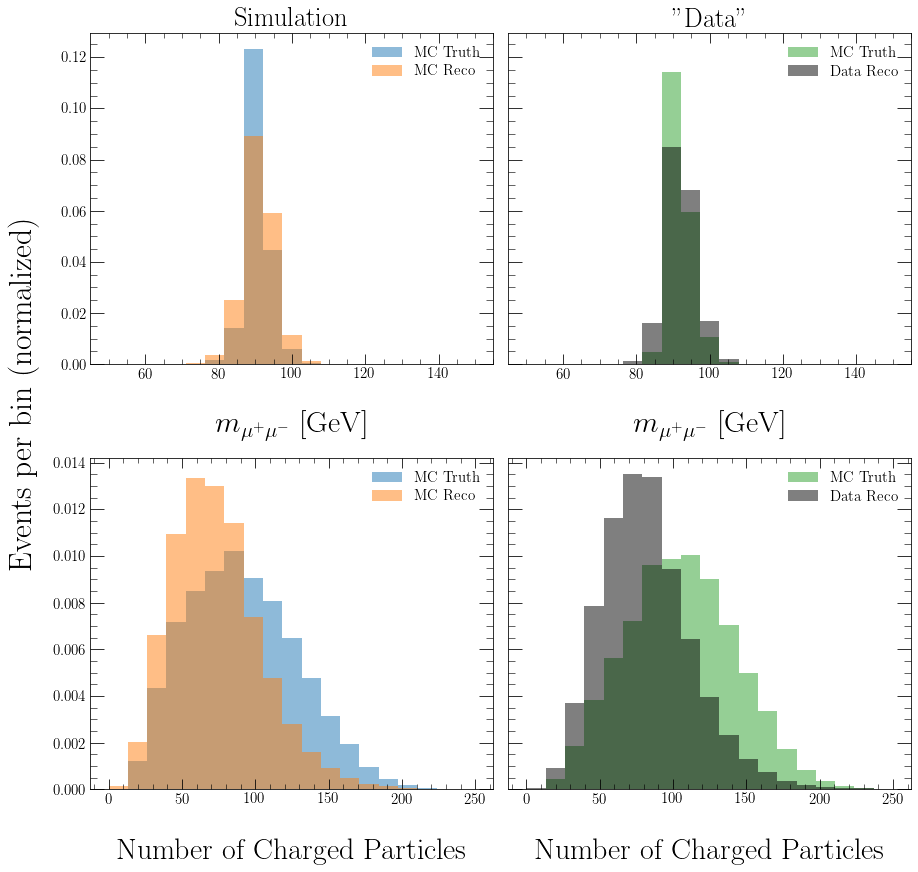

In [86]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 12),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(50, 150, 20)

ax[0, 0].set_title('Simulation')
ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG0, _, _ = ax[0, 0].hist(m_ll_sim_truth,
                          bins=bins,
                          label='MC Truth',
                          **plot_style_2,
                          color='C0')
hS0, _, _ = ax[0, 0].hist(m_ll_sim_reco,
                          bins=bins,
                          label='MC Reco',
                          **plot_style_2,
                          color='C1')
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Data"')
ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[0, 1].hist(m_ll_data_truth,
                          weights=weights_stress,
                          bins=bins,
                          label='MC Truth',
                          **plot_style_2,
                          color='C2')
hS1, _, _ = ax[0, 1].hist(m_ll_data_reco,
                          weights=weights_stress,
                          bins=bins,
                          label='Data Reco',
                          **plot_style_2,
                          color='k')
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
hG0, _, _ = ax[1, 0].hist(nTracks_sim_truth,
                          bins=bins,
                          label='MC Truth',
                          **plot_style_2,
                          color='C0')
hS0, _, _ = ax[1, 0].hist(nTracks_sim_reco,
                          bins=bins,
                          label='MC Reco',
                          **plot_style_2,
                          color='C1')
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(nTracks_data_truth,
                          weights=weights_stress,
                          bins=bins,
                          label='MC Truth',
                          **plot_style_2,
                          color='C2')
hS1, _, _ = ax[1, 1].hist(nTracks_data_reco,
                          weights=weights_stress,
                          bins=bins,
                          label='Data Reco',
                          **plot_style_2,
                          color='k')
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.text(-0.05,
         0.55,
         'Events per bin (normalized)',
         va='center',
         rotation='vertical',
         fontsize='x-large')
# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])
# fig.savefig(
#     'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-MultiFold-Distributions.pdf', 
#     bbox_inches='tight')
fig.show()

### Unfold $m_{\mu^+\mu^-}$ and Number of Charged Particles Simultaneously

In [87]:
# z-score standardization

num_observables = 2

scaler_m_ll_truth = preprocessing.StandardScaler()
scaler_m_ll_reco = preprocessing.StandardScaler()

scaler_m_ll_truth.fit(m_ll_sim_truth.reshape(-1,1))
scaler_m_ll_reco.fit(np.concatenate((m_ll_sim_reco, m_ll_data_reco)).reshape(-1,1))

scaler_nTracks_truth = preprocessing.StandardScaler()
scaler_nTracks_reco = preprocessing.StandardScaler()

scaler_nTracks_truth.fit(nTracks_sim_truth.reshape(-1,1))
scaler_nTracks_reco.fit(np.concatenate((nTracks_sim_reco, nTracks_data_reco)).reshape(-1,1))

sim_truth = (np.squeeze(scaler_m_ll_truth.transform(m_ll_sim_truth.reshape(-1,1))),
             np.squeeze(scaler_nTracks_truth.transform(nTracks_sim_truth.reshape(-1,1))))

sim_reco = (np.squeeze(scaler_m_ll_reco.transform(m_ll_sim_reco.reshape(-1,1))),
             np.squeeze(scaler_nTracks_reco.transform(nTracks_sim_reco.reshape(-1,1))))

data_reco = (np.squeeze(scaler_m_ll_reco.transform(m_ll_data_reco.reshape(-1,1))),
                   np.squeeze(scaler_nTracks_reco.transform(nTracks_data_reco.reshape(-1,1))))

In [88]:
weights, _ = multifold(num_observables=num_observables,
                       iterations=10,
                       sim_truth=sim_truth,
                       sim_reco=sim_reco,
                       data_reco=data_reco,
                       weights_MC_data=weights_stress)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 4s 9us/step - loss: 0.6794 - acc: 0.5008 - val_loss: 0.6729 - val_acc: 0.4994
Epoch 2/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6753 - acc: 0.5010 - val_loss: 0.6727 - val_acc: 0.4996
Epoch 3/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6752 - acc: 0.5009 - val_loss: 0.6728 - val_acc: 0.4993
Epoch 4/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6752 - acc: 0.5009 - val_loss: 0.6727 - val_acc: 0.4996
Epoch 5/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6751 - acc: 0.5010 - val_loss: 0.6727 - val_acc: 0.4992
Epoch 6/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6751 - acc: 0.5009 - val_loss: 0.6727 - val_acc: 0.4995
Epoch 7/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6751 - a

466582/466582 [==============================] - 3s 6us/step - loss: 0.6745 - acc: 0.5012 - val_loss: 0.6724 - val_acc: 0.4987
Epoch 60/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6745 - acc: 0.5014 - val_loss: 0.6725 - val_acc: 0.4989
Epoch 61/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6745 - acc: 0.5012 - val_loss: 0.6726 - val_acc: 0.4984
Epoch 62/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6746 - acc: 0.5013 - val_loss: 0.6725 - val_acc: 0.4988
Epoch 63/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6745 - acc: 0.5013 - val_loss: 0.6724 - val_acc: 0.4987
Epoch 64/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6745 - acc: 0.5013 - val_loss: 0.6725 - val_acc: 0.4983
Restoring model weights from the end of the best epoch
Epoch 00064: early stopping

STEP 2

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==

466582/466582 [==============================] - 3s 7us/step - loss: 0.6844 - acc: 0.5005 - val_loss: 0.6859 - val_acc: 0.5004
Epoch 9/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6844 - acc: 0.5006 - val_loss: 0.6860 - val_acc: 0.5010
Epoch 10/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6844 - acc: 0.5008 - val_loss: 0.6859 - val_acc: 0.5006
Epoch 11/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6844 - acc: 0.5005 - val_loss: 0.6860 - val_acc: 0.5010
Epoch 12/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6844 - acc: 0.5003 - val_loss: 0.6859 - val_acc: 0.5003
Epoch 13/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6844 - acc: 0.5006 - val_loss: 0.6859 - val_acc: 0.5005
Epoch 14/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6844 - acc: 0.5006 - val_loss: 0.6860 - val_acc: 0.5006
Epoch 15/200
466582/466582 [======

466582/466582 [==============================] - 3s 7us/step - loss: 0.6903 - acc: 0.5015 - val_loss: 0.6898 - val_acc: 0.4994
Epoch 7/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6903 - acc: 0.5015 - val_loss: 0.6898 - val_acc: 0.4985
Epoch 8/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6903 - acc: 0.5014 - val_loss: 0.6898 - val_acc: 0.4985
Epoch 9/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6903 - acc: 0.5014 - val_loss: 0.6898 - val_acc: 0.4994
Epoch 10/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6903 - acc: 0.5015 - val_loss: 0.6898 - val_acc: 0.4986
Epoch 11/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6903 - acc: 0.5015 - val_loss: 0.6898 - val_acc: 0.4998
Epoch 12/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6903 - acc: 0.5013 - val_loss: 0.6898 - val_acc: 0.4989
Epoch 13/200
466582/466582 [========

466582/466582 [==============================] - 4s 8us/step - loss: 0.6577 - acc: 0.4999 - val_loss: 0.6588 - val_acc: 0.5000
Epoch 11/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6576 - acc: 0.5000 - val_loss: 0.6588 - val_acc: 0.4999
Epoch 12/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6576 - acc: 0.5000 - val_loss: 0.6588 - val_acc: 0.5000
Epoch 13/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6576 - acc: 0.5001 - val_loss: 0.6588 - val_acc: 0.5000
Restoring model weights from the end of the best epoch
Epoch 00013: early stopping

ITERATION: 7

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6991 - acc: 0.4998 - val_loss: 0.6930 - val_acc: 0.5006
Epoch 2/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6930 - val_acc: 0.5024
Epoch 3/200
4665

466582/466582 [==============================] - 6s 12us/step - loss: 0.6664 - acc: 0.4996 - val_loss: 0.6571 - val_acc: 0.5013
Epoch 2/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6567 - acc: 0.4997 - val_loss: 0.6566 - val_acc: 0.5011
Epoch 3/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6567 - acc: 0.4996 - val_loss: 0.6567 - val_acc: 0.5010
Epoch 4/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6567 - acc: 0.4996 - val_loss: 0.6566 - val_acc: 0.5012
Epoch 5/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6567 - acc: 0.4995 - val_loss: 0.6566 - val_acc: 0.5013
Epoch 6/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6567 - acc: 0.4996 - val_loss: 0.6566 - val_acc: 0.5014
Epoch 7/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6566 - acc: 0.4996 - val_loss: 0.6567 - val_acc: 0.5012
Epoch 8/200
466582/466582 [===========

466582/466582 [==============================] - 3s 7us/step - loss: 0.6500 - acc: 0.5001 - val_loss: 0.6508 - val_acc: 0.4996
Epoch 5/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6500 - acc: 0.5002 - val_loss: 0.6507 - val_acc: 0.4995
Epoch 6/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6500 - acc: 0.5002 - val_loss: 0.6508 - val_acc: 0.4996
Epoch 7/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6500 - acc: 0.5001 - val_loss: 0.6507 - val_acc: 0.4997
Epoch 8/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6500 - acc: 0.5002 - val_loss: 0.6508 - val_acc: 0.4995
Epoch 9/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6500 - acc: 0.5001 - val_loss: 0.6508 - val_acc: 0.4996
Epoch 10/200
466582/466582 [==============================] - 4s 8us/step - loss: 0.6500 - acc: 0.5002 - val_loss: 0.6508 - val_acc: 0.4996
Epoch 11/200
466582/466582 [==========

#### Results

ITERATION: 1


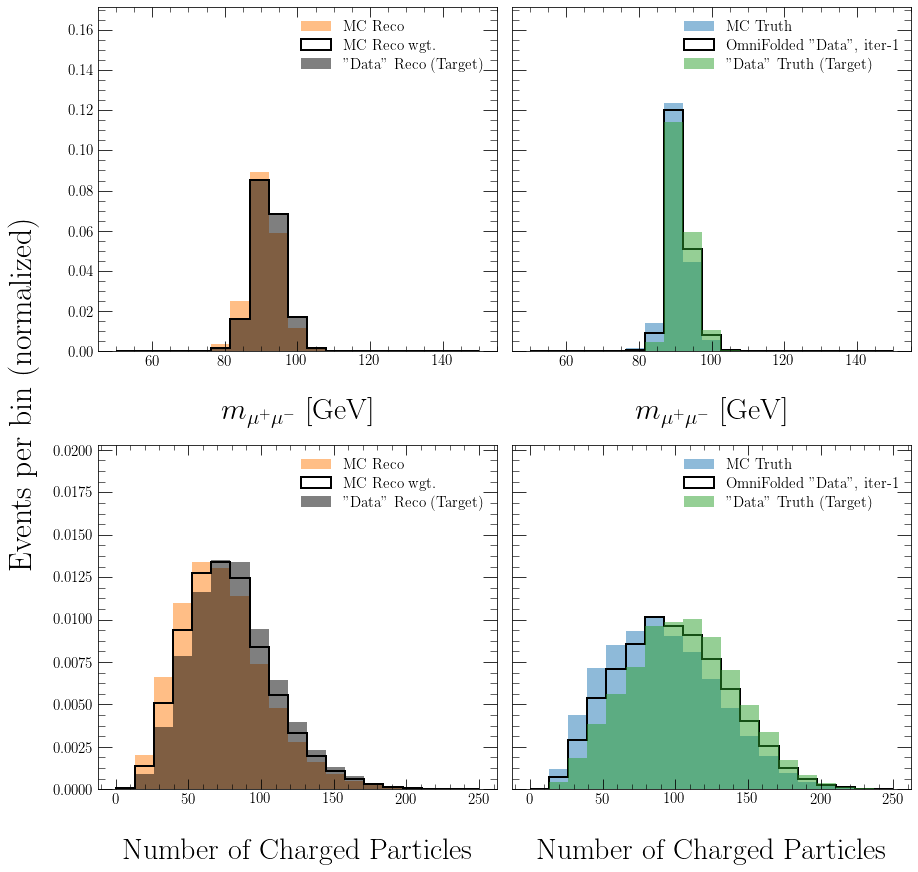

ITERATION: 2


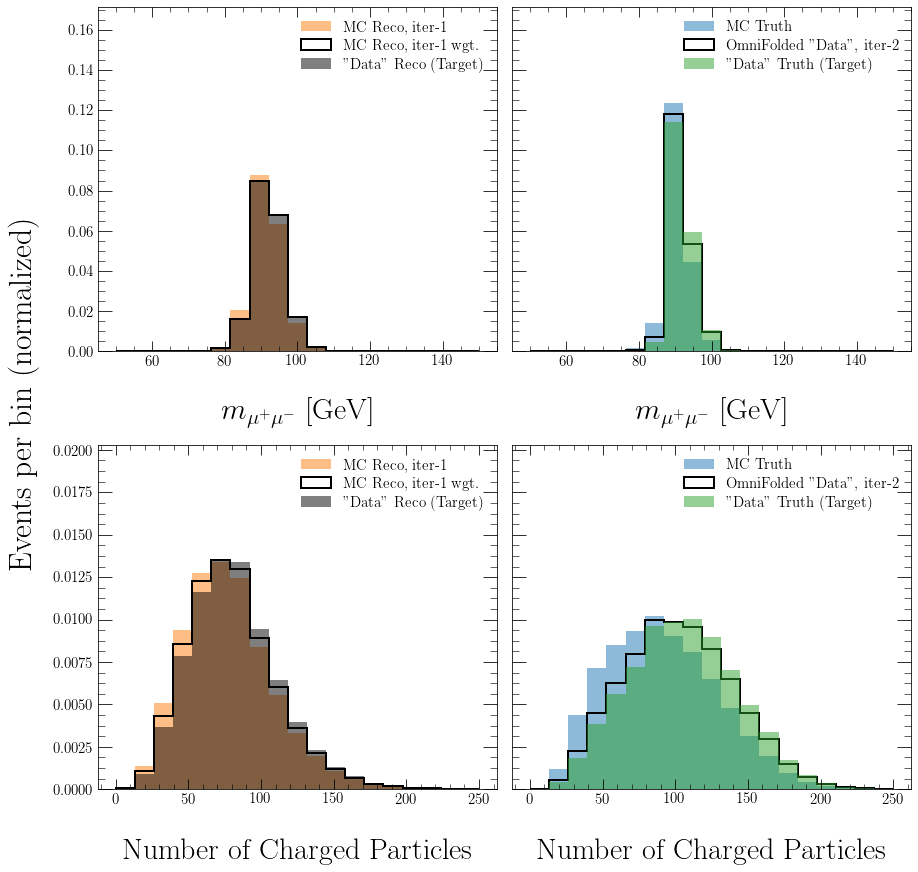

ITERATION: 3


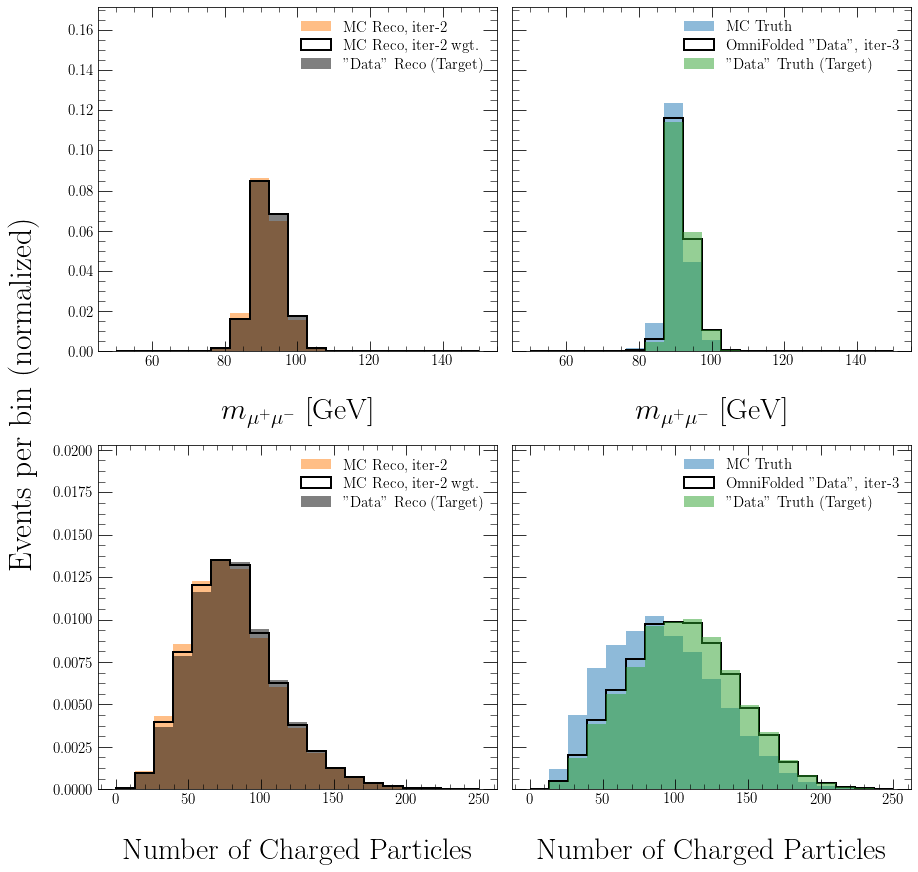

ITERATION: 4


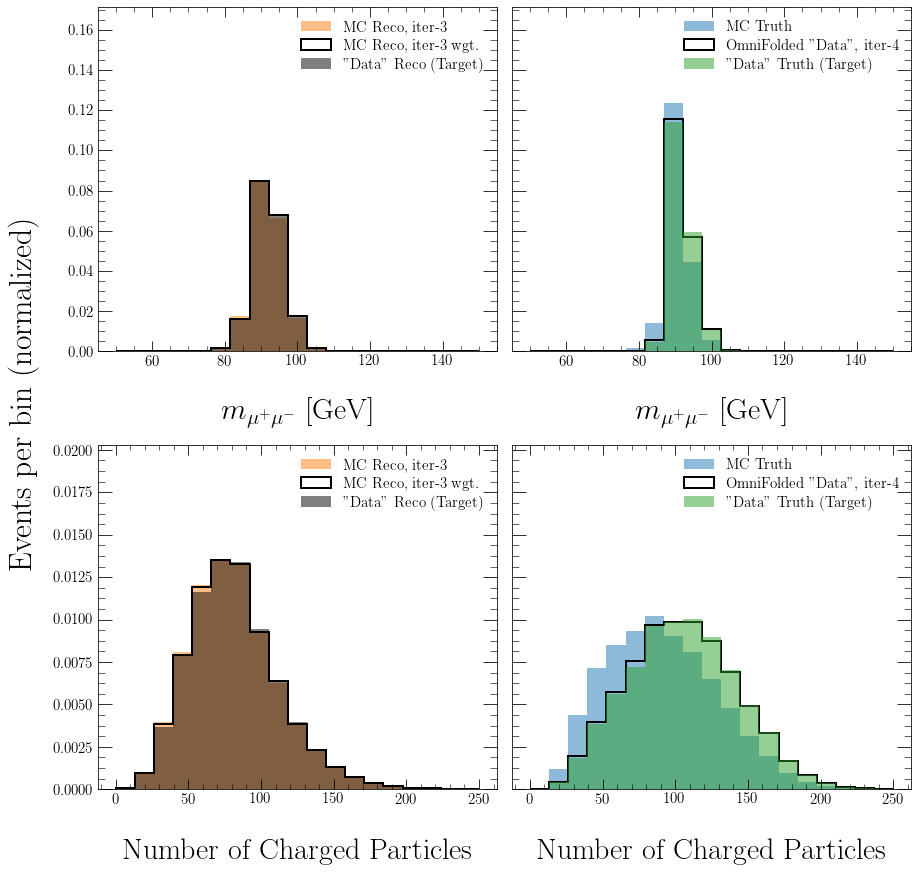

ITERATION: 5


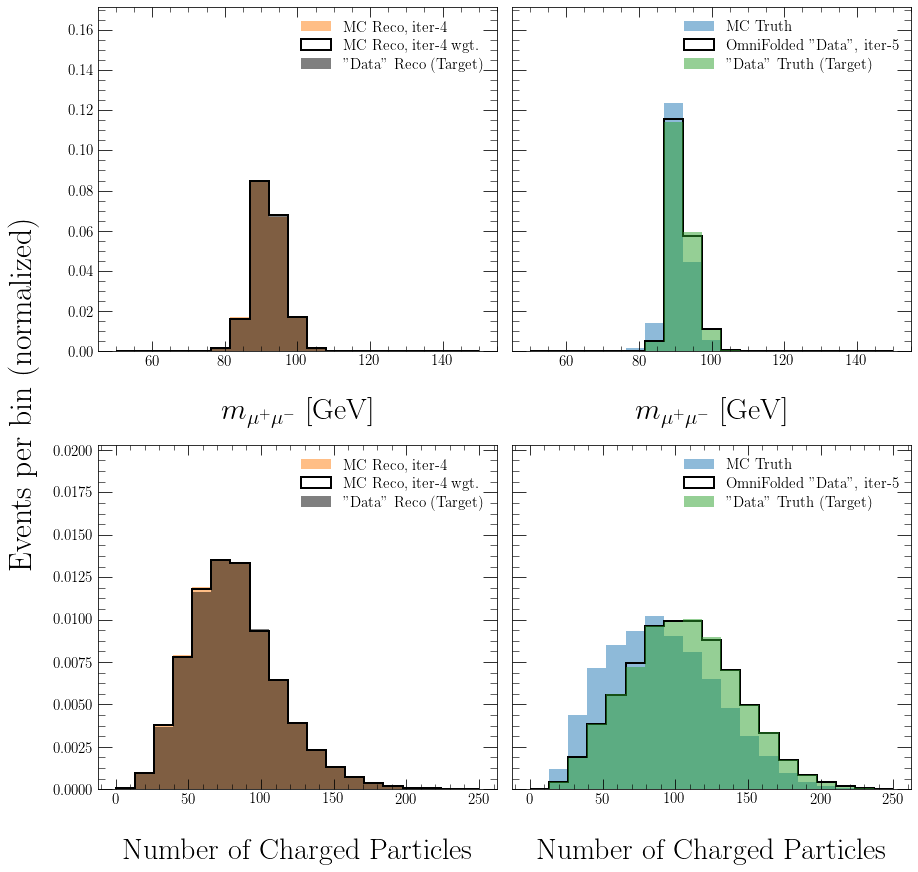

ITERATION: 6


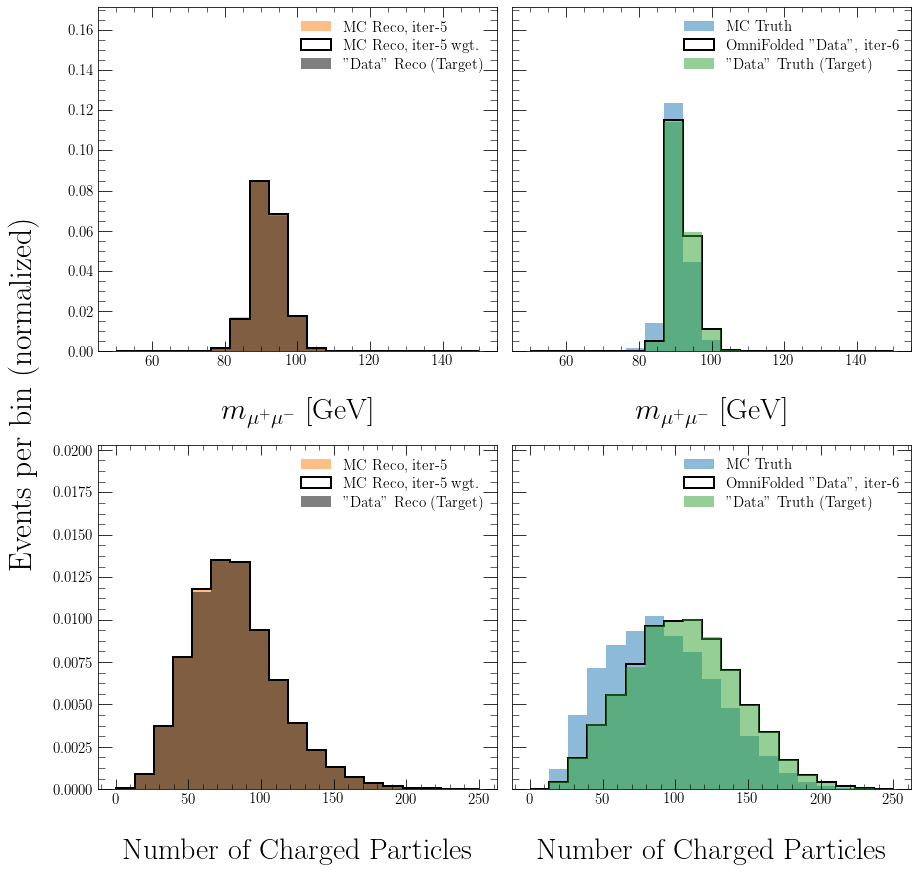

ITERATION: 7


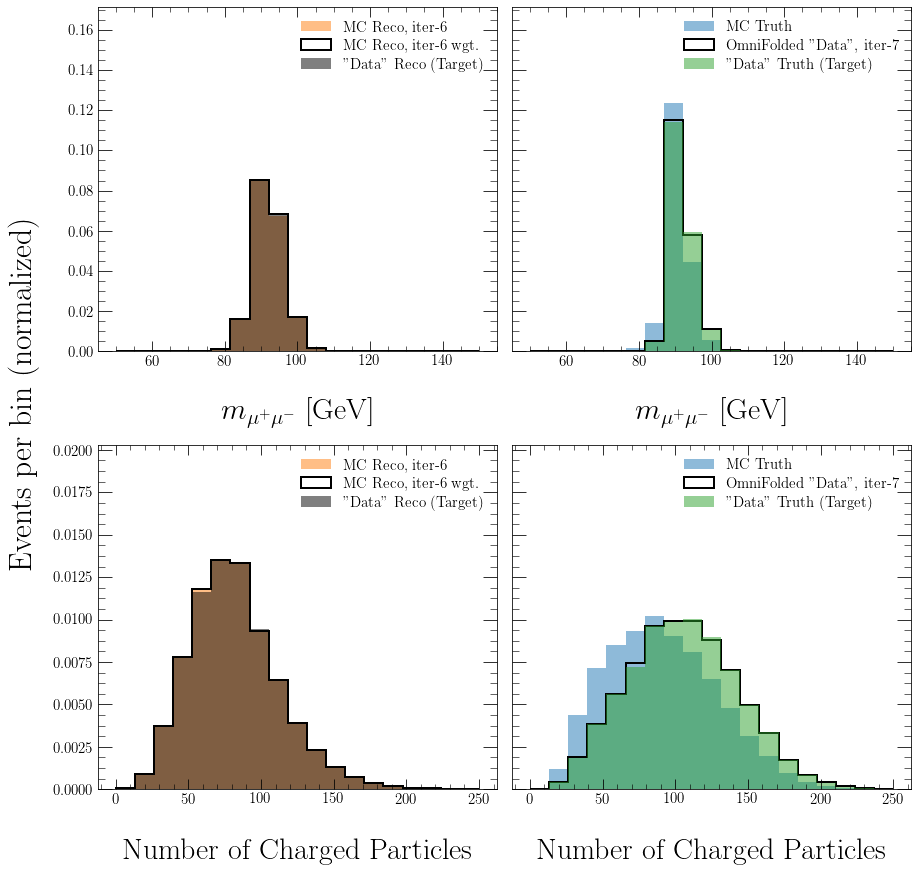

ITERATION: 8


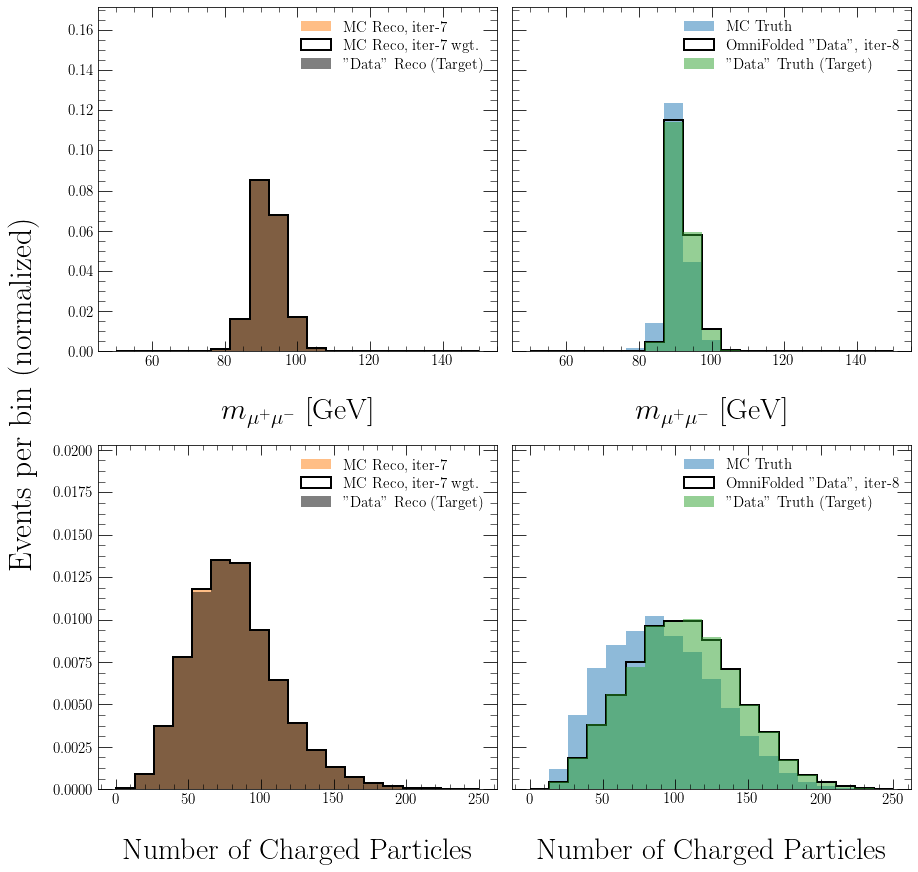

ITERATION: 9


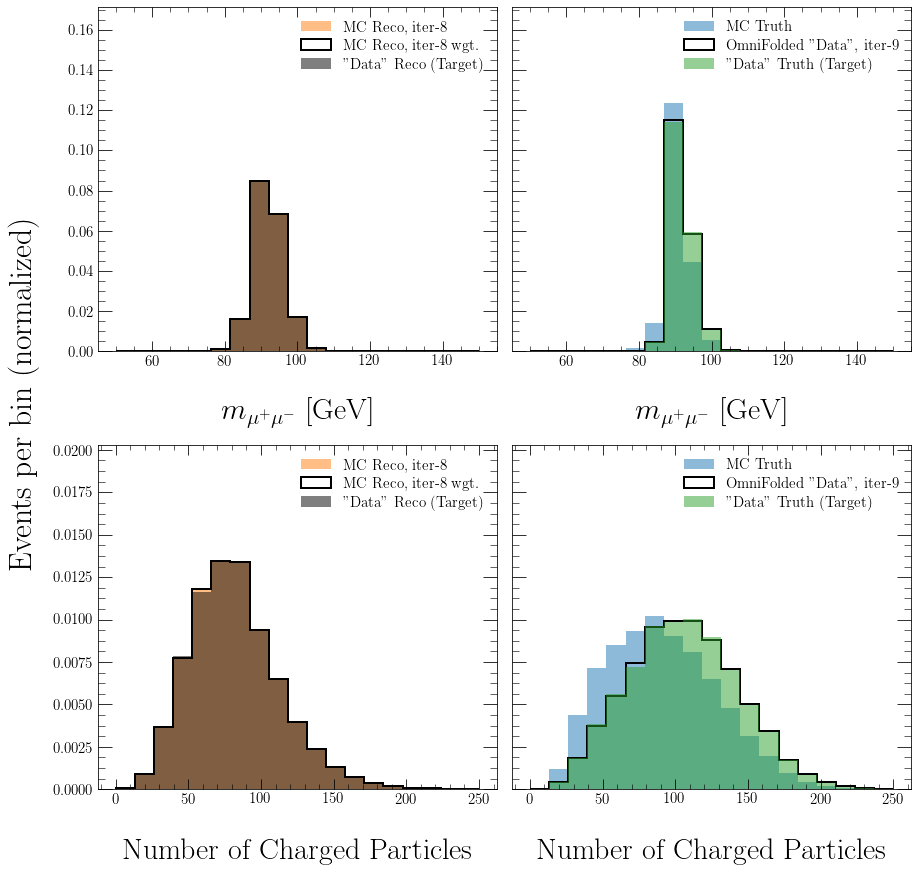

ITERATION: 10


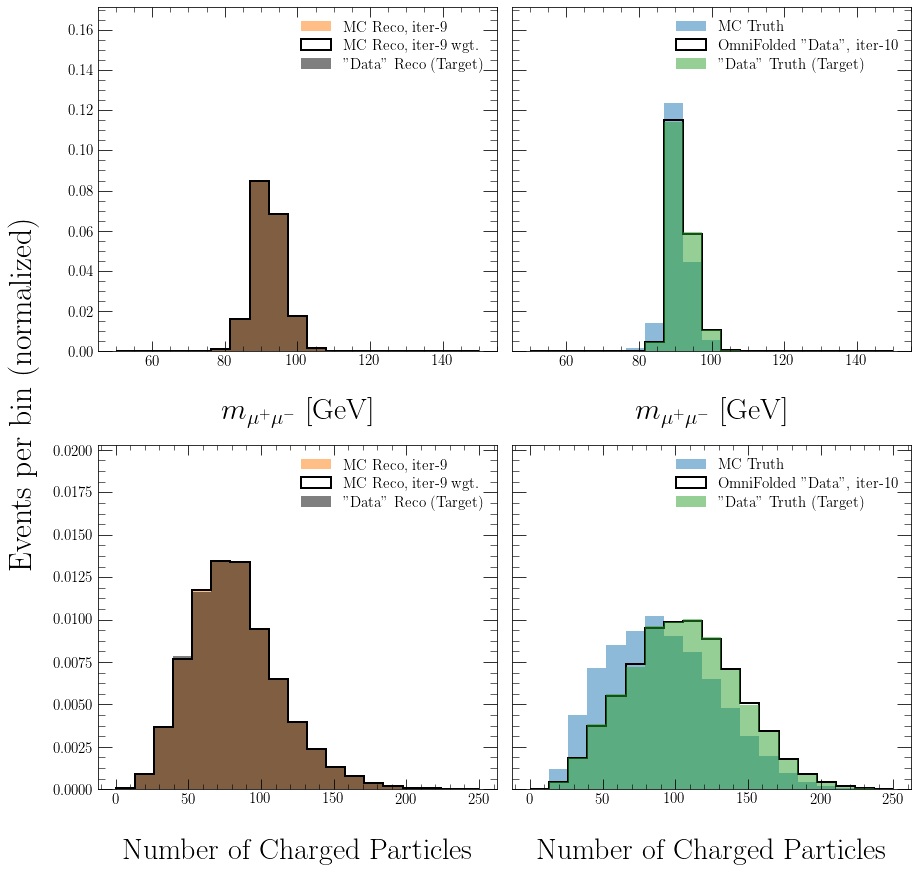

In [89]:
for i in range(len(weights)):
    if i == 0:
        weights_init = np.ones(len(weights[i - 1, 1, :]))
        label0 = ''.format(i)
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(num_observables,
                           2,
                           figsize=(12, 12),
                           constrained_layout=True,
                           sharey='row')

    ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0, 0].hist(m_ll_sim_reco,
                  weights=weights_init,
                  bins=bins,
                  label='MC Reco' + label0,
                  **plot_style_2,
                  color='C1')
    ax[0, 0].hist(m_ll_sim_reco,
                  bins=bins,
                  weights=weights[i, 0, :],
                  label='MC Reco' + label0 + ' wgt.',
                  **plot_style_1)

    hR0, _, _ = ax[0, 0].hist(m_ll_data_reco,
                              weights=weights_stress,
                              bins=bins,
                              label=r'"Data" Reco (Target)',
                              **plot_style_2,
                              color='k')
    ax[0, 0].legend(frameon=False)
    

    ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0, 1].hist(m_ll_sim_truth,
                  bins=bins,
                  label=r'MC Truth',
                  **plot_style_2,
                  color='C0')
    ax[0, 1].hist(m_ll_sim_truth,
                  bins=bins,
                  weights=weights[i, 1, :],
                  label='OmniFolded "Data"' + label1,
                  **plot_style_1)

    hT0, _, _ = ax[0, 1].hist(m_ll_data_truth,
                              weights=weights_stress,
                              bins=bins,
                              label=r'"Data" Truth (Target)',
                              **plot_style_2,
                              color='C2')
    ax[0, 0].set_ylim([0, 1.5 * np.max(np.concatenate((hT0, hR0)))])
    ax[0, 1].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1, 0].set_xlabel('Number of Charged Particles')
    ax[1, 0].hist(nTracks_sim_reco,
                  weights=weights_init,
                  bins=bins,
                  label='MC Reco' + label0,
                  **plot_style_2,
                  color='C1')
    ax[1, 0].hist(nTracks_sim_reco,
                  bins=bins,
                  weights=weights[i, 1, :],
                  label='MC Reco' + label0 + ' wgt.',
                  **plot_style_1)
    hR1, _, _ = ax[1, 0].hist(nTracks_data_reco,
                              weights=weights_stress,
                              bins=bins,
                              label=r'"Data" Reco (Target)',
                              **plot_style_2,
                              color='k')
    ax[1, 0].legend(frameon=False)

    ax[1, 1].set_xlabel('Number of Charged Particles')
    ax[1, 1].hist(nTracks_sim_truth,
                  bins=bins,
                  label=r'MC Truth',
                  **plot_style_2,
                  color='C0')
    ax[1, 1].hist(nTracks_sim_truth,
                  bins=bins,
                  weights=weights[i, 1, :],
                  label='OmniFolded "Data"' + label1,
                  **plot_style_1)
    hT1, _, _ = ax[1, 1].hist(nTracks_data_truth,
                              weights=weights_stress,
                              bins=bins,
                              label=r'"Data" Truth (Target)',
                              **plot_style_2,
                              color='C2')
    ax[1, 1].legend(frameon=False)

    fig.text(-0.05,
             0.55,
             'Events per bin (normalized)',
             va='center',
             rotation='vertical',
             fontsize='x-large')

    ax[1, 0].set_ylim([0, 1.5 * np.max(np.concatenate((hT1, hR1)))])

#     fig.savefig(
#         'SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTest-StressTestB-MultiFold-Iteration{:02}.pdf'
#         .format(i + 1),
#         bbox_inches='tight')
    fig.show()
    plt.show()